In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner
import copy
import pickle
import math
import time
import matplotlib.gridspec as gridspec

from astropy.io import ascii
from itertools import cycle
from itertools import permutations
from scipy.stats import skew

%matplotlib inline

In [2]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=3
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=12
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5


def makeCmap(hexColour,zeroColour='#FFFFFF'):
    r0,g0,b0=mpl.colors.hex2color(zeroColour)
    r,g,b=mpl.colors.hex2color(hexColour)
    cdict = {'red':   ((0.0, r0, r0),
                   (1.0, r, r)),
         'green': ((0.0, g0, g0),
                   (1.0, g, g)),
         'blue':  ((0.0, b0, b0),
                   (1.0, b, b))
        }
    cmap = mpl.colors.LinearSegmentedColormap(hexColour,cdict)
    return cmap


def makeGradient(hexColour):
    r,g,b=mpl.colors.hex2color(hexColour)
    cdict = {'red':   ((0.0, r, r),
                   (1.0, r, r)),
         'green': ((0.0, g, g),
                   (1.0, g, g)),
         'blue':  ((0.0, b, b),
                   (1.0, b, b)),
         'alpha':  ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0))
        }
    cmap = mpl.colors.LinearSegmentedColormap(hexColour,cdict)
    return cmap


def makePlotColours(mappableList,coloursList):
    """
    mappableArray = a list of discrete values, each corresponding to a unique color (zero-indexed)
    coloursList = list of desired colors. Ideally should be at least as many colours as there are unique
                  entries in mappableArray.
    """

    nColours = np.max(mappableList)+1
    uniqueMappableList = np.arange(nColours)
    
    zidx = np.array((mappableList))

    cidx = 0
    colourMaps = []
    cycledColours = []
    for c in cycle(coloursList):
        colourMaps.append(makeGradient(c))
        cycledColours.append(c)
        cidx+=1
        if cidx >= nColours: 
            break
    
    blankCmap=makeGradient('#FFFFFF')
    colours = blankCmap(0.999*np.ones_like(zidx))

    for j in range(0,nColours):
        colours[zidx==j] = colourMaps[j](0.999*np.ones_like(np.arange(0,len(zidx))[zidx==j]))

    return colourMaps,colours,cycledColours,list(uniqueMappableList)

In [3]:
def getLossFromLogfile(filename):
    with open(filename) as f:
        content = f.readlines()
    f.close()
    lastEpoch = content[-5].split("|")
    lastEpochCost = float(lastEpoch[2].split(" ")[2])
    return lastEpochCost

In [4]:
def getLossSeriesFromLogfile(filename,nEpochs=500):
    with open(filename) as f:
        content = f.readlines()
    f.close()
    
    losses = np.zeros((nEpochs))
    for j in range(14,14+nEpochs):
        temp = content[j].split("|")
        losses[j-14] = float(temp[2].split(" ")[2])

    return losses

In [5]:
def randomStablePlanet(testSetSystems, testSetResults, trainingSetResults, trainingSetData, nSamples):
    """
    Predict properties of a planet randomly. (Do not allow orbit crossings, assuming circularity.)
    
    """
    randomPredictions = np.zeros((len(testSetResults), nSamples, np.shape(trainingSetData)[1]))
    
    planetCounter = 0
    
    # system by system
    for i in range(len(testSetSystems)):
        thisSystem = testSetSystems[i][1:] # list of length m, where m is system multiplicity
        
        m = len(thisSystem)
        
        # planet by planet
        for j in range(0,m):
            if j == 0:
                Pmin = np.min(trainingSetData[:,1])
            else:
                Pmin = thisSystem[j-1][1]
                
            if (j == (m-1)):
                Pmax = np.max(trainingSetData[:,1])
            else:
                Pmax = thisSystem[j+1][1]
            
            #draw random planets from the training set that have acceptable periods
            samplePlanets = np.zeros((nSamples,np.shape(trainingSetData)[1]))
            
            allowedPMask = (trainingSetData[:,1] > Pmin) & (trainingSetData[:,1] < Pmax)
            allowedPIdxs = np.arange(len(trainingSetData))[allowedPMask]
            #print(len(allowedPIdxs))
            if len(allowedPIdxs) == 0:
                break
            
            if nSamples > len(allowedPIdxs):
                print("{0}: not enough stable planets".format(j))
                break
            
            samplePlanetIdxs = np.random.choice(allowedPIdxs,size=nSamples)
            samplePlanets = trainingSetData[samplePlanetIdxs]
            randomPredictions[planetCounter] = samplePlanets
            planetCounter+=1
                
    return randomPredictions
    

# Loop over different random seeds

In [6]:
KOIs = ascii.read("../KOIs_chen2018_goodSystems_incJupiters.csv")

obs_features = np.vstack((np.log10(np.array(KOIs['koi_ror'])).T,np.log10(np.array(KOIs['koi_period'])).T,np.array(KOIs['koi_steff']).T,np.array(KOIs['koi_slogg']).T)).T
mod_features = np.vstack((np.log10(np.array(KOIs['koi_prad'])).T,np.log10(np.array(KOIs['koi_sma'])).T,np.log10(np.array(KOIs['koi_insol'])).T,np.log10(np.array(KOIs['koi_srad'])).T,np.log10(np.array(KOIs['koi_smass'])).T)).T
final_features = np.vstack((np.log10(np.array(KOIs['koi_prad'])).T,np.log10(np.array(KOIs['koi_period'])).T,np.array(KOIs['koi_steff']).T,np.array(KOIs['koi_slogg']).T)).T


# Plot predicted vs true

In [7]:
# stuff that's true regardless of num_classes
trainingDataFile = "./realPlanets_incJ_100xtrainingset/realKOIs_finalFeatures_incJ_100xtrainingset_70percent.txt"
CVDataFile = "./realPlanets_incJ_100xtrainingset/realKOIs_finalFeatures_incJ_30percent.txt"

# constraints based on stability
# kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr
#constraints = np.genfromtxt("./realPlanets_obs/realKOIs_targetConstraints.txt")

n_planet_features = 2
n_stellar_features = 2
n_features = n_planet_features + n_stellar_features

# for predictions
n_samples = 100


features = final_features

#from the notebook where I made the training set with uncertainties
mus = np.array((3.09018260e-01,1.19926868e+00,5.55205755e+03,4.38436463e+00))#np.mean(features,axis=0)
sigmas = np.array((3.23225253e-01,6.75679251e-01,6.89930633e+02,3.36770684e-01))#np.std(features,axis=0)


# obs
#labels = [r'$\log_{10}R_p/R_*$',r'$\log_{10}P$ [days]',r'$T_{eff}$ [K]',r'$\log{g}\ [\mathrm{cm}/\mathrm{s}^2]$']
#lims = [(-2,2),(-2,2),(-1.,1.),(-0.5,0.5)]
#scatterlims = [(-2.5,-0.8),(-0.75,3.25),(4000,7000),(3.75,5.25)]

# mod
#labels = [r'$\log_{10}R_p\ [R_\oplus]$',r'$\log_{10}a$ [AU]',r'$\log_{10}S\ [S_\oplus]$',r'$\log_{10}R_*\ [R_\odot]$',r'$\log_{10}M_*\ [M_\odot]$']
#lims = [(-2,2),(-2,2),(-1.,1.),(-1.,1.),(-1.,1.)]
#scatterlims = [(-0.5,1.25),(-2.1,0.2),(-1.5,5),(-3,3),(-3,3)]

# final
labels = [r'$\log_{10}R_p\ [R_\oplus]$',r'$\log_{10}P$ [days]',r'$T_{eff}$ [K]',r'$\log{g}\ [\mathrm{cm}/\mathrm{s}^2]$']
lims = [(-2,2),(-2,2),(-1.,1.),(-0.5,0.5)]
scatterlims = [(-0.5,1.75),(-0.75,3.25),(4000,7000),(3.75,5.25)]



In [8]:
print(mus)
print(sigmas)

[3.09018260e-01 1.19926868e+00 5.55205755e+03 4.38436463e+00]
[3.23225253e-01 6.75679251e-01 6.89930633e+02 3.36770684e-01]


# Figure out which random seed 0,...,99 had the optimal cost function.

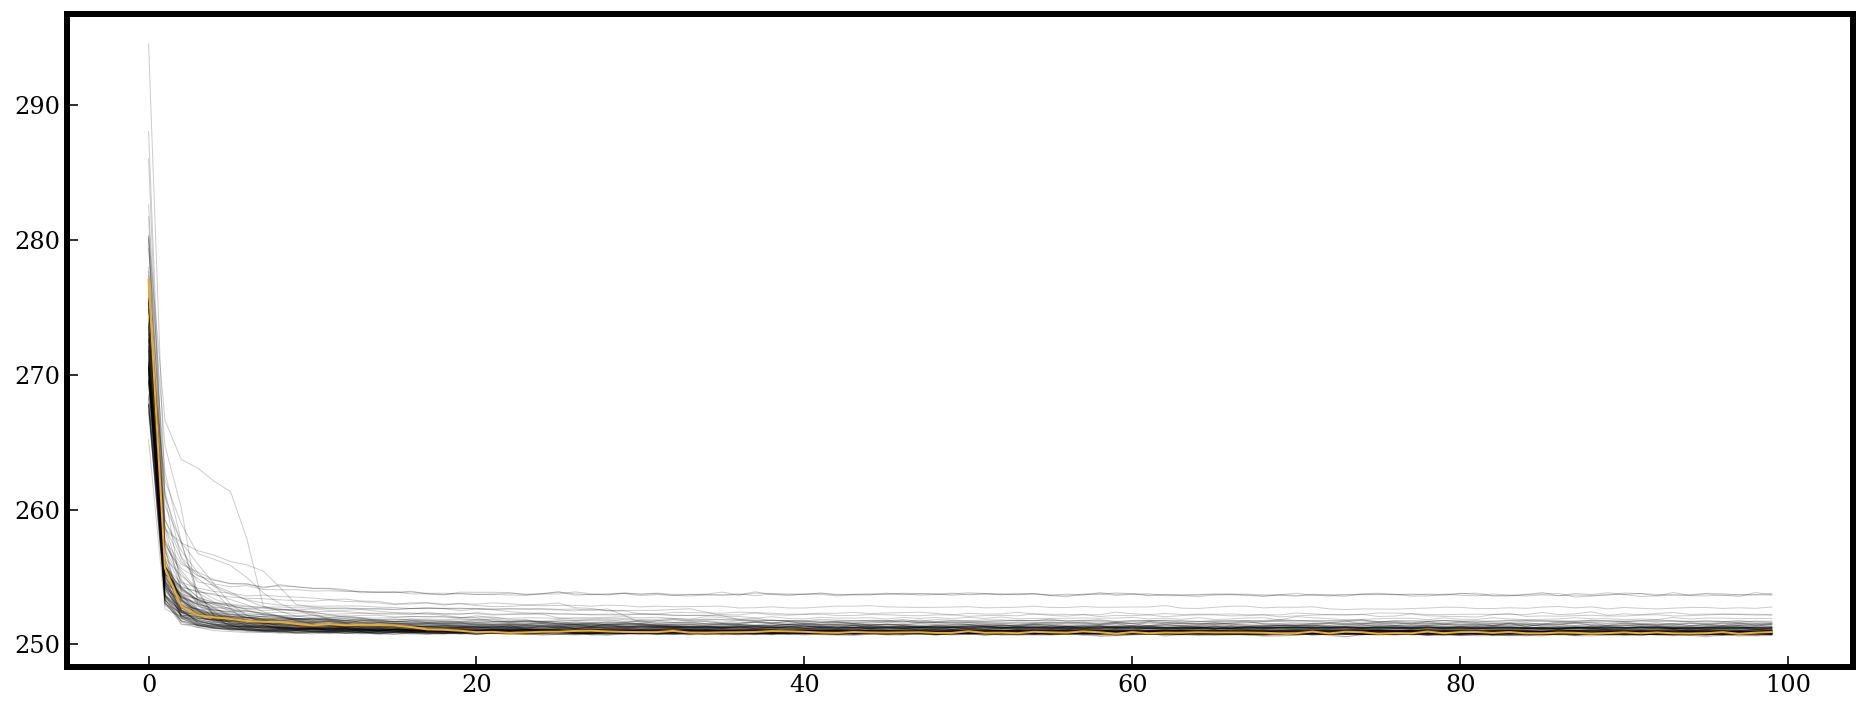

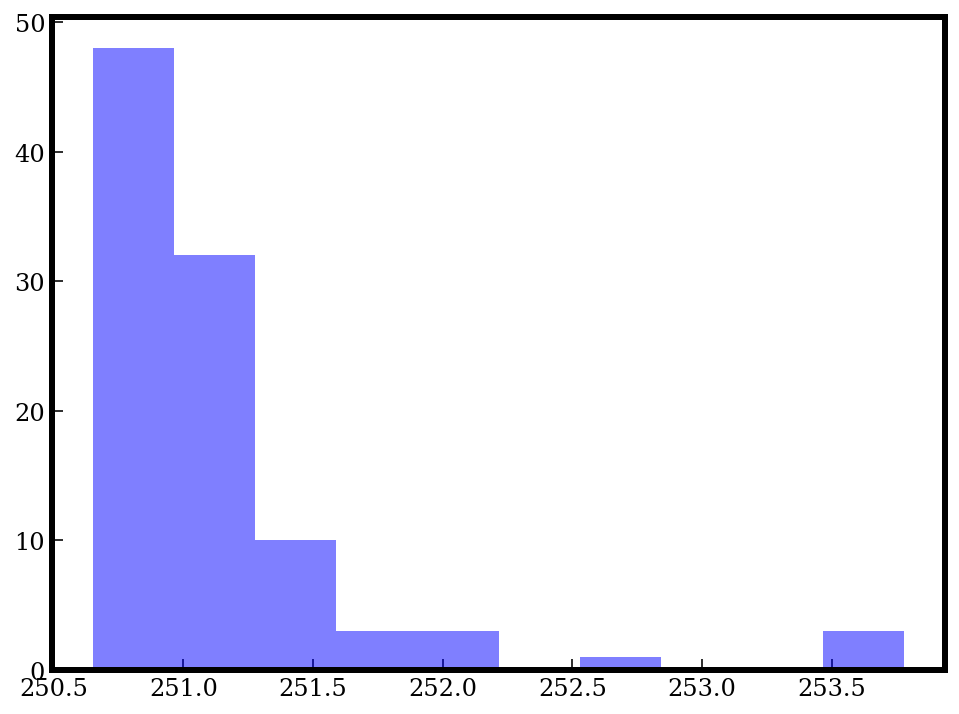

In [12]:
loss_arr = np.zeros((100))

fig1 = plt.figure(figsize=(16,6))

for j in range(0,len(loss_arr)):
    resultsFolder = "./realPlanets_incJ_100xtrainingset"
    loss_arr[j] = getLossFromLogfile("{0}/realKOIs_incJ_finalFeatures_100xtrainingset_seed={1}.log".format(resultsFolder,j))
    losses = getLossSeriesFromLogfile("{0}/realKOIs_incJ_finalFeatures_100xtrainingset_seed={1}.log".format(resultsFolder,j),nEpochs=100)
    if j==90:
        plt.plot(np.arange(100),losses,color='#F6AA1C',ls='-',lw=1,alpha=1,zorder=101)
    else:
        plt.plot(np.arange(100),losses,color='k',ls='-',lw=0.5,alpha=0.2,zorder=j)
plt.show()
    
fig = plt.figure(figsize=(8,6)) 
plt.hist(loss_arr,color='b',alpha=0.5)    
plt.show()


In [13]:
print(np.min(loss_arr))
print(np.argmin(loss_arr))

250.650615811348
64


In [14]:
# optimal seed
#seed = np.argmin(loss_arr)

# No! No reason not to loop over all seeds. We want error bars on the NN predictions!

# the 7-planet system ended up in the training set this time
maxmult = 6

contextPred_allSeeds = np.zeros((1278,2,100))
randomPred_allSeeds = np.zeros((1278,4,10000))
#contextPred_allSeeds = np.zeros((1278,2,1))
#randomPred_allSeeds = np.zeros((1278,4,100))


resultsFolder = "./realPlanets_incJ_100xtrainingset"
for s,seed in enumerate(range(100)):
#for s,seed in enumerate(range(90,91)):
    print(seed)
    # get CV data
    with open(CVDataFile, "rb") as picklefile:
        testSystems = pickle.load(picklefile)

    CVdata = np.zeros((1,n_features+2))
    
    count = 0
    for i in range(len(testSystems)):
        sys = testSystems[i]
        ID = sys[0]
        for j in range(1,len(sys)):
            row = np.zeros_like(CVdata[0])
            row[:-2] = np.array(sys[j])[0:n_features]
            row[-2] = ID
            row[-1] = count
            count += 1
            CVdata = np.vstack((CVdata,row))   
    CVdata = CVdata[1:]
    
    mults = np.zeros_like(CVdata[:,0])
    for i in range(len(CVdata)):
        thisSystemMask = (CVdata[:,-2] == CVdata[i,-2])
        mults[i] = int(len(CVdata[thisSystemMask]))

    CVdata = np.hstack((CVdata,np.atleast_2d(mults).T))
    #columns: log10Rp, log10P, Teff, logg, sysID, rowidx, mult
    
    logfile = "{0}/realKOIs_incJ_finalFeatures_100xtrainingset_seed={1}.log".format(resultsFolder,seed)
    losses = np.load("{0}/realKOIs_finalFeatures_incJ_100xtrainingset_70percent_losses_{1}.npy".format(resultsFolder,seed))
    #print(losses)
    CVresults = np.load("{0}/realKOIs_finalFeatures_incJ_30percent_truths_fromtarget_{1}.npy".format(resultsFolder,seed))
    CVresults_fromContext = np.load("{0}/realKOIs_finalFeatures_incJ_30percent_predictions_fromcontext_{1}.npy".format(resultsFolder,seed))
    CVidxs = np.load("{0}/realKOIs_finalFeatures_incJ_30percent_idxs_{1}.npy".format(resultsFolder,seed))

    CVdata = CVdata[CVidxs]
    
    #ok. now we have knowledge of how CVidxs shuffled the CVdata, because we can look at CVdata[:,3], which is the previously-ordered index column.
    # let's sort everything to get that column back in order...
    #print(np.shape(CVdata))
    sortIdxs = np.argsort(CVdata[:,-2])
    
    CVresults = CVresults[sortIdxs]
    CVresults_fromContext = CVresults_fromContext[sortIdxs]
    CVdata = CVdata[sortIdxs]
    
    contextPred_allSeeds[:,:,s] = CVresults_fromContext

    #print('CVdata is {0}'.format(np.shape(CVdata)))
    #print('CVresults_fromContext is {0}'.format(np.shape(CVresults_fromContext)))
    
    # get training data
    trainingIdxs = np.load("{0}/realKOIs_finalFeatures_incJ_100xtrainingset_70percent_idxs_{1}.npy".format(resultsFolder,seed))

    with open(trainingDataFile,"rb") as picklefile:
        trainingSystems = pickle.load(picklefile)

    trainingData = np.zeros((1,n_planet_features+2))
    
    count = 0
    for i in range(len(trainingSystems)):
        sys = trainingSystems[i]
        ID = sys[0]
        for j in range(1,len(sys)):
            row = np.zeros(n_planet_features+2)
            row[:-2] = np.array(sys[j])[0:n_planet_features]
            row[-2] = ID
            row[-1] = count
            trainingData = np.vstack((trainingData,row))
            count += 1
    # columns: log10Rp, log10P, sysID, rowidx
    trainingData = trainingData[1:][trainingIdxs]
    trainingSortIdxs = np.argsort(trainingData[:,-1])

    # NN predictions
    trainingResults = np.load("./{0}/realKOIs_finalFeatures_incJ_100xtrainingset_70percent_truths_fromtarget_{1}.npy".format(resultsFolder,seed))
    
    trainingData = trainingData[trainingSortIdxs]
    trainingResults = trainingResults[trainingSortIdxs]
    
    # naive predictions
    randomPredictions = randomStablePlanet(testSetSystems=testSystems, 
                                            testSetResults=CVresults_fromContext,
                                            trainingSetResults=trainingResults, 
                                            trainingSetData=trainingData, 
                                            nSamples=n_samples)
    randomPred_allSeeds[:,:,100*s:100*(s+1)] = np.swapaxes(randomPredictions,1,2)
    #randomPred_allSeeds[:,:,s:(s+1)] = np.swapaxes(randomPredictions,1,2)
    #print('randomPredictions is {0}'.format(np.shape(randomPredictions)))
    
#need:
#CVdata (1278,5), same for all seeds
#CVresults_fromContext (1278,2), different for all seeds
#randomPredictions (1278, 100, 4), should be ~same for all seeds
print(np.shape(CVdata)) #(1278,5)
print(CVdata[:,-2])
print(np.shape(contextPred_allSeeds)) #(1278,2,100)
print(np.shape(randomPred_allSeeds))  #(1278,4,10000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
(1278, 7)
[0.000e+00 1.000e+00 2.000e+00 ... 1.275e+03 1.276e+03 1.277e+03]
(1278, 2, 100)
(1278, 4, 10000)


In [15]:
print(np.shape(np.mean(contextPred_allSeeds,axis=2)))

(1278, 2)


m is 1.0
m is 2.0
m is 3.0
m is 4.0
m is 5.0
m is 6.0


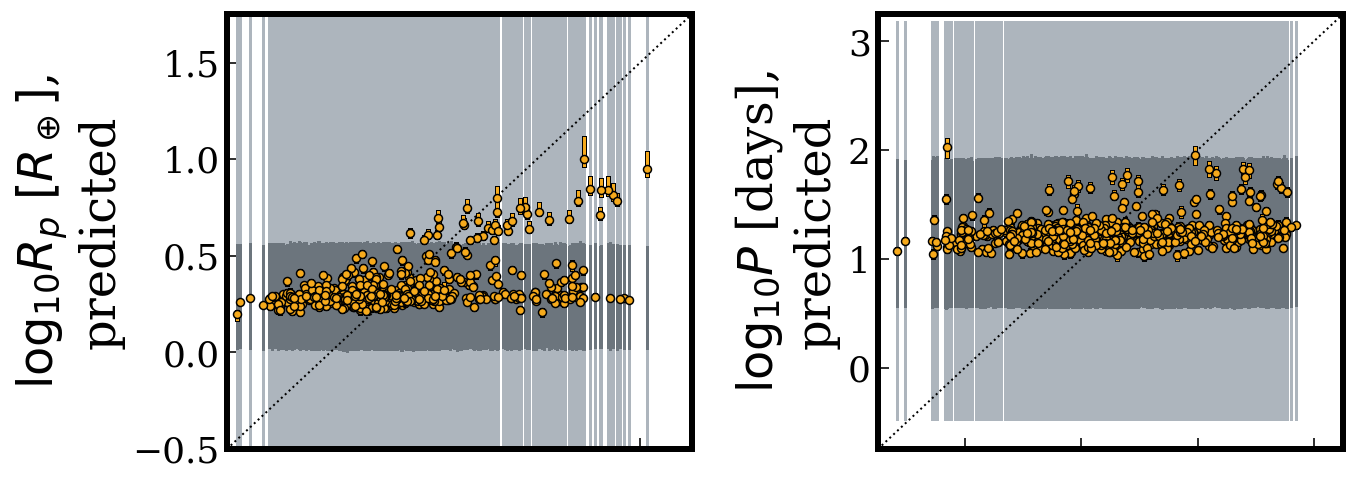

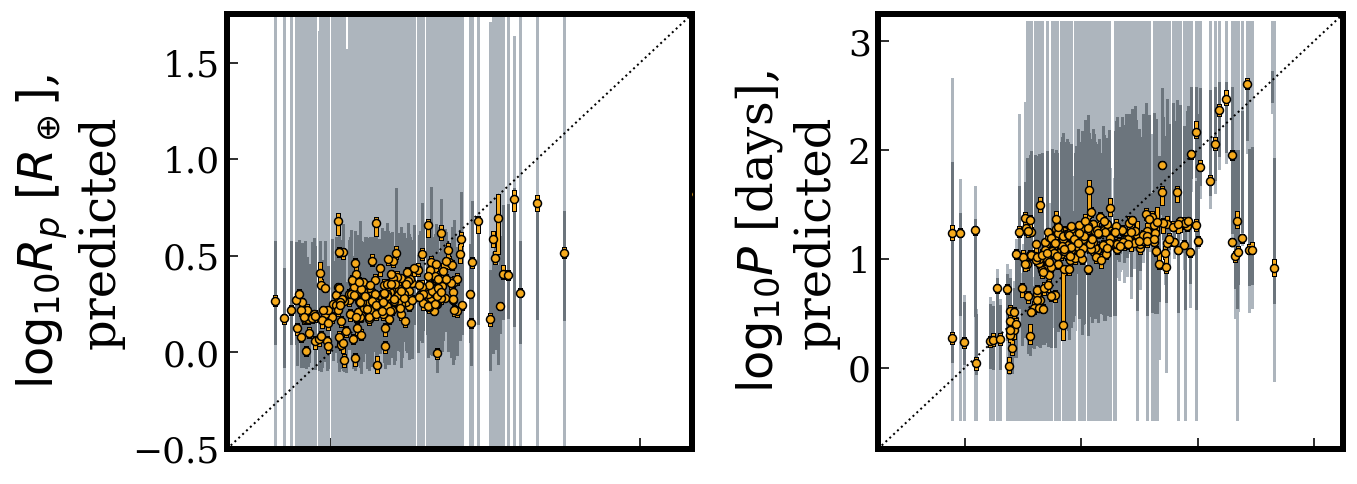

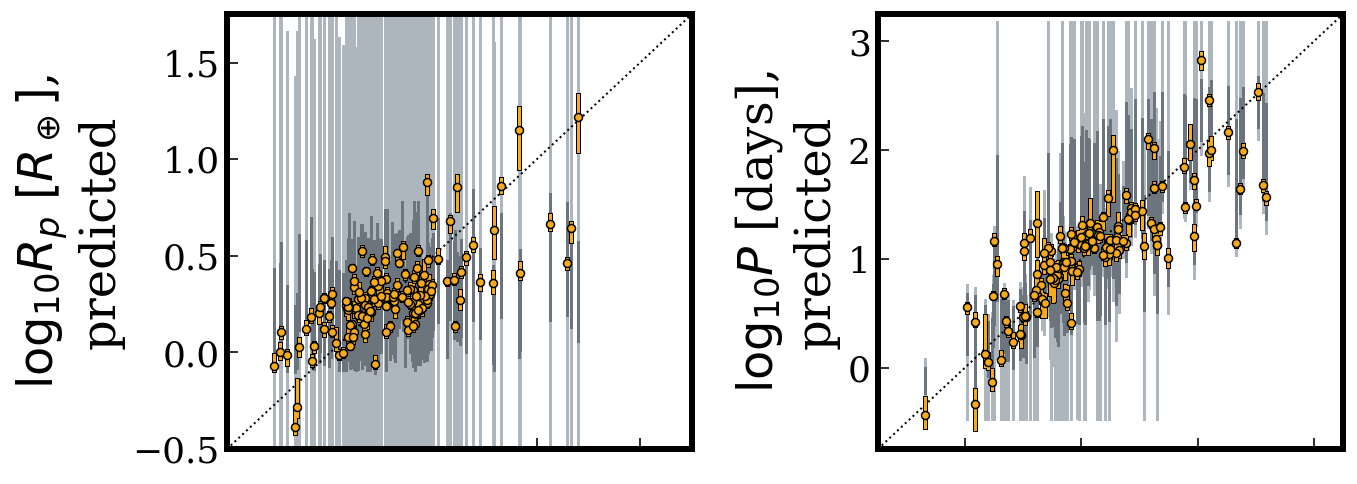

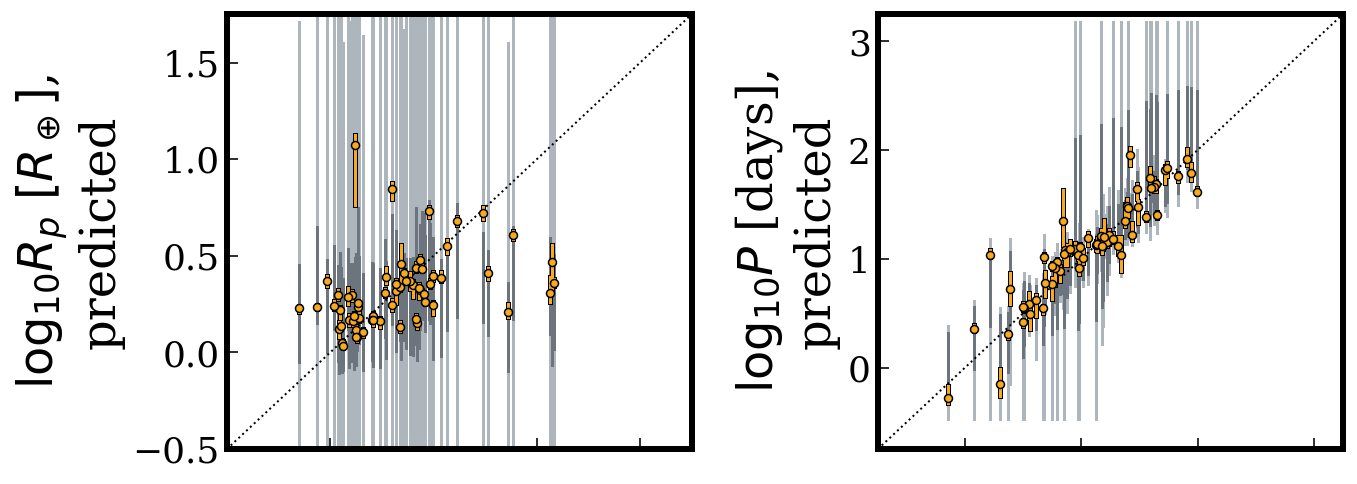

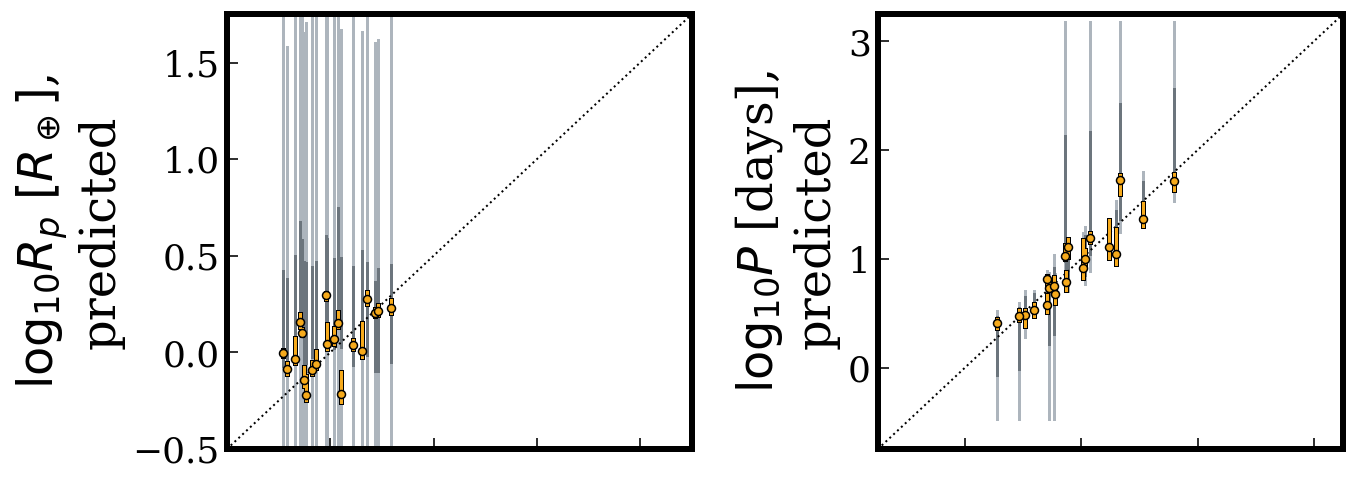

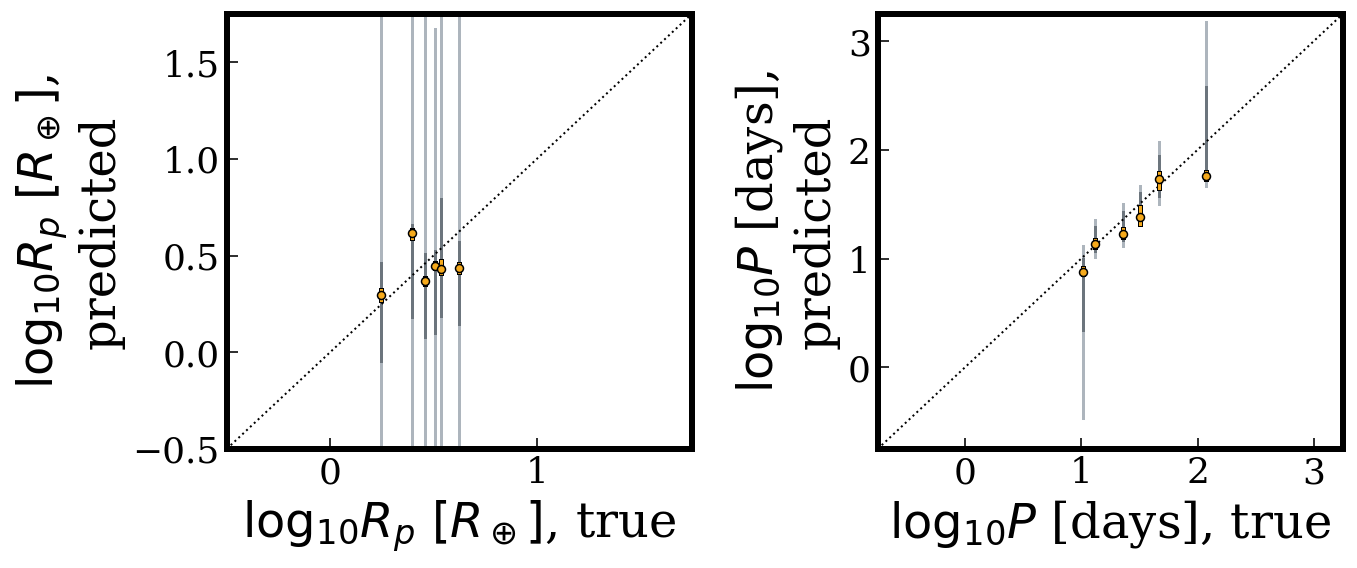

In [16]:
# plot training-based predictions

NNmin = np.min(contextPred_allSeeds,axis=2)
NN16 = np.percentile(contextPred_allSeeds,16,axis=2)
NN50 = np.percentile(contextPred_allSeeds,50,axis=2)
NN84 = np.percentile(contextPred_allSeeds,84,axis=2)
NNmax = np.max(contextPred_allSeeds,axis=2)

randommin = np.min(randomPred_allSeeds,axis=2)
random16 = np.percentile(randomPred_allSeeds,16,axis=2)
random50 = np.percentile(randomPred_allSeeds,50,axis=2)
random84 = np.percentile(randomPred_allSeeds,84,axis=2)
randommax = np.max(randomPred_allSeeds,axis=2)

for m in np.sort(np.unique(mults)):
    print("m is {0}".format(m))
    fig,axes = plt.subplots(1,n_planet_features,figsize = (n_planet_features*5,4))
        
    for i in range(n_planet_features):
        axes[i].plot(((CVdata[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m],
                     ((NN50[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m],
                     color='#F6AA1C',marker='.',ms=8,mew=0.75,mec="k",ls="None",alpha=1,zorder=6)
        
        #axes[i].plot(((CVdata[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m],
        #             ((random50[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m],
        #             color='k',marker='.',ms=8,mew=0.75,mec="k",ls="None",alpha=1,zorder=7)
        
        for p_i in range(len(CVdata[CVdata[:,-1] == m])):
            NN_1sig = np.array((((NN16[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i],
                                 ((NN84[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i]))
            NN_range = np.array((((NNmin[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i],
                                 ((NNmax[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i]))
            
            
            #axes[i].plot(((CVdata[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i] * np.ones((2)),
            #         NN_range,
            #         color='#C48208',marker='None',ls='-',lw=1.5,alpha=1,zorder=3)
            
            
            axes[i].plot(((CVdata[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i] * np.ones((2)),
                     NN_1sig,
                     color='k',marker='None',ls='-',lw=2.5,alpha=1,zorder=4)
            axes[i].plot(((CVdata[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i] * np.ones((2)),
                     NN_1sig,
                     color='#F6AA1C',marker='None',ls='-',lw=1.5,alpha=1,zorder=5)
        
            
            random_1sig = np.array((((random16[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i],
                                 ((random84[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i]))
            random_range = np.array((((randommin[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i],
                                 ((randommax[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i]))
            
            axes[i].plot(((CVdata[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i] * np.ones((2)),
                     random_range,
                     color='#adb5bd',marker='None',ls='-',lw=1.5,alpha=1,zorder=1)
            
            axes[i].plot(((CVdata[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i] * np.ones((2)),
                     random_1sig,
                     color='#6c757d',marker='None',ls='-',lw=1.5,alpha=1,zorder=2)
            
        if m==6:
            axes[i].set_xlabel("{0}, true".format(labels[i]),fontsize=24)
            axes[i].tick_params(axis='x', labelsize=18)
        else:
            axes[i].set_xticklabels([])
        axes[i].set_ylabel("{0},\npredicted".format(labels[i]),fontsize=24)
        axes[i].tick_params(axis='y', labelsize=18)
        axes[i].set_xlim(scatterlims[i])
        axes[i].set_ylim(scatterlims[i])

        x_ = np.linspace(scatterlims[i][0],scatterlims[i][1],2)
        axes[i].plot(x_,x_,'k:',lw=1)
        #axes[i].legend(loc='best',frameon='False')
    plt.subplots_adjust(wspace=0.4)
    #axes[0].set_title("m = {0}".format(int(m)),fontsize=18)

    #plt.show()
    plt.savefig("./{0}/realKOIs_finalFeatures_incJ_30percent_CV_stablePredictions_overAllSeeds_mult={2}.pdf".format(resultsFolder,seed,m),fmt="pdf",bbox_inches="tight")
    #plt.close()

# What are the high-radius single-planet systems with good Rp predictions?

(1278, 7)


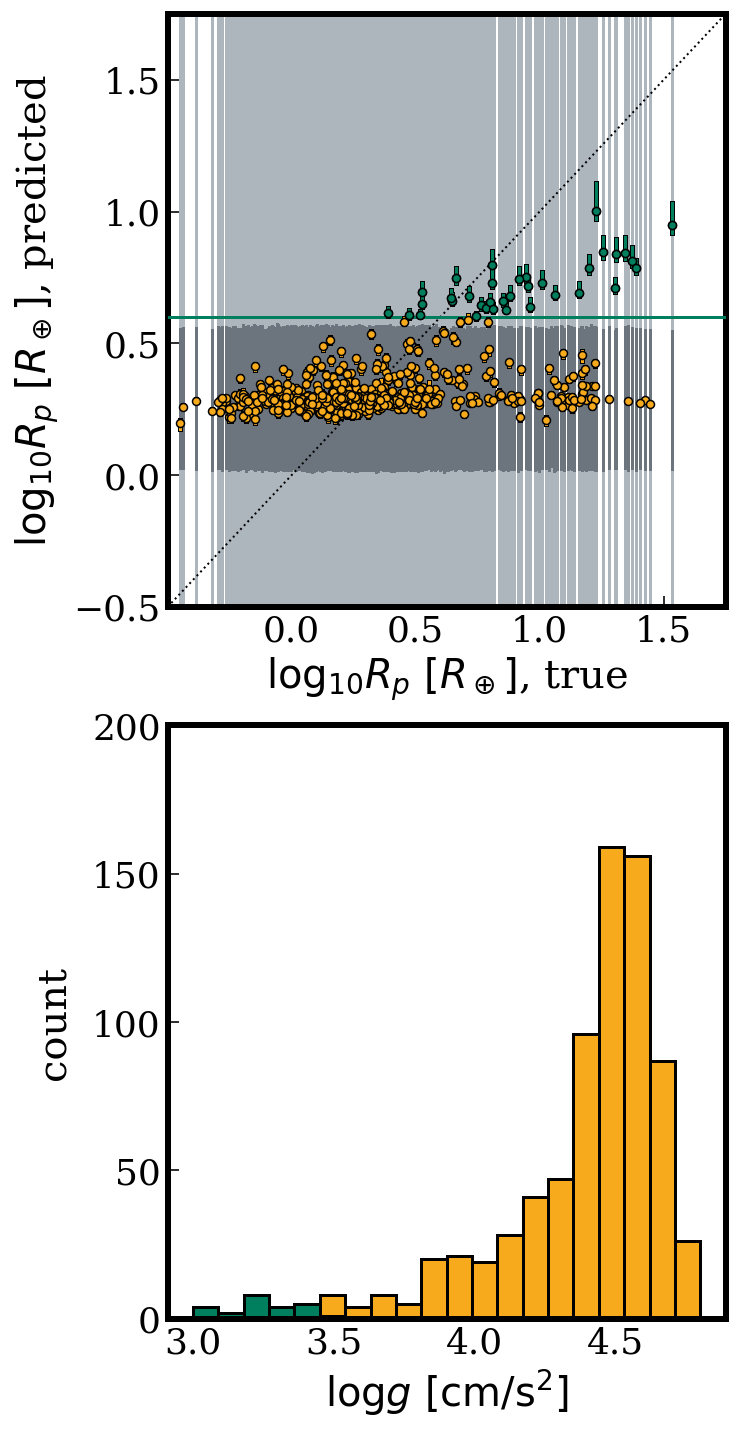

In [17]:
goodRp_cutoff = 0.6

for m in [1]:
    goodRpMask = ((CVdata[:,-1] == m) & (((NN50[:,0]*sigmas[0])+mus[0]) > goodRp_cutoff))
    
    mpl.rcParams['axes.linewidth']=3
    
    fig,axes = plt.subplots(2,1,figsize = (5,12))
    
    axes[0].axhline(goodRp_cutoff,color='#007f5f',lw=1.5,zorder=3)
        
    axes[0].plot(((CVdata[:,0]*sigmas[0])+mus[0])[CVdata[:,-1] == m],
            ((NN50[:,0]*sigmas[0])+mus[0])[CVdata[:,-1] == m],
            color='#F6AA1C',marker='.',ms=8,mew=0.75,mec="k",ls="None",alpha=1,zorder=6)
    
    axes[0].plot(((CVdata[:,0]*sigmas[0])+mus[0])[goodRpMask],
            ((NN50[:,0]*sigmas[0])+mus[0])[goodRpMask],
            color='#007f5f',marker='.',ms=8,mew=0.75,mec="k",ls="None",alpha=1,zorder=6)
       
    for p_i in range(len(CVdata[CVdata[:,-1] == m])):
        NN_1sig = np.array((((NN16[:,0]*sigmas[0])+mus[0])[CVdata[:,-1] == m][p_i],
                            ((NN84[:,0]*sigmas[0])+mus[0])[CVdata[:,-1] == m][p_i]))
        NN_range = np.array((((NNmin[:,0]*sigmas[0])+mus[0])[CVdata[:,-1] == m][p_i],
                            ((NNmax[:,0]*sigmas[0])+mus[0])[CVdata[:,-1] == m][p_i]))
            
            
        axes[0].plot(((CVdata[:,0]*sigmas[0])+mus[0])[CVdata[:,-1] == m][p_i] * np.ones((2)),
                     NN_1sig,
                     color='k',marker='None',ls='-',lw=2.5,alpha=1,zorder=4)
        axes[0].plot(((CVdata[:,0]*sigmas[0])+mus[0])[CVdata[:,-1] == m][p_i] * np.ones((2)),
                     NN_1sig,
                     color='#F6AA1C',marker='None',ls='-',lw=1.5,alpha=1,zorder=5)
        
            
        random_1sig = np.array((((random16[:,0]*sigmas[0])+mus[0])[CVdata[:,-1] == m][p_i],
                                 ((random84[:,0]*sigmas[0])+mus[0])[CVdata[:,-1] == m][p_i]))
        random_range = np.array((((randommin[:,0]*sigmas[0])+mus[0])[CVdata[:,-1] == m][p_i],
                                 ((randommax[:,0]*sigmas[0])+mus[0])[CVdata[:,-1] == m][p_i]))
            
        axes[0].plot(((CVdata[:,0]*sigmas[0])+mus[0])[CVdata[:,-1] == m][p_i] * np.ones((2)),
                     random_range,
                     color='#adb5bd',marker='None',ls='-',lw=1.5,alpha=1,zorder=1)
            
        axes[0].plot(((CVdata[:,0]*sigmas[0])+mus[0])[CVdata[:,-1] == m][p_i] * np.ones((2)),
                     random_1sig,
                     color='#6c757d',marker='None',ls='-',lw=1.5,alpha=1,zorder=2)
    
    for p_i in range(len(CVdata[goodRpMask])):
        NN_1sig = np.array((((NN16[:,0]*sigmas[0])+mus[0])[goodRpMask][p_i],
                            ((NN84[:,0]*sigmas[0])+mus[0])[goodRpMask][p_i]))
        axes[0].plot(((CVdata[:,0]*sigmas[0])+mus[0])[goodRpMask][p_i] * np.ones((2)),
                     NN_1sig,
                     color='#007f5f',marker='None',ls='-',lw=1.5,alpha=1,zorder=5)
                
    
    axes[0].set_xlabel("{0}, true".format(labels[0]),fontsize=20)
    axes[0].tick_params(axis='x', labelsize=18)
    axes[0].set_yticks(np.array((-0.5,0.0,0.5,1.0,1.5)))
    axes[0].set_xticks(np.array((0.0,0.5,1.0,1.5)))
                
    axes[0].set_ylabel("{0}, predicted".format(labels[0]),fontsize=20,labelpad=5.5)
    axes[0].tick_params(axis='y', labelsize=18)
    axes[0].set_xlim(scatterlims[0])
    axes[0].set_ylim(scatterlims[0])

    x_ = np.linspace(scatterlims[0][0],scatterlims[0][1],2)
    axes[0].plot(x_,x_,'k:',lw=1)

    #plt.savefig("./{0}/realKOIs_finalFeatures_incJ_30percent_CV_stablePredictions_{1}_mult={2}_goodRp.pdf".format(resultsFolder,seed,m),fmt="pdf",bbox_inches="tight")
    #plt.show()
    
    print(np.shape(CVdata))
    #fig,ax = plt.subplots(1,1,figsize = (5,5))
    axes[1].hist(((CVdata[:,3]*sigmas[3])+mus[3])[CVdata[:,-1] == m],range=(3.0,4.8),bins=20,color='#F6AA1C',edgecolor='k',linewidth=1.5)
    axes[1].hist(((CVdata[:,3]*sigmas[3])+mus[3])[goodRpMask],range=(3.0,4.8),bins=20,color='#007f5f',edgecolor='k',linewidth=1.5)
    axes[1].set_xlabel("{0}".format(labels[3]),fontsize=20)
    axes[1].set_ylabel("count",fontsize=20,labelpad=10)
    axes[1].set_yticks(np.array((0,50,100,150,200)))
    axes[1].tick_params(axis='x', labelsize=18)
    axes[1].tick_params(axis='y', labelsize=18)
    #plt.savefig("./goodRpPredictions.pdf",fmt="pdf",bbox_inches='tight')
    plt.show()
    

(1278, 7)
(1278, 2, 100)
(1278, 4, 10000)
m is 1.0
j is 0
j is 1
j is 2
j is 3
j is 4
j is 5
j is 6
j is 7
j is 8
j is 9
j is 10
j is 11
j is 12
j is 13
j is 14
j is 15
j is 16
j is 17
j is 18
j is 19
j is 20
j is 21
j is 22
j is 23
j is 24
j is 25
j is 26
j is 27
j is 28
j is 29
j is 30
j is 31
j is 32
j is 33
j is 34
j is 35
j is 36
j is 37
j is 38
j is 39
j is 40
j is 41
j is 42
j is 43
j is 44
j is 45
j is 46
j is 47
j is 48
j is 49
j is 50
j is 51
j is 52
j is 53
j is 54
j is 55
j is 56
j is 57
j is 58
j is 59
j is 60
j is 61
j is 62
j is 63
j is 64
j is 65
j is 66
j is 67
j is 68
j is 69
j is 70
j is 71
j is 72
j is 73
j is 74
j is 75
j is 76
j is 77
j is 78
j is 79
j is 80
j is 81
j is 82
j is 83
j is 84
j is 85
j is 86
j is 87
j is 88
j is 89
j is 90
j is 91
j is 92
j is 93
j is 94
j is 95
j is 96
j is 97
j is 98
j is 99
j is 0
j is 1
j is 2
j is 3
j is 4
j is 5
j is 6
j is 7
j is 8
j is 9
j is 10
j is 11
j is 12
j is 13
j is 14
j is 15
j is 16
j is 17
j is 18
j is 19
j is 20
j

j is 835
j is 836
j is 837
j is 838
j is 839
j is 840
j is 841
j is 842
j is 843
j is 844
j is 845
j is 846
j is 847
j is 848
j is 849
j is 850
j is 851
j is 852
j is 853
j is 854
j is 855
j is 856
j is 857
j is 858
j is 859
j is 860
j is 861
j is 862
j is 863
j is 864
j is 865
j is 866
j is 867
j is 868
j is 869
j is 870
j is 871
j is 872
j is 873
j is 874
j is 875
j is 876
j is 877
j is 878
j is 879
j is 880
j is 881
j is 882
j is 883
j is 884
j is 885
j is 886
j is 887
j is 888
j is 889
j is 890
j is 891
j is 892
j is 893
j is 894
j is 895
j is 896
j is 897
j is 898
j is 899
j is 900
j is 901
j is 902
j is 903
j is 904
j is 905
j is 906
j is 907
j is 908
j is 909
j is 910
j is 911
j is 912
j is 913
j is 914
j is 915
j is 916
j is 917
j is 918
j is 919
j is 920
j is 921
j is 922
j is 923
j is 924
j is 925
j is 926
j is 927
j is 928
j is 929
j is 930
j is 931
j is 932
j is 933
j is 934
j is 935
j is 936
j is 937
j is 938
j is 939
j is 940
j is 941
j is 942
j is 943
j is 944
j is 945
j

j is 1673
j is 1674
j is 1675
j is 1676
j is 1677
j is 1678
j is 1679
j is 1680
j is 1681
j is 1682
j is 1683
j is 1684
j is 1685
j is 1686
j is 1687
j is 1688
j is 1689
j is 1690
j is 1691
j is 1692
j is 1693
j is 1694
j is 1695
j is 1696
j is 1697
j is 1698
j is 1699
j is 1700
j is 1701
j is 1702
j is 1703
j is 1704
j is 1705
j is 1706
j is 1707
j is 1708
j is 1709
j is 1710
j is 1711
j is 1712
j is 1713
j is 1714
j is 1715
j is 1716
j is 1717
j is 1718
j is 1719
j is 1720
j is 1721
j is 1722
j is 1723
j is 1724
j is 1725
j is 1726
j is 1727
j is 1728
j is 1729
j is 1730
j is 1731
j is 1732
j is 1733
j is 1734
j is 1735
j is 1736
j is 1737
j is 1738
j is 1739
j is 1740
j is 1741
j is 1742
j is 1743
j is 1744
j is 1745
j is 1746
j is 1747
j is 1748
j is 1749
j is 1750
j is 1751
j is 1752
j is 1753
j is 1754
j is 1755
j is 1756
j is 1757
j is 1758
j is 1759
j is 1760
j is 1761
j is 1762
j is 1763
j is 1764
j is 1765
j is 1766
j is 1767
j is 1768
j is 1769
j is 1770
j is 1771
j is 1772


j is 2500
j is 2501
j is 2502
j is 2503
j is 2504
j is 2505
j is 2506
j is 2507
j is 2508
j is 2509
j is 2510
j is 2511
j is 2512
j is 2513
j is 2514
j is 2515
j is 2516
j is 2517
j is 2518
j is 2519
j is 2520
j is 2521
j is 2522
j is 2523
j is 2524
j is 2525
j is 2526
j is 2527
j is 2528
j is 2529
j is 2530
j is 2531
j is 2532
j is 2533
j is 2534
j is 2535
j is 2536
j is 2537
j is 2538
j is 2539
j is 2540
j is 2541
j is 2542
j is 2543
j is 2544
j is 2545
j is 2546
j is 2547
j is 2548
j is 2549
j is 2550
j is 2551
j is 2552
j is 2553
j is 2554
j is 2555
j is 2556
j is 2557
j is 2558
j is 2559
j is 2560
j is 2561
j is 2562
j is 2563
j is 2564
j is 2565
j is 2566
j is 2567
j is 2568
j is 2569
j is 2570
j is 2571
j is 2572
j is 2573
j is 2574
j is 2575
j is 2576
j is 2577
j is 2578
j is 2579
j is 2580
j is 2581
j is 2582
j is 2583
j is 2584
j is 2585
j is 2586
j is 2587
j is 2588
j is 2589
j is 2590
j is 2591
j is 2592
j is 2593
j is 2594
j is 2595
j is 2596
j is 2597
j is 2598
j is 2599


j is 3323
j is 3324
j is 3325
j is 3326
j is 3327
j is 3328
j is 3329
j is 3330
j is 3331
j is 3332
j is 3333
j is 3334
j is 3335
j is 3336
j is 3337
j is 3338
j is 3339
j is 3340
j is 3341
j is 3342
j is 3343
j is 3344
j is 3345
j is 3346
j is 3347
j is 3348
j is 3349
j is 3350
j is 3351
j is 3352
j is 3353
j is 3354
j is 3355
j is 3356
j is 3357
j is 3358
j is 3359
j is 3360
j is 3361
j is 3362
j is 3363
j is 3364
j is 3365
j is 3366
j is 3367
j is 3368
j is 3369
j is 3370
j is 3371
j is 3372
j is 3373
j is 3374
j is 3375
j is 3376
j is 3377
j is 3378
j is 3379
j is 3380
j is 3381
j is 3382
j is 3383
j is 3384
j is 3385
j is 3386
j is 3387
j is 3388
j is 3389
j is 3390
j is 3391
j is 3392
j is 3393
j is 3394
j is 3395
j is 3396
j is 3397
j is 3398
j is 3399
j is 3400
j is 3401
j is 3402
j is 3403
j is 3404
j is 3405
j is 3406
j is 3407
j is 3408
j is 3409
j is 3410
j is 3411
j is 3412
j is 3413
j is 3414
j is 3415
j is 3416
j is 3417
j is 3418
j is 3419
j is 3420
j is 3421
j is 3422


j is 4144
j is 4145
j is 4146
j is 4147
j is 4148
j is 4149
j is 4150
j is 4151
j is 4152
j is 4153
j is 4154
j is 4155
j is 4156
j is 4157
j is 4158
j is 4159
j is 4160
j is 4161
j is 4162
j is 4163
j is 4164
j is 4165
j is 4166
j is 4167
j is 4168
j is 4169
j is 4170
j is 4171
j is 4172
j is 4173
j is 4174
j is 4175
j is 4176
j is 4177
j is 4178
j is 4179
j is 4180
j is 4181
j is 4182
j is 4183
j is 4184
j is 4185
j is 4186
j is 4187
j is 4188
j is 4189
j is 4190
j is 4191
j is 4192
j is 4193
j is 4194
j is 4195
j is 4196
j is 4197
j is 4198
j is 4199
j is 4200
j is 4201
j is 4202
j is 4203
j is 4204
j is 4205
j is 4206
j is 4207
j is 4208
j is 4209
j is 4210
j is 4211
j is 4212
j is 4213
j is 4214
j is 4215
j is 4216
j is 4217
j is 4218
j is 4219
j is 4220
j is 4221
j is 4222
j is 4223
j is 4224
j is 4225
j is 4226
j is 4227
j is 4228
j is 4229
j is 4230
j is 4231
j is 4232
j is 4233
j is 4234
j is 4235
j is 4236
j is 4237
j is 4238
j is 4239
j is 4240
j is 4241
j is 4242
j is 4243


j is 4965
j is 4966
j is 4967
j is 4968
j is 4969
j is 4970
j is 4971
j is 4972
j is 4973
j is 4974
j is 4975
j is 4976
j is 4977
j is 4978
j is 4979
j is 4980
j is 4981
j is 4982
j is 4983
j is 4984
j is 4985
j is 4986
j is 4987
j is 4988
j is 4989
j is 4990
j is 4991
j is 4992
j is 4993
j is 4994
j is 4995
j is 4996
j is 4997
j is 4998
j is 4999
j is 5000
j is 5001
j is 5002
j is 5003
j is 5004
j is 5005
j is 5006
j is 5007
j is 5008
j is 5009
j is 5010
j is 5011
j is 5012
j is 5013
j is 5014
j is 5015
j is 5016
j is 5017
j is 5018
j is 5019
j is 5020
j is 5021
j is 5022
j is 5023
j is 5024
j is 5025
j is 5026
j is 5027
j is 5028
j is 5029
j is 5030
j is 5031
j is 5032
j is 5033
j is 5034
j is 5035
j is 5036
j is 5037
j is 5038
j is 5039
j is 5040
j is 5041
j is 5042
j is 5043
j is 5044
j is 5045
j is 5046
j is 5047
j is 5048
j is 5049
j is 5050
j is 5051
j is 5052
j is 5053
j is 5054
j is 5055
j is 5056
j is 5057
j is 5058
j is 5059
j is 5060
j is 5061
j is 5062
j is 5063
j is 5064


j is 5787
j is 5788
j is 5789
j is 5790
j is 5791
j is 5792
j is 5793
j is 5794
j is 5795
j is 5796
j is 5797
j is 5798
j is 5799
j is 5800
j is 5801
j is 5802
j is 5803
j is 5804
j is 5805
j is 5806
j is 5807
j is 5808
j is 5809
j is 5810
j is 5811
j is 5812
j is 5813
j is 5814
j is 5815
j is 5816
j is 5817
j is 5818
j is 5819
j is 5820
j is 5821
j is 5822
j is 5823
j is 5824
j is 5825
j is 5826
j is 5827
j is 5828
j is 5829
j is 5830
j is 5831
j is 5832
j is 5833
j is 5834
j is 5835
j is 5836
j is 5837
j is 5838
j is 5839
j is 5840
j is 5841
j is 5842
j is 5843
j is 5844
j is 5845
j is 5846
j is 5847
j is 5848
j is 5849
j is 5850
j is 5851
j is 5852
j is 5853
j is 5854
j is 5855
j is 5856
j is 5857
j is 5858
j is 5859
j is 5860
j is 5861
j is 5862
j is 5863
j is 5864
j is 5865
j is 5866
j is 5867
j is 5868
j is 5869
j is 5870
j is 5871
j is 5872
j is 5873
j is 5874
j is 5875
j is 5876
j is 5877
j is 5878
j is 5879
j is 5880
j is 5881
j is 5882
j is 5883
j is 5884
j is 5885
j is 5886


j is 6607
j is 6608
j is 6609
j is 6610
j is 6611
j is 6612
j is 6613
j is 6614
j is 6615
j is 6616
j is 6617
j is 6618
j is 6619
j is 6620
j is 6621
j is 6622
j is 6623
j is 6624
j is 6625
j is 6626
j is 6627
j is 6628
j is 6629
j is 6630
j is 6631
j is 6632
j is 6633
j is 6634
j is 6635
j is 6636
j is 6637
j is 6638
j is 6639
j is 6640
j is 6641
j is 6642
j is 6643
j is 6644
j is 6645
j is 6646
j is 6647
j is 6648
j is 6649
j is 6650
j is 6651
j is 6652
j is 6653
j is 6654
j is 6655
j is 6656
j is 6657
j is 6658
j is 6659
j is 6660
j is 6661
j is 6662
j is 6663
j is 6664
j is 6665
j is 6666
j is 6667
j is 6668
j is 6669
j is 6670
j is 6671
j is 6672
j is 6673
j is 6674
j is 6675
j is 6676
j is 6677
j is 6678
j is 6679
j is 6680
j is 6681
j is 6682
j is 6683
j is 6684
j is 6685
j is 6686
j is 6687
j is 6688
j is 6689
j is 6690
j is 6691
j is 6692
j is 6693
j is 6694
j is 6695
j is 6696
j is 6697
j is 6698
j is 6699
j is 6700
j is 6701
j is 6702
j is 6703
j is 6704
j is 6705
j is 6706


j is 7428
j is 7429
j is 7430
j is 7431
j is 7432
j is 7433
j is 7434
j is 7435
j is 7436
j is 7437
j is 7438
j is 7439
j is 7440
j is 7441
j is 7442
j is 7443
j is 7444
j is 7445
j is 7446
j is 7447
j is 7448
j is 7449
j is 7450
j is 7451
j is 7452
j is 7453
j is 7454
j is 7455
j is 7456
j is 7457
j is 7458
j is 7459
j is 7460
j is 7461
j is 7462
j is 7463
j is 7464
j is 7465
j is 7466
j is 7467
j is 7468
j is 7469
j is 7470
j is 7471
j is 7472
j is 7473
j is 7474
j is 7475
j is 7476
j is 7477
j is 7478
j is 7479
j is 7480
j is 7481
j is 7482
j is 7483
j is 7484
j is 7485
j is 7486
j is 7487
j is 7488
j is 7489
j is 7490
j is 7491
j is 7492
j is 7493
j is 7494
j is 7495
j is 7496
j is 7497
j is 7498
j is 7499
j is 7500
j is 7501
j is 7502
j is 7503
j is 7504
j is 7505
j is 7506
j is 7507
j is 7508
j is 7509
j is 7510
j is 7511
j is 7512
j is 7513
j is 7514
j is 7515
j is 7516
j is 7517
j is 7518
j is 7519
j is 7520
j is 7521
j is 7522
j is 7523
j is 7524
j is 7525
j is 7526
j is 7527


j is 8248
j is 8249
j is 8250
j is 8251
j is 8252
j is 8253
j is 8254
j is 8255
j is 8256
j is 8257
j is 8258
j is 8259
j is 8260
j is 8261
j is 8262
j is 8263
j is 8264
j is 8265
j is 8266
j is 8267
j is 8268
j is 8269
j is 8270
j is 8271
j is 8272
j is 8273
j is 8274
j is 8275
j is 8276
j is 8277
j is 8278
j is 8279
j is 8280
j is 8281
j is 8282
j is 8283
j is 8284
j is 8285
j is 8286
j is 8287
j is 8288
j is 8289
j is 8290
j is 8291
j is 8292
j is 8293
j is 8294
j is 8295
j is 8296
j is 8297
j is 8298
j is 8299
j is 8300
j is 8301
j is 8302
j is 8303
j is 8304
j is 8305
j is 8306
j is 8307
j is 8308
j is 8309
j is 8310
j is 8311
j is 8312
j is 8313
j is 8314
j is 8315
j is 8316
j is 8317
j is 8318
j is 8319
j is 8320
j is 8321
j is 8322
j is 8323
j is 8324
j is 8325
j is 8326
j is 8327
j is 8328
j is 8329
j is 8330
j is 8331
j is 8332
j is 8333
j is 8334
j is 8335
j is 8336
j is 8337
j is 8338
j is 8339
j is 8340
j is 8341
j is 8342
j is 8343
j is 8344
j is 8345
j is 8346
j is 8347


j is 9070
j is 9071
j is 9072
j is 9073
j is 9074
j is 9075
j is 9076
j is 9077
j is 9078
j is 9079
j is 9080
j is 9081
j is 9082
j is 9083
j is 9084
j is 9085
j is 9086
j is 9087
j is 9088
j is 9089
j is 9090
j is 9091
j is 9092
j is 9093
j is 9094
j is 9095
j is 9096
j is 9097
j is 9098
j is 9099
j is 9100
j is 9101
j is 9102
j is 9103
j is 9104
j is 9105
j is 9106
j is 9107
j is 9108
j is 9109
j is 9110
j is 9111
j is 9112
j is 9113
j is 9114
j is 9115
j is 9116
j is 9117
j is 9118
j is 9119
j is 9120
j is 9121
j is 9122
j is 9123
j is 9124
j is 9125
j is 9126
j is 9127
j is 9128
j is 9129
j is 9130
j is 9131
j is 9132
j is 9133
j is 9134
j is 9135
j is 9136
j is 9137
j is 9138
j is 9139
j is 9140
j is 9141
j is 9142
j is 9143
j is 9144
j is 9145
j is 9146
j is 9147
j is 9148
j is 9149
j is 9150
j is 9151
j is 9152
j is 9153
j is 9154
j is 9155
j is 9156
j is 9157
j is 9158
j is 9159
j is 9160
j is 9161
j is 9162
j is 9163
j is 9164
j is 9165
j is 9166
j is 9167
j is 9168
j is 9169


j is 9891
j is 9892
j is 9893
j is 9894
j is 9895
j is 9896
j is 9897
j is 9898
j is 9899
j is 9900
j is 9901
j is 9902
j is 9903
j is 9904
j is 9905
j is 9906
j is 9907
j is 9908
j is 9909
j is 9910
j is 9911
j is 9912
j is 9913
j is 9914
j is 9915
j is 9916
j is 9917
j is 9918
j is 9919
j is 9920
j is 9921
j is 9922
j is 9923
j is 9924
j is 9925
j is 9926
j is 9927
j is 9928
j is 9929
j is 9930
j is 9931
j is 9932
j is 9933
j is 9934
j is 9935
j is 9936
j is 9937
j is 9938
j is 9939
j is 9940
j is 9941
j is 9942
j is 9943
j is 9944
j is 9945
j is 9946
j is 9947
j is 9948
j is 9949
j is 9950
j is 9951
j is 9952
j is 9953
j is 9954
j is 9955
j is 9956
j is 9957
j is 9958
j is 9959
j is 9960
j is 9961
j is 9962
j is 9963
j is 9964
j is 9965
j is 9966
j is 9967
j is 9968
j is 9969
j is 9970
j is 9971
j is 9972
j is 9973
j is 9974
j is 9975
j is 9976
j is 9977
j is 9978
j is 9979
j is 9980
j is 9981
j is 9982
j is 9983
j is 9984
j is 9985
j is 9986
j is 9987
j is 9988
j is 9989
j is 9990


j is 733
j is 734
j is 735
j is 736
j is 737
j is 738
j is 739
j is 740
j is 741
j is 742
j is 743
j is 744
j is 745
j is 746
j is 747
j is 748
j is 749
j is 750
j is 751
j is 752
j is 753
j is 754
j is 755
j is 756
j is 757
j is 758
j is 759
j is 760
j is 761
j is 762
j is 763
j is 764
j is 765
j is 766
j is 767
j is 768
j is 769
j is 770
j is 771
j is 772
j is 773
j is 774
j is 775
j is 776
j is 777
j is 778
j is 779
j is 780
j is 781
j is 782
j is 783
j is 784
j is 785
j is 786
j is 787
j is 788
j is 789
j is 790
j is 791
j is 792
j is 793
j is 794
j is 795
j is 796
j is 797
j is 798
j is 799
j is 800
j is 801
j is 802
j is 803
j is 804
j is 805
j is 806
j is 807
j is 808
j is 809
j is 810
j is 811
j is 812
j is 813
j is 814
j is 815
j is 816
j is 817
j is 818
j is 819
j is 820
j is 821
j is 822
j is 823
j is 824
j is 825
j is 826
j is 827
j is 828
j is 829
j is 830
j is 831
j is 832
j is 833
j is 834
j is 835
j is 836
j is 837
j is 838
j is 839
j is 840
j is 841
j is 842
j is 843
j

j is 1581
j is 1582
j is 1583
j is 1584
j is 1585
j is 1586
j is 1587
j is 1588
j is 1589
j is 1590
j is 1591
j is 1592
j is 1593
j is 1594
j is 1595
j is 1596
j is 1597
j is 1598
j is 1599
j is 1600
j is 1601
j is 1602
j is 1603
j is 1604
j is 1605
j is 1606
j is 1607
j is 1608
j is 1609
j is 1610
j is 1611
j is 1612
j is 1613
j is 1614
j is 1615
j is 1616
j is 1617
j is 1618
j is 1619
j is 1620
j is 1621
j is 1622
j is 1623
j is 1624
j is 1625
j is 1626
j is 1627
j is 1628
j is 1629
j is 1630
j is 1631
j is 1632
j is 1633
j is 1634
j is 1635
j is 1636
j is 1637
j is 1638
j is 1639
j is 1640
j is 1641
j is 1642
j is 1643
j is 1644
j is 1645
j is 1646
j is 1647
j is 1648
j is 1649
j is 1650
j is 1651
j is 1652
j is 1653
j is 1654
j is 1655
j is 1656
j is 1657
j is 1658
j is 1659
j is 1660
j is 1661
j is 1662
j is 1663
j is 1664
j is 1665
j is 1666
j is 1667
j is 1668
j is 1669
j is 1670
j is 1671
j is 1672
j is 1673
j is 1674
j is 1675
j is 1676
j is 1677
j is 1678
j is 1679
j is 1680


j is 2401
j is 2402
j is 2403
j is 2404
j is 2405
j is 2406
j is 2407
j is 2408
j is 2409
j is 2410
j is 2411
j is 2412
j is 2413
j is 2414
j is 2415
j is 2416
j is 2417
j is 2418
j is 2419
j is 2420
j is 2421
j is 2422
j is 2423
j is 2424
j is 2425
j is 2426
j is 2427
j is 2428
j is 2429
j is 2430
j is 2431
j is 2432
j is 2433
j is 2434
j is 2435
j is 2436
j is 2437
j is 2438
j is 2439
j is 2440
j is 2441
j is 2442
j is 2443
j is 2444
j is 2445
j is 2446
j is 2447
j is 2448
j is 2449
j is 2450
j is 2451
j is 2452
j is 2453
j is 2454
j is 2455
j is 2456
j is 2457
j is 2458
j is 2459
j is 2460
j is 2461
j is 2462
j is 2463
j is 2464
j is 2465
j is 2466
j is 2467
j is 2468
j is 2469
j is 2470
j is 2471
j is 2472
j is 2473
j is 2474
j is 2475
j is 2476
j is 2477
j is 2478
j is 2479
j is 2480
j is 2481
j is 2482
j is 2483
j is 2484
j is 2485
j is 2486
j is 2487
j is 2488
j is 2489
j is 2490
j is 2491
j is 2492
j is 2493
j is 2494
j is 2495
j is 2496
j is 2497
j is 2498
j is 2499
j is 2500


j is 3225
j is 3226
j is 3227
j is 3228
j is 3229
j is 3230
j is 3231
j is 3232
j is 3233
j is 3234
j is 3235
j is 3236
j is 3237
j is 3238
j is 3239
j is 3240
j is 3241
j is 3242
j is 3243
j is 3244
j is 3245
j is 3246
j is 3247
j is 3248
j is 3249
j is 3250
j is 3251
j is 3252
j is 3253
j is 3254
j is 3255
j is 3256
j is 3257
j is 3258
j is 3259
j is 3260
j is 3261
j is 3262
j is 3263
j is 3264
j is 3265
j is 3266
j is 3267
j is 3268
j is 3269
j is 3270
j is 3271
j is 3272
j is 3273
j is 3274
j is 3275
j is 3276
j is 3277
j is 3278
j is 3279
j is 3280
j is 3281
j is 3282
j is 3283
j is 3284
j is 3285
j is 3286
j is 3287
j is 3288
j is 3289
j is 3290
j is 3291
j is 3292
j is 3293
j is 3294
j is 3295
j is 3296
j is 3297
j is 3298
j is 3299
j is 3300
j is 3301
j is 3302
j is 3303
j is 3304
j is 3305
j is 3306
j is 3307
j is 3308
j is 3309
j is 3310
j is 3311
j is 3312
j is 3313
j is 3314
j is 3315
j is 3316
j is 3317
j is 3318
j is 3319
j is 3320
j is 3321
j is 3322
j is 3323
j is 3324


j is 4046
j is 4047
j is 4048
j is 4049
j is 4050
j is 4051
j is 4052
j is 4053
j is 4054
j is 4055
j is 4056
j is 4057
j is 4058
j is 4059
j is 4060
j is 4061
j is 4062
j is 4063
j is 4064
j is 4065
j is 4066
j is 4067
j is 4068
j is 4069
j is 4070
j is 4071
j is 4072
j is 4073
j is 4074
j is 4075
j is 4076
j is 4077
j is 4078
j is 4079
j is 4080
j is 4081
j is 4082
j is 4083
j is 4084
j is 4085
j is 4086
j is 4087
j is 4088
j is 4089
j is 4090
j is 4091
j is 4092
j is 4093
j is 4094
j is 4095
j is 4096
j is 4097
j is 4098
j is 4099
j is 4100
j is 4101
j is 4102
j is 4103
j is 4104
j is 4105
j is 4106
j is 4107
j is 4108
j is 4109
j is 4110
j is 4111
j is 4112
j is 4113
j is 4114
j is 4115
j is 4116
j is 4117
j is 4118
j is 4119
j is 4120
j is 4121
j is 4122
j is 4123
j is 4124
j is 4125
j is 4126
j is 4127
j is 4128
j is 4129
j is 4130
j is 4131
j is 4132
j is 4133
j is 4134
j is 4135
j is 4136
j is 4137
j is 4138
j is 4139
j is 4140
j is 4141
j is 4142
j is 4143
j is 4144
j is 4145


j is 4866
j is 4867
j is 4868
j is 4869
j is 4870
j is 4871
j is 4872
j is 4873
j is 4874
j is 4875
j is 4876
j is 4877
j is 4878
j is 4879
j is 4880
j is 4881
j is 4882
j is 4883
j is 4884
j is 4885
j is 4886
j is 4887
j is 4888
j is 4889
j is 4890
j is 4891
j is 4892
j is 4893
j is 4894
j is 4895
j is 4896
j is 4897
j is 4898
j is 4899
j is 4900
j is 4901
j is 4902
j is 4903
j is 4904
j is 4905
j is 4906
j is 4907
j is 4908
j is 4909
j is 4910
j is 4911
j is 4912
j is 4913
j is 4914
j is 4915
j is 4916
j is 4917
j is 4918
j is 4919
j is 4920
j is 4921
j is 4922
j is 4923
j is 4924
j is 4925
j is 4926
j is 4927
j is 4928
j is 4929
j is 4930
j is 4931
j is 4932
j is 4933
j is 4934
j is 4935
j is 4936
j is 4937
j is 4938
j is 4939
j is 4940
j is 4941
j is 4942
j is 4943
j is 4944
j is 4945
j is 4946
j is 4947
j is 4948
j is 4949
j is 4950
j is 4951
j is 4952
j is 4953
j is 4954
j is 4955
j is 4956
j is 4957
j is 4958
j is 4959
j is 4960
j is 4961
j is 4962
j is 4963
j is 4964
j is 4965


j is 5686
j is 5687
j is 5688
j is 5689
j is 5690
j is 5691
j is 5692
j is 5693
j is 5694
j is 5695
j is 5696
j is 5697
j is 5698
j is 5699
j is 5700
j is 5701
j is 5702
j is 5703
j is 5704
j is 5705
j is 5706
j is 5707
j is 5708
j is 5709
j is 5710
j is 5711
j is 5712
j is 5713
j is 5714
j is 5715
j is 5716
j is 5717
j is 5718
j is 5719
j is 5720
j is 5721
j is 5722
j is 5723
j is 5724
j is 5725
j is 5726
j is 5727
j is 5728
j is 5729
j is 5730
j is 5731
j is 5732
j is 5733
j is 5734
j is 5735
j is 5736
j is 5737
j is 5738
j is 5739
j is 5740
j is 5741
j is 5742
j is 5743
j is 5744
j is 5745
j is 5746
j is 5747
j is 5748
j is 5749
j is 5750
j is 5751
j is 5752
j is 5753
j is 5754
j is 5755
j is 5756
j is 5757
j is 5758
j is 5759
j is 5760
j is 5761
j is 5762
j is 5763
j is 5764
j is 5765
j is 5766
j is 5767
j is 5768
j is 5769
j is 5770
j is 5771
j is 5772
j is 5773
j is 5774
j is 5775
j is 5776
j is 5777
j is 5778
j is 5779
j is 5780
j is 5781
j is 5782
j is 5783
j is 5784
j is 5785


j is 6508
j is 6509
j is 6510
j is 6511
j is 6512
j is 6513
j is 6514
j is 6515
j is 6516
j is 6517
j is 6518
j is 6519
j is 6520
j is 6521
j is 6522
j is 6523
j is 6524
j is 6525
j is 6526
j is 6527
j is 6528
j is 6529
j is 6530
j is 6531
j is 6532
j is 6533
j is 6534
j is 6535
j is 6536
j is 6537
j is 6538
j is 6539
j is 6540
j is 6541
j is 6542
j is 6543
j is 6544
j is 6545
j is 6546
j is 6547
j is 6548
j is 6549
j is 6550
j is 6551
j is 6552
j is 6553
j is 6554
j is 6555
j is 6556
j is 6557
j is 6558
j is 6559
j is 6560
j is 6561
j is 6562
j is 6563
j is 6564
j is 6565
j is 6566
j is 6567
j is 6568
j is 6569
j is 6570
j is 6571
j is 6572
j is 6573
j is 6574
j is 6575
j is 6576
j is 6577
j is 6578
j is 6579
j is 6580
j is 6581
j is 6582
j is 6583
j is 6584
j is 6585
j is 6586
j is 6587
j is 6588
j is 6589
j is 6590
j is 6591
j is 6592
j is 6593
j is 6594
j is 6595
j is 6596
j is 6597
j is 6598
j is 6599
j is 6600
j is 6601
j is 6602
j is 6603
j is 6604
j is 6605
j is 6606
j is 6607


j is 7330
j is 7331
j is 7332
j is 7333
j is 7334
j is 7335
j is 7336
j is 7337
j is 7338
j is 7339
j is 7340
j is 7341
j is 7342
j is 7343
j is 7344
j is 7345
j is 7346
j is 7347
j is 7348
j is 7349
j is 7350
j is 7351
j is 7352
j is 7353
j is 7354
j is 7355
j is 7356
j is 7357
j is 7358
j is 7359
j is 7360
j is 7361
j is 7362
j is 7363
j is 7364
j is 7365
j is 7366
j is 7367
j is 7368
j is 7369
j is 7370
j is 7371
j is 7372
j is 7373
j is 7374
j is 7375
j is 7376
j is 7377
j is 7378
j is 7379
j is 7380
j is 7381
j is 7382
j is 7383
j is 7384
j is 7385
j is 7386
j is 7387
j is 7388
j is 7389
j is 7390
j is 7391
j is 7392
j is 7393
j is 7394
j is 7395
j is 7396
j is 7397
j is 7398
j is 7399
j is 7400
j is 7401
j is 7402
j is 7403
j is 7404
j is 7405
j is 7406
j is 7407
j is 7408
j is 7409
j is 7410
j is 7411
j is 7412
j is 7413
j is 7414
j is 7415
j is 7416
j is 7417
j is 7418
j is 7419
j is 7420
j is 7421
j is 7422
j is 7423
j is 7424
j is 7425
j is 7426
j is 7427
j is 7428
j is 7429


j is 8150
j is 8151
j is 8152
j is 8153
j is 8154
j is 8155
j is 8156
j is 8157
j is 8158
j is 8159
j is 8160
j is 8161
j is 8162
j is 8163
j is 8164
j is 8165
j is 8166
j is 8167
j is 8168
j is 8169
j is 8170
j is 8171
j is 8172
j is 8173
j is 8174
j is 8175
j is 8176
j is 8177
j is 8178
j is 8179
j is 8180
j is 8181
j is 8182
j is 8183
j is 8184
j is 8185
j is 8186
j is 8187
j is 8188
j is 8189
j is 8190
j is 8191
j is 8192
j is 8193
j is 8194
j is 8195
j is 8196
j is 8197
j is 8198
j is 8199
j is 8200
j is 8201
j is 8202
j is 8203
j is 8204
j is 8205
j is 8206
j is 8207
j is 8208
j is 8209
j is 8210
j is 8211
j is 8212
j is 8213
j is 8214
j is 8215
j is 8216
j is 8217
j is 8218
j is 8219
j is 8220
j is 8221
j is 8222
j is 8223
j is 8224
j is 8225
j is 8226
j is 8227
j is 8228
j is 8229
j is 8230
j is 8231
j is 8232
j is 8233
j is 8234
j is 8235
j is 8236
j is 8237
j is 8238
j is 8239
j is 8240
j is 8241
j is 8242
j is 8243
j is 8244
j is 8245
j is 8246
j is 8247
j is 8248
j is 8249


j is 8970
j is 8971
j is 8972
j is 8973
j is 8974
j is 8975
j is 8976
j is 8977
j is 8978
j is 8979
j is 8980
j is 8981
j is 8982
j is 8983
j is 8984
j is 8985
j is 8986
j is 8987
j is 8988
j is 8989
j is 8990
j is 8991
j is 8992
j is 8993
j is 8994
j is 8995
j is 8996
j is 8997
j is 8998
j is 8999
j is 9000
j is 9001
j is 9002
j is 9003
j is 9004
j is 9005
j is 9006
j is 9007
j is 9008
j is 9009
j is 9010
j is 9011
j is 9012
j is 9013
j is 9014
j is 9015
j is 9016
j is 9017
j is 9018
j is 9019
j is 9020
j is 9021
j is 9022
j is 9023
j is 9024
j is 9025
j is 9026
j is 9027
j is 9028
j is 9029
j is 9030
j is 9031
j is 9032
j is 9033
j is 9034
j is 9035
j is 9036
j is 9037
j is 9038
j is 9039
j is 9040
j is 9041
j is 9042
j is 9043
j is 9044
j is 9045
j is 9046
j is 9047
j is 9048
j is 9049
j is 9050
j is 9051
j is 9052
j is 9053
j is 9054
j is 9055
j is 9056
j is 9057
j is 9058
j is 9059
j is 9060
j is 9061
j is 9062
j is 9063
j is 9064
j is 9065
j is 9066
j is 9067
j is 9068
j is 9069


j is 9791
j is 9792
j is 9793
j is 9794
j is 9795
j is 9796
j is 9797
j is 9798
j is 9799
j is 9800
j is 9801
j is 9802
j is 9803
j is 9804
j is 9805
j is 9806
j is 9807
j is 9808
j is 9809
j is 9810
j is 9811
j is 9812
j is 9813
j is 9814
j is 9815
j is 9816
j is 9817
j is 9818
j is 9819
j is 9820
j is 9821
j is 9822
j is 9823
j is 9824
j is 9825
j is 9826
j is 9827
j is 9828
j is 9829
j is 9830
j is 9831
j is 9832
j is 9833
j is 9834
j is 9835
j is 9836
j is 9837
j is 9838
j is 9839
j is 9840
j is 9841
j is 9842
j is 9843
j is 9844
j is 9845
j is 9846
j is 9847
j is 9848
j is 9849
j is 9850
j is 9851
j is 9852
j is 9853
j is 9854
j is 9855
j is 9856
j is 9857
j is 9858
j is 9859
j is 9860
j is 9861
j is 9862
j is 9863
j is 9864
j is 9865
j is 9866
j is 9867
j is 9868
j is 9869
j is 9870
j is 9871
j is 9872
j is 9873
j is 9874
j is 9875
j is 9876
j is 9877
j is 9878
j is 9879
j is 9880
j is 9881
j is 9882
j is 9883
j is 9884
j is 9885
j is 9886
j is 9887
j is 9888
j is 9889
j is 9890


j is 649
j is 650
j is 651
j is 652
j is 653
j is 654
j is 655
j is 656
j is 657
j is 658
j is 659
j is 660
j is 661
j is 662
j is 663
j is 664
j is 665
j is 666
j is 667
j is 668
j is 669
j is 670
j is 671
j is 672
j is 673
j is 674
j is 675
j is 676
j is 677
j is 678
j is 679
j is 680
j is 681
j is 682
j is 683
j is 684
j is 685
j is 686
j is 687
j is 688
j is 689
j is 690
j is 691
j is 692
j is 693
j is 694
j is 695
j is 696
j is 697
j is 698
j is 699
j is 700
j is 701
j is 702
j is 703
j is 704
j is 705
j is 706
j is 707
j is 708
j is 709
j is 710
j is 711
j is 712
j is 713
j is 714
j is 715
j is 716
j is 717
j is 718
j is 719
j is 720
j is 721
j is 722
j is 723
j is 724
j is 725
j is 726
j is 727
j is 728
j is 729
j is 730
j is 731
j is 732
j is 733
j is 734
j is 735
j is 736
j is 737
j is 738
j is 739
j is 740
j is 741
j is 742
j is 743
j is 744
j is 745
j is 746
j is 747
j is 748
j is 749
j is 750
j is 751
j is 752
j is 753
j is 754
j is 755
j is 756
j is 757
j is 758
j is 759
j

j is 1545
j is 1546
j is 1547
j is 1548
j is 1549
j is 1550
j is 1551
j is 1552
j is 1553
j is 1554
j is 1555
j is 1556
j is 1557
j is 1558
j is 1559
j is 1560
j is 1561
j is 1562
j is 1563
j is 1564
j is 1565
j is 1566
j is 1567
j is 1568
j is 1569
j is 1570
j is 1571
j is 1572
j is 1573
j is 1574
j is 1575
j is 1576
j is 1577
j is 1578
j is 1579
j is 1580
j is 1581
j is 1582
j is 1583
j is 1584
j is 1585
j is 1586
j is 1587
j is 1588
j is 1589
j is 1590
j is 1591
j is 1592
j is 1593
j is 1594
j is 1595
j is 1596
j is 1597
j is 1598
j is 1599
j is 1600
j is 1601
j is 1602
j is 1603
j is 1604
j is 1605
j is 1606
j is 1607
j is 1608
j is 1609
j is 1610
j is 1611
j is 1612
j is 1613
j is 1614
j is 1615
j is 1616
j is 1617
j is 1618
j is 1619
j is 1620
j is 1621
j is 1622
j is 1623
j is 1624
j is 1625
j is 1626
j is 1627
j is 1628
j is 1629
j is 1630
j is 1631
j is 1632
j is 1633
j is 1634
j is 1635
j is 1636
j is 1637
j is 1638
j is 1639
j is 1640
j is 1641
j is 1642
j is 1643
j is 1644


j is 2385
j is 2386
j is 2387
j is 2388
j is 2389
j is 2390
j is 2391
j is 2392
j is 2393
j is 2394
j is 2395
j is 2396
j is 2397
j is 2398
j is 2399
j is 2400
j is 2401
j is 2402
j is 2403
j is 2404
j is 2405
j is 2406
j is 2407
j is 2408
j is 2409
j is 2410
j is 2411
j is 2412
j is 2413
j is 2414
j is 2415
j is 2416
j is 2417
j is 2418
j is 2419
j is 2420
j is 2421
j is 2422
j is 2423
j is 2424
j is 2425
j is 2426
j is 2427
j is 2428
j is 2429
j is 2430
j is 2431
j is 2432
j is 2433
j is 2434
j is 2435
j is 2436
j is 2437
j is 2438
j is 2439
j is 2440
j is 2441
j is 2442
j is 2443
j is 2444
j is 2445
j is 2446
j is 2447
j is 2448
j is 2449
j is 2450
j is 2451
j is 2452
j is 2453
j is 2454
j is 2455
j is 2456
j is 2457
j is 2458
j is 2459
j is 2460
j is 2461
j is 2462
j is 2463
j is 2464
j is 2465
j is 2466
j is 2467
j is 2468
j is 2469
j is 2470
j is 2471
j is 2472
j is 2473
j is 2474
j is 2475
j is 2476
j is 2477
j is 2478
j is 2479
j is 2480
j is 2481
j is 2482
j is 2483
j is 2484


j is 3206
j is 3207
j is 3208
j is 3209
j is 3210
j is 3211
j is 3212
j is 3213
j is 3214
j is 3215
j is 3216
j is 3217
j is 3218
j is 3219
j is 3220
j is 3221
j is 3222
j is 3223
j is 3224
j is 3225
j is 3226
j is 3227
j is 3228
j is 3229
j is 3230
j is 3231
j is 3232
j is 3233
j is 3234
j is 3235
j is 3236
j is 3237
j is 3238
j is 3239
j is 3240
j is 3241
j is 3242
j is 3243
j is 3244
j is 3245
j is 3246
j is 3247
j is 3248
j is 3249
j is 3250
j is 3251
j is 3252
j is 3253
j is 3254
j is 3255
j is 3256
j is 3257
j is 3258
j is 3259
j is 3260
j is 3261
j is 3262
j is 3263
j is 3264
j is 3265
j is 3266
j is 3267
j is 3268
j is 3269
j is 3270
j is 3271
j is 3272
j is 3273
j is 3274
j is 3275
j is 3276
j is 3277
j is 3278
j is 3279
j is 3280
j is 3281
j is 3282
j is 3283
j is 3284
j is 3285
j is 3286
j is 3287
j is 3288
j is 3289
j is 3290
j is 3291
j is 3292
j is 3293
j is 3294
j is 3295
j is 3296
j is 3297
j is 3298
j is 3299
j is 3300
j is 3301
j is 3302
j is 3303
j is 3304
j is 3305


j is 4027
j is 4028
j is 4029
j is 4030
j is 4031
j is 4032
j is 4033
j is 4034
j is 4035
j is 4036
j is 4037
j is 4038
j is 4039
j is 4040
j is 4041
j is 4042
j is 4043
j is 4044
j is 4045
j is 4046
j is 4047
j is 4048
j is 4049
j is 4050
j is 4051
j is 4052
j is 4053
j is 4054
j is 4055
j is 4056
j is 4057
j is 4058
j is 4059
j is 4060
j is 4061
j is 4062
j is 4063
j is 4064
j is 4065
j is 4066
j is 4067
j is 4068
j is 4069
j is 4070
j is 4071
j is 4072
j is 4073
j is 4074
j is 4075
j is 4076
j is 4077
j is 4078
j is 4079
j is 4080
j is 4081
j is 4082
j is 4083
j is 4084
j is 4085
j is 4086
j is 4087
j is 4088
j is 4089
j is 4090
j is 4091
j is 4092
j is 4093
j is 4094
j is 4095
j is 4096
j is 4097
j is 4098
j is 4099
j is 4100
j is 4101
j is 4102
j is 4103
j is 4104
j is 4105
j is 4106
j is 4107
j is 4108
j is 4109
j is 4110
j is 4111
j is 4112
j is 4113
j is 4114
j is 4115
j is 4116
j is 4117
j is 4118
j is 4119
j is 4120
j is 4121
j is 4122
j is 4123
j is 4124
j is 4125
j is 4126


j is 4850
j is 4851
j is 4852
j is 4853
j is 4854
j is 4855
j is 4856
j is 4857
j is 4858
j is 4859
j is 4860
j is 4861
j is 4862
j is 4863
j is 4864
j is 4865
j is 4866
j is 4867
j is 4868
j is 4869
j is 4870
j is 4871
j is 4872
j is 4873
j is 4874
j is 4875
j is 4876
j is 4877
j is 4878
j is 4879
j is 4880
j is 4881
j is 4882
j is 4883
j is 4884
j is 4885
j is 4886
j is 4887
j is 4888
j is 4889
j is 4890
j is 4891
j is 4892
j is 4893
j is 4894
j is 4895
j is 4896
j is 4897
j is 4898
j is 4899
j is 4900
j is 4901
j is 4902
j is 4903
j is 4904
j is 4905
j is 4906
j is 4907
j is 4908
j is 4909
j is 4910
j is 4911
j is 4912
j is 4913
j is 4914
j is 4915
j is 4916
j is 4917
j is 4918
j is 4919
j is 4920
j is 4921
j is 4922
j is 4923
j is 4924
j is 4925
j is 4926
j is 4927
j is 4928
j is 4929
j is 4930
j is 4931
j is 4932
j is 4933
j is 4934
j is 4935
j is 4936
j is 4937
j is 4938
j is 4939
j is 4940
j is 4941
j is 4942
j is 4943
j is 4944
j is 4945
j is 4946
j is 4947
j is 4948
j is 4949


j is 5670
j is 5671
j is 5672
j is 5673
j is 5674
j is 5675
j is 5676
j is 5677
j is 5678
j is 5679
j is 5680
j is 5681
j is 5682
j is 5683
j is 5684
j is 5685
j is 5686
j is 5687
j is 5688
j is 5689
j is 5690
j is 5691
j is 5692
j is 5693
j is 5694
j is 5695
j is 5696
j is 5697
j is 5698
j is 5699
j is 5700
j is 5701
j is 5702
j is 5703
j is 5704
j is 5705
j is 5706
j is 5707
j is 5708
j is 5709
j is 5710
j is 5711
j is 5712
j is 5713
j is 5714
j is 5715
j is 5716
j is 5717
j is 5718
j is 5719
j is 5720
j is 5721
j is 5722
j is 5723
j is 5724
j is 5725
j is 5726
j is 5727
j is 5728
j is 5729
j is 5730
j is 5731
j is 5732
j is 5733
j is 5734
j is 5735
j is 5736
j is 5737
j is 5738
j is 5739
j is 5740
j is 5741
j is 5742
j is 5743
j is 5744
j is 5745
j is 5746
j is 5747
j is 5748
j is 5749
j is 5750
j is 5751
j is 5752
j is 5753
j is 5754
j is 5755
j is 5756
j is 5757
j is 5758
j is 5759
j is 5760
j is 5761
j is 5762
j is 5763
j is 5764
j is 5765
j is 5766
j is 5767
j is 5768
j is 5769


j is 6491
j is 6492
j is 6493
j is 6494
j is 6495
j is 6496
j is 6497
j is 6498
j is 6499
j is 6500
j is 6501
j is 6502
j is 6503
j is 6504
j is 6505
j is 6506
j is 6507
j is 6508
j is 6509
j is 6510
j is 6511
j is 6512
j is 6513
j is 6514
j is 6515
j is 6516
j is 6517
j is 6518
j is 6519
j is 6520
j is 6521
j is 6522
j is 6523
j is 6524
j is 6525
j is 6526
j is 6527
j is 6528
j is 6529
j is 6530
j is 6531
j is 6532
j is 6533
j is 6534
j is 6535
j is 6536
j is 6537
j is 6538
j is 6539
j is 6540
j is 6541
j is 6542
j is 6543
j is 6544
j is 6545
j is 6546
j is 6547
j is 6548
j is 6549
j is 6550
j is 6551
j is 6552
j is 6553
j is 6554
j is 6555
j is 6556
j is 6557
j is 6558
j is 6559
j is 6560
j is 6561
j is 6562
j is 6563
j is 6564
j is 6565
j is 6566
j is 6567
j is 6568
j is 6569
j is 6570
j is 6571
j is 6572
j is 6573
j is 6574
j is 6575
j is 6576
j is 6577
j is 6578
j is 6579
j is 6580
j is 6581
j is 6582
j is 6583
j is 6584
j is 6585
j is 6586
j is 6587
j is 6588
j is 6589
j is 6590


j is 7311
j is 7312
j is 7313
j is 7314
j is 7315
j is 7316
j is 7317
j is 7318
j is 7319
j is 7320
j is 7321
j is 7322
j is 7323
j is 7324
j is 7325
j is 7326
j is 7327
j is 7328
j is 7329
j is 7330
j is 7331
j is 7332
j is 7333
j is 7334
j is 7335
j is 7336
j is 7337
j is 7338
j is 7339
j is 7340
j is 7341
j is 7342
j is 7343
j is 7344
j is 7345
j is 7346
j is 7347
j is 7348
j is 7349
j is 7350
j is 7351
j is 7352
j is 7353
j is 7354
j is 7355
j is 7356
j is 7357
j is 7358
j is 7359
j is 7360
j is 7361
j is 7362
j is 7363
j is 7364
j is 7365
j is 7366
j is 7367
j is 7368
j is 7369
j is 7370
j is 7371
j is 7372
j is 7373
j is 7374
j is 7375
j is 7376
j is 7377
j is 7378
j is 7379
j is 7380
j is 7381
j is 7382
j is 7383
j is 7384
j is 7385
j is 7386
j is 7387
j is 7388
j is 7389
j is 7390
j is 7391
j is 7392
j is 7393
j is 7394
j is 7395
j is 7396
j is 7397
j is 7398
j is 7399
j is 7400
j is 7401
j is 7402
j is 7403
j is 7404
j is 7405
j is 7406
j is 7407
j is 7408
j is 7409
j is 7410


j is 8136
j is 8137
j is 8138
j is 8139
j is 8140
j is 8141
j is 8142
j is 8143
j is 8144
j is 8145
j is 8146
j is 8147
j is 8148
j is 8149
j is 8150
j is 8151
j is 8152
j is 8153
j is 8154
j is 8155
j is 8156
j is 8157
j is 8158
j is 8159
j is 8160
j is 8161
j is 8162
j is 8163
j is 8164
j is 8165
j is 8166
j is 8167
j is 8168
j is 8169
j is 8170
j is 8171
j is 8172
j is 8173
j is 8174
j is 8175
j is 8176
j is 8177
j is 8178
j is 8179
j is 8180
j is 8181
j is 8182
j is 8183
j is 8184
j is 8185
j is 8186
j is 8187
j is 8188
j is 8189
j is 8190
j is 8191
j is 8192
j is 8193
j is 8194
j is 8195
j is 8196
j is 8197
j is 8198
j is 8199
j is 8200
j is 8201
j is 8202
j is 8203
j is 8204
j is 8205
j is 8206
j is 8207
j is 8208
j is 8209
j is 8210
j is 8211
j is 8212
j is 8213
j is 8214
j is 8215
j is 8216
j is 8217
j is 8218
j is 8219
j is 8220
j is 8221
j is 8222
j is 8223
j is 8224
j is 8225
j is 8226
j is 8227
j is 8228
j is 8229
j is 8230
j is 8231
j is 8232
j is 8233
j is 8234
j is 8235


j is 8960
j is 8961
j is 8962
j is 8963
j is 8964
j is 8965
j is 8966
j is 8967
j is 8968
j is 8969
j is 8970
j is 8971
j is 8972
j is 8973
j is 8974
j is 8975
j is 8976
j is 8977
j is 8978
j is 8979
j is 8980
j is 8981
j is 8982
j is 8983
j is 8984
j is 8985
j is 8986
j is 8987
j is 8988
j is 8989
j is 8990
j is 8991
j is 8992
j is 8993
j is 8994
j is 8995
j is 8996
j is 8997
j is 8998
j is 8999
j is 9000
j is 9001
j is 9002
j is 9003
j is 9004
j is 9005
j is 9006
j is 9007
j is 9008
j is 9009
j is 9010
j is 9011
j is 9012
j is 9013
j is 9014
j is 9015
j is 9016
j is 9017
j is 9018
j is 9019
j is 9020
j is 9021
j is 9022
j is 9023
j is 9024
j is 9025
j is 9026
j is 9027
j is 9028
j is 9029
j is 9030
j is 9031
j is 9032
j is 9033
j is 9034
j is 9035
j is 9036
j is 9037
j is 9038
j is 9039
j is 9040
j is 9041
j is 9042
j is 9043
j is 9044
j is 9045
j is 9046
j is 9047
j is 9048
j is 9049
j is 9050
j is 9051
j is 9052
j is 9053
j is 9054
j is 9055
j is 9056
j is 9057
j is 9058
j is 9059


j is 9785
j is 9786
j is 9787
j is 9788
j is 9789
j is 9790
j is 9791
j is 9792
j is 9793
j is 9794
j is 9795
j is 9796
j is 9797
j is 9798
j is 9799
j is 9800
j is 9801
j is 9802
j is 9803
j is 9804
j is 9805
j is 9806
j is 9807
j is 9808
j is 9809
j is 9810
j is 9811
j is 9812
j is 9813
j is 9814
j is 9815
j is 9816
j is 9817
j is 9818
j is 9819
j is 9820
j is 9821
j is 9822
j is 9823
j is 9824
j is 9825
j is 9826
j is 9827
j is 9828
j is 9829
j is 9830
j is 9831
j is 9832
j is 9833
j is 9834
j is 9835
j is 9836
j is 9837
j is 9838
j is 9839
j is 9840
j is 9841
j is 9842
j is 9843
j is 9844
j is 9845
j is 9846
j is 9847
j is 9848
j is 9849
j is 9850
j is 9851
j is 9852
j is 9853
j is 9854
j is 9855
j is 9856
j is 9857
j is 9858
j is 9859
j is 9860
j is 9861
j is 9862
j is 9863
j is 9864
j is 9865
j is 9866
j is 9867
j is 9868
j is 9869
j is 9870
j is 9871
j is 9872
j is 9873
j is 9874
j is 9875
j is 9876
j is 9877
j is 9878
j is 9879
j is 9880
j is 9881
j is 9882
j is 9883
j is 9884


j is 680
j is 681
j is 682
j is 683
j is 684
j is 685
j is 686
j is 687
j is 688
j is 689
j is 690
j is 691
j is 692
j is 693
j is 694
j is 695
j is 696
j is 697
j is 698
j is 699
j is 700
j is 701
j is 702
j is 703
j is 704
j is 705
j is 706
j is 707
j is 708
j is 709
j is 710
j is 711
j is 712
j is 713
j is 714
j is 715
j is 716
j is 717
j is 718
j is 719
j is 720
j is 721
j is 722
j is 723
j is 724
j is 725
j is 726
j is 727
j is 728
j is 729
j is 730
j is 731
j is 732
j is 733
j is 734
j is 735
j is 736
j is 737
j is 738
j is 739
j is 740
j is 741
j is 742
j is 743
j is 744
j is 745
j is 746
j is 747
j is 748
j is 749
j is 750
j is 751
j is 752
j is 753
j is 754
j is 755
j is 756
j is 757
j is 758
j is 759
j is 760
j is 761
j is 762
j is 763
j is 764
j is 765
j is 766
j is 767
j is 768
j is 769
j is 770
j is 771
j is 772
j is 773
j is 774
j is 775
j is 776
j is 777
j is 778
j is 779
j is 780
j is 781
j is 782
j is 783
j is 784
j is 785
j is 786
j is 787
j is 788
j is 789
j is 790
j

j is 1557
j is 1558
j is 1559
j is 1560
j is 1561
j is 1562
j is 1563
j is 1564
j is 1565
j is 1566
j is 1567
j is 1568
j is 1569
j is 1570
j is 1571
j is 1572
j is 1573
j is 1574
j is 1575
j is 1576
j is 1577
j is 1578
j is 1579
j is 1580
j is 1581
j is 1582
j is 1583
j is 1584
j is 1585
j is 1586
j is 1587
j is 1588
j is 1589
j is 1590
j is 1591
j is 1592
j is 1593
j is 1594
j is 1595
j is 1596
j is 1597
j is 1598
j is 1599
j is 1600
j is 1601
j is 1602
j is 1603
j is 1604
j is 1605
j is 1606
j is 1607
j is 1608
j is 1609
j is 1610
j is 1611
j is 1612
j is 1613
j is 1614
j is 1615
j is 1616
j is 1617
j is 1618
j is 1619
j is 1620
j is 1621
j is 1622
j is 1623
j is 1624
j is 1625
j is 1626
j is 1627
j is 1628
j is 1629
j is 1630
j is 1631
j is 1632
j is 1633
j is 1634
j is 1635
j is 1636
j is 1637
j is 1638
j is 1639
j is 1640
j is 1641
j is 1642
j is 1643
j is 1644
j is 1645
j is 1646
j is 1647
j is 1648
j is 1649
j is 1650
j is 1651
j is 1652
j is 1653
j is 1654
j is 1655
j is 1656


j is 2382
j is 2383
j is 2384
j is 2385
j is 2386
j is 2387
j is 2388
j is 2389
j is 2390
j is 2391
j is 2392
j is 2393
j is 2394
j is 2395
j is 2396
j is 2397
j is 2398
j is 2399
j is 2400
j is 2401
j is 2402
j is 2403
j is 2404
j is 2405
j is 2406
j is 2407
j is 2408
j is 2409
j is 2410
j is 2411
j is 2412
j is 2413
j is 2414
j is 2415
j is 2416
j is 2417
j is 2418
j is 2419
j is 2420
j is 2421
j is 2422
j is 2423
j is 2424
j is 2425
j is 2426
j is 2427
j is 2428
j is 2429
j is 2430
j is 2431
j is 2432
j is 2433
j is 2434
j is 2435
j is 2436
j is 2437
j is 2438
j is 2439
j is 2440
j is 2441
j is 2442
j is 2443
j is 2444
j is 2445
j is 2446
j is 2447
j is 2448
j is 2449
j is 2450
j is 2451
j is 2452
j is 2453
j is 2454
j is 2455
j is 2456
j is 2457
j is 2458
j is 2459
j is 2460
j is 2461
j is 2462
j is 2463
j is 2464
j is 2465
j is 2466
j is 2467
j is 2468
j is 2469
j is 2470
j is 2471
j is 2472
j is 2473
j is 2474
j is 2475
j is 2476
j is 2477
j is 2478
j is 2479
j is 2480
j is 2481


j is 3216
j is 3217
j is 3218
j is 3219
j is 3220
j is 3221
j is 3222
j is 3223
j is 3224
j is 3225
j is 3226
j is 3227
j is 3228
j is 3229
j is 3230
j is 3231
j is 3232
j is 3233
j is 3234
j is 3235
j is 3236
j is 3237
j is 3238
j is 3239
j is 3240
j is 3241
j is 3242
j is 3243
j is 3244
j is 3245
j is 3246
j is 3247
j is 3248
j is 3249
j is 3250
j is 3251
j is 3252
j is 3253
j is 3254
j is 3255
j is 3256
j is 3257
j is 3258
j is 3259
j is 3260
j is 3261
j is 3262
j is 3263
j is 3264
j is 3265
j is 3266
j is 3267
j is 3268
j is 3269
j is 3270
j is 3271
j is 3272
j is 3273
j is 3274
j is 3275
j is 3276
j is 3277
j is 3278
j is 3279
j is 3280
j is 3281
j is 3282
j is 3283
j is 3284
j is 3285
j is 3286
j is 3287
j is 3288
j is 3289
j is 3290
j is 3291
j is 3292
j is 3293
j is 3294
j is 3295
j is 3296
j is 3297
j is 3298
j is 3299
j is 3300
j is 3301
j is 3302
j is 3303
j is 3304
j is 3305
j is 3306
j is 3307
j is 3308
j is 3309
j is 3310
j is 3311
j is 3312
j is 3313
j is 3314
j is 3315


j is 4044
j is 4045
j is 4046
j is 4047
j is 4048
j is 4049
j is 4050
j is 4051
j is 4052
j is 4053
j is 4054
j is 4055
j is 4056
j is 4057
j is 4058
j is 4059
j is 4060
j is 4061
j is 4062
j is 4063
j is 4064
j is 4065
j is 4066
j is 4067
j is 4068
j is 4069
j is 4070
j is 4071
j is 4072
j is 4073
j is 4074
j is 4075
j is 4076
j is 4077
j is 4078
j is 4079
j is 4080
j is 4081
j is 4082
j is 4083
j is 4084
j is 4085
j is 4086
j is 4087
j is 4088
j is 4089
j is 4090
j is 4091
j is 4092
j is 4093
j is 4094
j is 4095
j is 4096
j is 4097
j is 4098
j is 4099
j is 4100
j is 4101
j is 4102
j is 4103
j is 4104
j is 4105
j is 4106
j is 4107
j is 4108
j is 4109
j is 4110
j is 4111
j is 4112
j is 4113
j is 4114
j is 4115
j is 4116
j is 4117
j is 4118
j is 4119
j is 4120
j is 4121
j is 4122
j is 4123
j is 4124
j is 4125
j is 4126
j is 4127
j is 4128
j is 4129
j is 4130
j is 4131
j is 4132
j is 4133
j is 4134
j is 4135
j is 4136
j is 4137
j is 4138
j is 4139
j is 4140
j is 4141
j is 4142
j is 4143


j is 4875
j is 4876
j is 4877
j is 4878
j is 4879
j is 4880
j is 4881
j is 4882
j is 4883
j is 4884
j is 4885
j is 4886
j is 4887
j is 4888
j is 4889
j is 4890
j is 4891
j is 4892
j is 4893
j is 4894
j is 4895
j is 4896
j is 4897
j is 4898
j is 4899
j is 4900
j is 4901
j is 4902
j is 4903
j is 4904
j is 4905
j is 4906
j is 4907
j is 4908
j is 4909
j is 4910
j is 4911
j is 4912
j is 4913
j is 4914
j is 4915
j is 4916
j is 4917
j is 4918
j is 4919
j is 4920
j is 4921
j is 4922
j is 4923
j is 4924
j is 4925
j is 4926
j is 4927
j is 4928
j is 4929
j is 4930
j is 4931
j is 4932
j is 4933
j is 4934
j is 4935
j is 4936
j is 4937
j is 4938
j is 4939
j is 4940
j is 4941
j is 4942
j is 4943
j is 4944
j is 4945
j is 4946
j is 4947
j is 4948
j is 4949
j is 4950
j is 4951
j is 4952
j is 4953
j is 4954
j is 4955
j is 4956
j is 4957
j is 4958
j is 4959
j is 4960
j is 4961
j is 4962
j is 4963
j is 4964
j is 4965
j is 4966
j is 4967
j is 4968
j is 4969
j is 4970
j is 4971
j is 4972
j is 4973
j is 4974


j is 5705
j is 5706
j is 5707
j is 5708
j is 5709
j is 5710
j is 5711
j is 5712
j is 5713
j is 5714
j is 5715
j is 5716
j is 5717
j is 5718
j is 5719
j is 5720
j is 5721
j is 5722
j is 5723
j is 5724
j is 5725
j is 5726
j is 5727
j is 5728
j is 5729
j is 5730
j is 5731
j is 5732
j is 5733
j is 5734
j is 5735
j is 5736
j is 5737
j is 5738
j is 5739
j is 5740
j is 5741
j is 5742
j is 5743
j is 5744
j is 5745
j is 5746
j is 5747
j is 5748
j is 5749
j is 5750
j is 5751
j is 5752
j is 5753
j is 5754
j is 5755
j is 5756
j is 5757
j is 5758
j is 5759
j is 5760
j is 5761
j is 5762
j is 5763
j is 5764
j is 5765
j is 5766
j is 5767
j is 5768
j is 5769
j is 5770
j is 5771
j is 5772
j is 5773
j is 5774
j is 5775
j is 5776
j is 5777
j is 5778
j is 5779
j is 5780
j is 5781
j is 5782
j is 5783
j is 5784
j is 5785
j is 5786
j is 5787
j is 5788
j is 5789
j is 5790
j is 5791
j is 5792
j is 5793
j is 5794
j is 5795
j is 5796
j is 5797
j is 5798
j is 5799
j is 5800
j is 5801
j is 5802
j is 5803
j is 5804


j is 6529
j is 6530
j is 6531
j is 6532
j is 6533
j is 6534
j is 6535
j is 6536
j is 6537
j is 6538
j is 6539
j is 6540
j is 6541
j is 6542
j is 6543
j is 6544
j is 6545
j is 6546
j is 6547
j is 6548
j is 6549
j is 6550
j is 6551
j is 6552
j is 6553
j is 6554
j is 6555
j is 6556
j is 6557
j is 6558
j is 6559
j is 6560
j is 6561
j is 6562
j is 6563
j is 6564
j is 6565
j is 6566
j is 6567
j is 6568
j is 6569
j is 6570
j is 6571
j is 6572
j is 6573
j is 6574
j is 6575
j is 6576
j is 6577
j is 6578
j is 6579
j is 6580
j is 6581
j is 6582
j is 6583
j is 6584
j is 6585
j is 6586
j is 6587
j is 6588
j is 6589
j is 6590
j is 6591
j is 6592
j is 6593
j is 6594
j is 6595
j is 6596
j is 6597
j is 6598
j is 6599
j is 6600
j is 6601
j is 6602
j is 6603
j is 6604
j is 6605
j is 6606
j is 6607
j is 6608
j is 6609
j is 6610
j is 6611
j is 6612
j is 6613
j is 6614
j is 6615
j is 6616
j is 6617
j is 6618
j is 6619
j is 6620
j is 6621
j is 6622
j is 6623
j is 6624
j is 6625
j is 6626
j is 6627
j is 6628


j is 7350
j is 7351
j is 7352
j is 7353
j is 7354
j is 7355
j is 7356
j is 7357
j is 7358
j is 7359
j is 7360
j is 7361
j is 7362
j is 7363
j is 7364
j is 7365
j is 7366
j is 7367
j is 7368
j is 7369
j is 7370
j is 7371
j is 7372
j is 7373
j is 7374
j is 7375
j is 7376
j is 7377
j is 7378
j is 7379
j is 7380
j is 7381
j is 7382
j is 7383
j is 7384
j is 7385
j is 7386
j is 7387
j is 7388
j is 7389
j is 7390
j is 7391
j is 7392
j is 7393
j is 7394
j is 7395
j is 7396
j is 7397
j is 7398
j is 7399
j is 7400
j is 7401
j is 7402
j is 7403
j is 7404
j is 7405
j is 7406
j is 7407
j is 7408
j is 7409
j is 7410
j is 7411
j is 7412
j is 7413
j is 7414
j is 7415
j is 7416
j is 7417
j is 7418
j is 7419
j is 7420
j is 7421
j is 7422
j is 7423
j is 7424
j is 7425
j is 7426
j is 7427
j is 7428
j is 7429
j is 7430
j is 7431
j is 7432
j is 7433
j is 7434
j is 7435
j is 7436
j is 7437
j is 7438
j is 7439
j is 7440
j is 7441
j is 7442
j is 7443
j is 7444
j is 7445
j is 7446
j is 7447
j is 7448
j is 7449


j is 8170
j is 8171
j is 8172
j is 8173
j is 8174
j is 8175
j is 8176
j is 8177
j is 8178
j is 8179
j is 8180
j is 8181
j is 8182
j is 8183
j is 8184
j is 8185
j is 8186
j is 8187
j is 8188
j is 8189
j is 8190
j is 8191
j is 8192
j is 8193
j is 8194
j is 8195
j is 8196
j is 8197
j is 8198
j is 8199
j is 8200
j is 8201
j is 8202
j is 8203
j is 8204
j is 8205
j is 8206
j is 8207
j is 8208
j is 8209
j is 8210
j is 8211
j is 8212
j is 8213
j is 8214
j is 8215
j is 8216
j is 8217
j is 8218
j is 8219
j is 8220
j is 8221
j is 8222
j is 8223
j is 8224
j is 8225
j is 8226
j is 8227
j is 8228
j is 8229
j is 8230
j is 8231
j is 8232
j is 8233
j is 8234
j is 8235
j is 8236
j is 8237
j is 8238
j is 8239
j is 8240
j is 8241
j is 8242
j is 8243
j is 8244
j is 8245
j is 8246
j is 8247
j is 8248
j is 8249
j is 8250
j is 8251
j is 8252
j is 8253
j is 8254
j is 8255
j is 8256
j is 8257
j is 8258
j is 8259
j is 8260
j is 8261
j is 8262
j is 8263
j is 8264
j is 8265
j is 8266
j is 8267
j is 8268
j is 8269


j is 8991
j is 8992
j is 8993
j is 8994
j is 8995
j is 8996
j is 8997
j is 8998
j is 8999
j is 9000
j is 9001
j is 9002
j is 9003
j is 9004
j is 9005
j is 9006
j is 9007
j is 9008
j is 9009
j is 9010
j is 9011
j is 9012
j is 9013
j is 9014
j is 9015
j is 9016
j is 9017
j is 9018
j is 9019
j is 9020
j is 9021
j is 9022
j is 9023
j is 9024
j is 9025
j is 9026
j is 9027
j is 9028
j is 9029
j is 9030
j is 9031
j is 9032
j is 9033
j is 9034
j is 9035
j is 9036
j is 9037
j is 9038
j is 9039
j is 9040
j is 9041
j is 9042
j is 9043
j is 9044
j is 9045
j is 9046
j is 9047
j is 9048
j is 9049
j is 9050
j is 9051
j is 9052
j is 9053
j is 9054
j is 9055
j is 9056
j is 9057
j is 9058
j is 9059
j is 9060
j is 9061
j is 9062
j is 9063
j is 9064
j is 9065
j is 9066
j is 9067
j is 9068
j is 9069
j is 9070
j is 9071
j is 9072
j is 9073
j is 9074
j is 9075
j is 9076
j is 9077
j is 9078
j is 9079
j is 9080
j is 9081
j is 9082
j is 9083
j is 9084
j is 9085
j is 9086
j is 9087
j is 9088
j is 9089
j is 9090


j is 9813
j is 9814
j is 9815
j is 9816
j is 9817
j is 9818
j is 9819
j is 9820
j is 9821
j is 9822
j is 9823
j is 9824
j is 9825
j is 9826
j is 9827
j is 9828
j is 9829
j is 9830
j is 9831
j is 9832
j is 9833
j is 9834
j is 9835
j is 9836
j is 9837
j is 9838
j is 9839
j is 9840
j is 9841
j is 9842
j is 9843
j is 9844
j is 9845
j is 9846
j is 9847
j is 9848
j is 9849
j is 9850
j is 9851
j is 9852
j is 9853
j is 9854
j is 9855
j is 9856
j is 9857
j is 9858
j is 9859
j is 9860
j is 9861
j is 9862
j is 9863
j is 9864
j is 9865
j is 9866
j is 9867
j is 9868
j is 9869
j is 9870
j is 9871
j is 9872
j is 9873
j is 9874
j is 9875
j is 9876
j is 9877
j is 9878
j is 9879
j is 9880
j is 9881
j is 9882
j is 9883
j is 9884
j is 9885
j is 9886
j is 9887
j is 9888
j is 9889
j is 9890
j is 9891
j is 9892
j is 9893
j is 9894
j is 9895
j is 9896
j is 9897
j is 9898
j is 9899
j is 9900
j is 9901
j is 9902
j is 9903
j is 9904
j is 9905
j is 9906
j is 9907
j is 9908
j is 9909
j is 9910
j is 9911
j is 9912


j is 709
j is 710
j is 711
j is 712
j is 713
j is 714
j is 715
j is 716
j is 717
j is 718
j is 719
j is 720
j is 721
j is 722
j is 723
j is 724
j is 725
j is 726
j is 727
j is 728
j is 729
j is 730
j is 731
j is 732
j is 733
j is 734
j is 735
j is 736
j is 737
j is 738
j is 739
j is 740
j is 741
j is 742
j is 743
j is 744
j is 745
j is 746
j is 747
j is 748
j is 749
j is 750
j is 751
j is 752
j is 753
j is 754
j is 755
j is 756
j is 757
j is 758
j is 759
j is 760
j is 761
j is 762
j is 763
j is 764
j is 765
j is 766
j is 767
j is 768
j is 769
j is 770
j is 771
j is 772
j is 773
j is 774
j is 775
j is 776
j is 777
j is 778
j is 779
j is 780
j is 781
j is 782
j is 783
j is 784
j is 785
j is 786
j is 787
j is 788
j is 789
j is 790
j is 791
j is 792
j is 793
j is 794
j is 795
j is 796
j is 797
j is 798
j is 799
j is 800
j is 801
j is 802
j is 803
j is 804
j is 805
j is 806
j is 807
j is 808
j is 809
j is 810
j is 811
j is 812
j is 813
j is 814
j is 815
j is 816
j is 817
j is 818
j is 819
j

j is 1590
j is 1591
j is 1592
j is 1593
j is 1594
j is 1595
j is 1596
j is 1597
j is 1598
j is 1599
j is 1600
j is 1601
j is 1602
j is 1603
j is 1604
j is 1605
j is 1606
j is 1607
j is 1608
j is 1609
j is 1610
j is 1611
j is 1612
j is 1613
j is 1614
j is 1615
j is 1616
j is 1617
j is 1618
j is 1619
j is 1620
j is 1621
j is 1622
j is 1623
j is 1624
j is 1625
j is 1626
j is 1627
j is 1628
j is 1629
j is 1630
j is 1631
j is 1632
j is 1633
j is 1634
j is 1635
j is 1636
j is 1637
j is 1638
j is 1639
j is 1640
j is 1641
j is 1642
j is 1643
j is 1644
j is 1645
j is 1646
j is 1647
j is 1648
j is 1649
j is 1650
j is 1651
j is 1652
j is 1653
j is 1654
j is 1655
j is 1656
j is 1657
j is 1658
j is 1659
j is 1660
j is 1661
j is 1662
j is 1663
j is 1664
j is 1665
j is 1666
j is 1667
j is 1668
j is 1669
j is 1670
j is 1671
j is 1672
j is 1673
j is 1674
j is 1675
j is 1676
j is 1677
j is 1678
j is 1679
j is 1680
j is 1681
j is 1682
j is 1683
j is 1684
j is 1685
j is 1686
j is 1687
j is 1688
j is 1689


j is 2453
j is 2454
j is 2455
j is 2456
j is 2457
j is 2458
j is 2459
j is 2460
j is 2461
j is 2462
j is 2463
j is 2464
j is 2465
j is 2466
j is 2467
j is 2468
j is 2469
j is 2470
j is 2471
j is 2472
j is 2473
j is 2474
j is 2475
j is 2476
j is 2477
j is 2478
j is 2479
j is 2480
j is 2481
j is 2482
j is 2483
j is 2484
j is 2485
j is 2486
j is 2487
j is 2488
j is 2489
j is 2490
j is 2491
j is 2492
j is 2493
j is 2494
j is 2495
j is 2496
j is 2497
j is 2498
j is 2499
j is 2500
j is 2501
j is 2502
j is 2503
j is 2504
j is 2505
j is 2506
j is 2507
j is 2508
j is 2509
j is 2510
j is 2511
j is 2512
j is 2513
j is 2514
j is 2515
j is 2516
j is 2517
j is 2518
j is 2519
j is 2520
j is 2521
j is 2522
j is 2523
j is 2524
j is 2525
j is 2526
j is 2527
j is 2528
j is 2529
j is 2530
j is 2531
j is 2532
j is 2533
j is 2534
j is 2535
j is 2536
j is 2537
j is 2538
j is 2539
j is 2540
j is 2541
j is 2542
j is 2543
j is 2544
j is 2545
j is 2546
j is 2547
j is 2548
j is 2549
j is 2550
j is 2551
j is 2552


j is 3281
j is 3282
j is 3283
j is 3284
j is 3285
j is 3286
j is 3287
j is 3288
j is 3289
j is 3290
j is 3291
j is 3292
j is 3293
j is 3294
j is 3295
j is 3296
j is 3297
j is 3298
j is 3299
j is 3300
j is 3301
j is 3302
j is 3303
j is 3304
j is 3305
j is 3306
j is 3307
j is 3308
j is 3309
j is 3310
j is 3311
j is 3312
j is 3313
j is 3314
j is 3315
j is 3316
j is 3317
j is 3318
j is 3319
j is 3320
j is 3321
j is 3322
j is 3323
j is 3324
j is 3325
j is 3326
j is 3327
j is 3328
j is 3329
j is 3330
j is 3331
j is 3332
j is 3333
j is 3334
j is 3335
j is 3336
j is 3337
j is 3338
j is 3339
j is 3340
j is 3341
j is 3342
j is 3343
j is 3344
j is 3345
j is 3346
j is 3347
j is 3348
j is 3349
j is 3350
j is 3351
j is 3352
j is 3353
j is 3354
j is 3355
j is 3356
j is 3357
j is 3358
j is 3359
j is 3360
j is 3361
j is 3362
j is 3363
j is 3364
j is 3365
j is 3366
j is 3367
j is 3368
j is 3369
j is 3370
j is 3371
j is 3372
j is 3373
j is 3374
j is 3375
j is 3376
j is 3377
j is 3378
j is 3379
j is 3380


j is 4136
j is 4137
j is 4138
j is 4139
j is 4140
j is 4141
j is 4142
j is 4143
j is 4144
j is 4145
j is 4146
j is 4147
j is 4148
j is 4149
j is 4150
j is 4151
j is 4152
j is 4153
j is 4154
j is 4155
j is 4156
j is 4157
j is 4158
j is 4159
j is 4160
j is 4161
j is 4162
j is 4163
j is 4164
j is 4165
j is 4166
j is 4167
j is 4168
j is 4169
j is 4170
j is 4171
j is 4172
j is 4173
j is 4174
j is 4175
j is 4176
j is 4177
j is 4178
j is 4179
j is 4180
j is 4181
j is 4182
j is 4183
j is 4184
j is 4185
j is 4186
j is 4187
j is 4188
j is 4189
j is 4190
j is 4191
j is 4192
j is 4193
j is 4194
j is 4195
j is 4196
j is 4197
j is 4198
j is 4199
j is 4200
j is 4201
j is 4202
j is 4203
j is 4204
j is 4205
j is 4206
j is 4207
j is 4208
j is 4209
j is 4210
j is 4211
j is 4212
j is 4213
j is 4214
j is 4215
j is 4216
j is 4217
j is 4218
j is 4219
j is 4220
j is 4221
j is 4222
j is 4223
j is 4224
j is 4225
j is 4226
j is 4227
j is 4228
j is 4229
j is 4230
j is 4231
j is 4232
j is 4233
j is 4234
j is 4235


j is 4970
j is 4971
j is 4972
j is 4973
j is 4974
j is 4975
j is 4976
j is 4977
j is 4978
j is 4979
j is 4980
j is 4981
j is 4982
j is 4983
j is 4984
j is 4985
j is 4986
j is 4987
j is 4988
j is 4989
j is 4990
j is 4991
j is 4992
j is 4993
j is 4994
j is 4995
j is 4996
j is 4997
j is 4998
j is 4999
j is 5000
j is 5001
j is 5002
j is 5003
j is 5004
j is 5005
j is 5006
j is 5007
j is 5008
j is 5009
j is 5010
j is 5011
j is 5012
j is 5013
j is 5014
j is 5015
j is 5016
j is 5017
j is 5018
j is 5019
j is 5020
j is 5021
j is 5022
j is 5023
j is 5024
j is 5025
j is 5026
j is 5027
j is 5028
j is 5029
j is 5030
j is 5031
j is 5032
j is 5033
j is 5034
j is 5035
j is 5036
j is 5037
j is 5038
j is 5039
j is 5040
j is 5041
j is 5042
j is 5043
j is 5044
j is 5045
j is 5046
j is 5047
j is 5048
j is 5049
j is 5050
j is 5051
j is 5052
j is 5053
j is 5054
j is 5055
j is 5056
j is 5057
j is 5058
j is 5059
j is 5060
j is 5061
j is 5062
j is 5063
j is 5064
j is 5065
j is 5066
j is 5067
j is 5068
j is 5069


j is 5799
j is 5800
j is 5801
j is 5802
j is 5803
j is 5804
j is 5805
j is 5806
j is 5807
j is 5808
j is 5809
j is 5810
j is 5811
j is 5812
j is 5813
j is 5814
j is 5815
j is 5816
j is 5817
j is 5818
j is 5819
j is 5820
j is 5821
j is 5822
j is 5823
j is 5824
j is 5825
j is 5826
j is 5827
j is 5828
j is 5829
j is 5830
j is 5831
j is 5832
j is 5833
j is 5834
j is 5835
j is 5836
j is 5837
j is 5838
j is 5839
j is 5840
j is 5841
j is 5842
j is 5843
j is 5844
j is 5845
j is 5846
j is 5847
j is 5848
j is 5849
j is 5850
j is 5851
j is 5852
j is 5853
j is 5854
j is 5855
j is 5856
j is 5857
j is 5858
j is 5859
j is 5860
j is 5861
j is 5862
j is 5863
j is 5864
j is 5865
j is 5866
j is 5867
j is 5868
j is 5869
j is 5870
j is 5871
j is 5872
j is 5873
j is 5874
j is 5875
j is 5876
j is 5877
j is 5878
j is 5879
j is 5880
j is 5881
j is 5882
j is 5883
j is 5884
j is 5885
j is 5886
j is 5887
j is 5888
j is 5889
j is 5890
j is 5891
j is 5892
j is 5893
j is 5894
j is 5895
j is 5896
j is 5897
j is 5898


j is 6622
j is 6623
j is 6624
j is 6625
j is 6626
j is 6627
j is 6628
j is 6629
j is 6630
j is 6631
j is 6632
j is 6633
j is 6634
j is 6635
j is 6636
j is 6637
j is 6638
j is 6639
j is 6640
j is 6641
j is 6642
j is 6643
j is 6644
j is 6645
j is 6646
j is 6647
j is 6648
j is 6649
j is 6650
j is 6651
j is 6652
j is 6653
j is 6654
j is 6655
j is 6656
j is 6657
j is 6658
j is 6659
j is 6660
j is 6661
j is 6662
j is 6663
j is 6664
j is 6665
j is 6666
j is 6667
j is 6668
j is 6669
j is 6670
j is 6671
j is 6672
j is 6673
j is 6674
j is 6675
j is 6676
j is 6677
j is 6678
j is 6679
j is 6680
j is 6681
j is 6682
j is 6683
j is 6684
j is 6685
j is 6686
j is 6687
j is 6688
j is 6689
j is 6690
j is 6691
j is 6692
j is 6693
j is 6694
j is 6695
j is 6696
j is 6697
j is 6698
j is 6699
j is 6700
j is 6701
j is 6702
j is 6703
j is 6704
j is 6705
j is 6706
j is 6707
j is 6708
j is 6709
j is 6710
j is 6711
j is 6712
j is 6713
j is 6714
j is 6715
j is 6716
j is 6717
j is 6718
j is 6719
j is 6720
j is 6721


j is 7453
j is 7454
j is 7455
j is 7456
j is 7457
j is 7458
j is 7459
j is 7460
j is 7461
j is 7462
j is 7463
j is 7464
j is 7465
j is 7466
j is 7467
j is 7468
j is 7469
j is 7470
j is 7471
j is 7472
j is 7473
j is 7474
j is 7475
j is 7476
j is 7477
j is 7478
j is 7479
j is 7480
j is 7481
j is 7482
j is 7483
j is 7484
j is 7485
j is 7486
j is 7487
j is 7488
j is 7489
j is 7490
j is 7491
j is 7492
j is 7493
j is 7494
j is 7495
j is 7496
j is 7497
j is 7498
j is 7499
j is 7500
j is 7501
j is 7502
j is 7503
j is 7504
j is 7505
j is 7506
j is 7507
j is 7508
j is 7509
j is 7510
j is 7511
j is 7512
j is 7513
j is 7514
j is 7515
j is 7516
j is 7517
j is 7518
j is 7519
j is 7520
j is 7521
j is 7522
j is 7523
j is 7524
j is 7525
j is 7526
j is 7527
j is 7528
j is 7529
j is 7530
j is 7531
j is 7532
j is 7533
j is 7534
j is 7535
j is 7536
j is 7537
j is 7538
j is 7539
j is 7540
j is 7541
j is 7542
j is 7543
j is 7544
j is 7545
j is 7546
j is 7547
j is 7548
j is 7549
j is 7550
j is 7551
j is 7552


j is 8289
j is 8290
j is 8291
j is 8292
j is 8293
j is 8294
j is 8295
j is 8296
j is 8297
j is 8298
j is 8299
j is 8300
j is 8301
j is 8302
j is 8303
j is 8304
j is 8305
j is 8306
j is 8307
j is 8308
j is 8309
j is 8310
j is 8311
j is 8312
j is 8313
j is 8314
j is 8315
j is 8316
j is 8317
j is 8318
j is 8319
j is 8320
j is 8321
j is 8322
j is 8323
j is 8324
j is 8325
j is 8326
j is 8327
j is 8328
j is 8329
j is 8330
j is 8331
j is 8332
j is 8333
j is 8334
j is 8335
j is 8336
j is 8337
j is 8338
j is 8339
j is 8340
j is 8341
j is 8342
j is 8343
j is 8344
j is 8345
j is 8346
j is 8347
j is 8348
j is 8349
j is 8350
j is 8351
j is 8352
j is 8353
j is 8354
j is 8355
j is 8356
j is 8357
j is 8358
j is 8359
j is 8360
j is 8361
j is 8362
j is 8363
j is 8364
j is 8365
j is 8366
j is 8367
j is 8368
j is 8369
j is 8370
j is 8371
j is 8372
j is 8373
j is 8374
j is 8375
j is 8376
j is 8377
j is 8378
j is 8379
j is 8380
j is 8381
j is 8382
j is 8383
j is 8384
j is 8385
j is 8386
j is 8387
j is 8388


j is 9120
j is 9121
j is 9122
j is 9123
j is 9124
j is 9125
j is 9126
j is 9127
j is 9128
j is 9129
j is 9130
j is 9131
j is 9132
j is 9133
j is 9134
j is 9135
j is 9136
j is 9137
j is 9138
j is 9139
j is 9140
j is 9141
j is 9142
j is 9143
j is 9144
j is 9145
j is 9146
j is 9147
j is 9148
j is 9149
j is 9150
j is 9151
j is 9152
j is 9153
j is 9154
j is 9155
j is 9156
j is 9157
j is 9158
j is 9159
j is 9160
j is 9161
j is 9162
j is 9163
j is 9164
j is 9165
j is 9166
j is 9167
j is 9168
j is 9169
j is 9170
j is 9171
j is 9172
j is 9173
j is 9174
j is 9175
j is 9176
j is 9177
j is 9178
j is 9179
j is 9180
j is 9181
j is 9182
j is 9183
j is 9184
j is 9185
j is 9186
j is 9187
j is 9188
j is 9189
j is 9190
j is 9191
j is 9192
j is 9193
j is 9194
j is 9195
j is 9196
j is 9197
j is 9198
j is 9199
j is 9200
j is 9201
j is 9202
j is 9203
j is 9204
j is 9205
j is 9206
j is 9207
j is 9208
j is 9209
j is 9210
j is 9211
j is 9212
j is 9213
j is 9214
j is 9215
j is 9216
j is 9217
j is 9218
j is 9219


j is 9945
j is 9946
j is 9947
j is 9948
j is 9949
j is 9950
j is 9951
j is 9952
j is 9953
j is 9954
j is 9955
j is 9956
j is 9957
j is 9958
j is 9959
j is 9960
j is 9961
j is 9962
j is 9963
j is 9964
j is 9965
j is 9966
j is 9967
j is 9968
j is 9969
j is 9970
j is 9971
j is 9972
j is 9973
j is 9974
j is 9975
j is 9976
j is 9977
j is 9978
j is 9979
j is 9980
j is 9981
j is 9982
j is 9983
j is 9984
j is 9985
j is 9986
j is 9987
j is 9988
j is 9989
j is 9990
j is 9991
j is 9992
j is 9993
j is 9994
j is 9995
j is 9996
j is 9997
j is 9998
j is 9999
j is 0
j is 1
j is 2
j is 3
j is 4
j is 5
j is 6
j is 7
j is 8
j is 9
j is 10
j is 11
j is 12
j is 13
j is 14
j is 15
j is 16
j is 17
j is 18
j is 19
j is 20
j is 21
j is 22
j is 23
j is 24
j is 25
j is 26
j is 27
j is 28
j is 29
j is 30
j is 31
j is 32
j is 33
j is 34
j is 35
j is 36
j is 37
j is 38
j is 39
j is 40
j is 41
j is 42
j is 43
j is 44
j is 45
j is 46
j is 47
j is 48
j is 49
j is 50
j is 51
j is 52
j is 53
j is 54
j is 55
j is 56
j is

j is 865
j is 866
j is 867
j is 868
j is 869
j is 870
j is 871
j is 872
j is 873
j is 874
j is 875
j is 876
j is 877
j is 878
j is 879
j is 880
j is 881
j is 882
j is 883
j is 884
j is 885
j is 886
j is 887
j is 888
j is 889
j is 890
j is 891
j is 892
j is 893
j is 894
j is 895
j is 896
j is 897
j is 898
j is 899
j is 900
j is 901
j is 902
j is 903
j is 904
j is 905
j is 906
j is 907
j is 908
j is 909
j is 910
j is 911
j is 912
j is 913
j is 914
j is 915
j is 916
j is 917
j is 918
j is 919
j is 920
j is 921
j is 922
j is 923
j is 924
j is 925
j is 926
j is 927
j is 928
j is 929
j is 930
j is 931
j is 932
j is 933
j is 934
j is 935
j is 936
j is 937
j is 938
j is 939
j is 940
j is 941
j is 942
j is 943
j is 944
j is 945
j is 946
j is 947
j is 948
j is 949
j is 950
j is 951
j is 952
j is 953
j is 954
j is 955
j is 956
j is 957
j is 958
j is 959
j is 960
j is 961
j is 962
j is 963
j is 964
j is 965
j is 966
j is 967
j is 968
j is 969
j is 970
j is 971
j is 972
j is 973
j is 974
j is 975
j

j is 1738
j is 1739
j is 1740
j is 1741
j is 1742
j is 1743
j is 1744
j is 1745
j is 1746
j is 1747
j is 1748
j is 1749
j is 1750
j is 1751
j is 1752
j is 1753
j is 1754
j is 1755
j is 1756
j is 1757
j is 1758
j is 1759
j is 1760
j is 1761
j is 1762
j is 1763
j is 1764
j is 1765
j is 1766
j is 1767
j is 1768
j is 1769
j is 1770
j is 1771
j is 1772
j is 1773
j is 1774
j is 1775
j is 1776
j is 1777
j is 1778
j is 1779
j is 1780
j is 1781
j is 1782
j is 1783
j is 1784
j is 1785
j is 1786
j is 1787
j is 1788
j is 1789
j is 1790
j is 1791
j is 1792
j is 1793
j is 1794
j is 1795
j is 1796
j is 1797
j is 1798
j is 1799
j is 1800
j is 1801
j is 1802
j is 1803
j is 1804
j is 1805
j is 1806
j is 1807
j is 1808
j is 1809
j is 1810
j is 1811
j is 1812
j is 1813
j is 1814
j is 1815
j is 1816
j is 1817
j is 1818
j is 1819
j is 1820
j is 1821
j is 1822
j is 1823
j is 1824
j is 1825
j is 1826
j is 1827
j is 1828
j is 1829
j is 1830
j is 1831
j is 1832
j is 1833
j is 1834
j is 1835
j is 1836
j is 1837


j is 2614
j is 2615
j is 2616
j is 2617
j is 2618
j is 2619
j is 2620
j is 2621
j is 2622
j is 2623
j is 2624
j is 2625
j is 2626
j is 2627
j is 2628
j is 2629
j is 2630
j is 2631
j is 2632
j is 2633
j is 2634
j is 2635
j is 2636
j is 2637
j is 2638
j is 2639
j is 2640
j is 2641
j is 2642
j is 2643
j is 2644
j is 2645
j is 2646
j is 2647
j is 2648
j is 2649
j is 2650
j is 2651
j is 2652
j is 2653
j is 2654
j is 2655
j is 2656
j is 2657
j is 2658
j is 2659
j is 2660
j is 2661
j is 2662
j is 2663
j is 2664
j is 2665
j is 2666
j is 2667
j is 2668
j is 2669
j is 2670
j is 2671
j is 2672
j is 2673
j is 2674
j is 2675
j is 2676
j is 2677
j is 2678
j is 2679
j is 2680
j is 2681
j is 2682
j is 2683
j is 2684
j is 2685
j is 2686
j is 2687
j is 2688
j is 2689
j is 2690
j is 2691
j is 2692
j is 2693
j is 2694
j is 2695
j is 2696
j is 2697
j is 2698
j is 2699
j is 2700
j is 2701
j is 2702
j is 2703
j is 2704
j is 2705
j is 2706
j is 2707
j is 2708
j is 2709
j is 2710
j is 2711
j is 2712
j is 2713


j is 3442
j is 3443
j is 3444
j is 3445
j is 3446
j is 3447
j is 3448
j is 3449
j is 3450
j is 3451
j is 3452
j is 3453
j is 3454
j is 3455
j is 3456
j is 3457
j is 3458
j is 3459
j is 3460
j is 3461
j is 3462
j is 3463
j is 3464
j is 3465
j is 3466
j is 3467
j is 3468
j is 3469
j is 3470
j is 3471
j is 3472
j is 3473
j is 3474
j is 3475
j is 3476
j is 3477
j is 3478
j is 3479
j is 3480
j is 3481
j is 3482
j is 3483
j is 3484
j is 3485
j is 3486
j is 3487
j is 3488
j is 3489
j is 3490
j is 3491
j is 3492
j is 3493
j is 3494
j is 3495
j is 3496
j is 3497
j is 3498
j is 3499
j is 3500
j is 3501
j is 3502
j is 3503
j is 3504
j is 3505
j is 3506
j is 3507
j is 3508
j is 3509
j is 3510
j is 3511
j is 3512
j is 3513
j is 3514
j is 3515
j is 3516
j is 3517
j is 3518
j is 3519
j is 3520
j is 3521
j is 3522
j is 3523
j is 3524
j is 3525
j is 3526
j is 3527
j is 3528
j is 3529
j is 3530
j is 3531
j is 3532
j is 3533
j is 3534
j is 3535
j is 3536
j is 3537
j is 3538
j is 3539
j is 3540
j is 3541


j is 4266
j is 4267
j is 4268
j is 4269
j is 4270
j is 4271
j is 4272
j is 4273
j is 4274
j is 4275
j is 4276
j is 4277
j is 4278
j is 4279
j is 4280
j is 4281
j is 4282
j is 4283
j is 4284
j is 4285
j is 4286
j is 4287
j is 4288
j is 4289
j is 4290
j is 4291
j is 4292
j is 4293
j is 4294
j is 4295
j is 4296
j is 4297
j is 4298
j is 4299
j is 4300
j is 4301
j is 4302
j is 4303
j is 4304
j is 4305
j is 4306
j is 4307
j is 4308
j is 4309
j is 4310
j is 4311
j is 4312
j is 4313
j is 4314
j is 4315
j is 4316
j is 4317
j is 4318
j is 4319
j is 4320
j is 4321
j is 4322
j is 4323
j is 4324
j is 4325
j is 4326
j is 4327
j is 4328
j is 4329
j is 4330
j is 4331
j is 4332
j is 4333
j is 4334
j is 4335
j is 4336
j is 4337
j is 4338
j is 4339
j is 4340
j is 4341
j is 4342
j is 4343
j is 4344
j is 4345
j is 4346
j is 4347
j is 4348
j is 4349
j is 4350
j is 4351
j is 4352
j is 4353
j is 4354
j is 4355
j is 4356
j is 4357
j is 4358
j is 4359
j is 4360
j is 4361
j is 4362
j is 4363
j is 4364
j is 4365


j is 5098
j is 5099
j is 5100
j is 5101
j is 5102
j is 5103
j is 5104
j is 5105
j is 5106
j is 5107
j is 5108
j is 5109
j is 5110
j is 5111
j is 5112
j is 5113
j is 5114
j is 5115
j is 5116
j is 5117
j is 5118
j is 5119
j is 5120
j is 5121
j is 5122
j is 5123
j is 5124
j is 5125
j is 5126
j is 5127
j is 5128
j is 5129
j is 5130
j is 5131
j is 5132
j is 5133
j is 5134
j is 5135
j is 5136
j is 5137
j is 5138
j is 5139
j is 5140
j is 5141
j is 5142
j is 5143
j is 5144
j is 5145
j is 5146
j is 5147
j is 5148
j is 5149
j is 5150
j is 5151
j is 5152
j is 5153
j is 5154
j is 5155
j is 5156
j is 5157
j is 5158
j is 5159
j is 5160
j is 5161
j is 5162
j is 5163
j is 5164
j is 5165
j is 5166
j is 5167
j is 5168
j is 5169
j is 5170
j is 5171
j is 5172
j is 5173
j is 5174
j is 5175
j is 5176
j is 5177
j is 5178
j is 5179
j is 5180
j is 5181
j is 5182
j is 5183
j is 5184
j is 5185
j is 5186
j is 5187
j is 5188
j is 5189
j is 5190
j is 5191
j is 5192
j is 5193
j is 5194
j is 5195
j is 5196
j is 5197


j is 5924
j is 5925
j is 5926
j is 5927
j is 5928
j is 5929
j is 5930
j is 5931
j is 5932
j is 5933
j is 5934
j is 5935
j is 5936
j is 5937
j is 5938
j is 5939
j is 5940
j is 5941
j is 5942
j is 5943
j is 5944
j is 5945
j is 5946
j is 5947
j is 5948
j is 5949
j is 5950
j is 5951
j is 5952
j is 5953
j is 5954
j is 5955
j is 5956
j is 5957
j is 5958
j is 5959
j is 5960
j is 5961
j is 5962
j is 5963
j is 5964
j is 5965
j is 5966
j is 5967
j is 5968
j is 5969
j is 5970
j is 5971
j is 5972
j is 5973
j is 5974
j is 5975
j is 5976
j is 5977
j is 5978
j is 5979
j is 5980
j is 5981
j is 5982
j is 5983
j is 5984
j is 5985
j is 5986
j is 5987
j is 5988
j is 5989
j is 5990
j is 5991
j is 5992
j is 5993
j is 5994
j is 5995
j is 5996
j is 5997
j is 5998
j is 5999
j is 6000
j is 6001
j is 6002
j is 6003
j is 6004
j is 6005
j is 6006
j is 6007
j is 6008
j is 6009
j is 6010
j is 6011
j is 6012
j is 6013
j is 6014
j is 6015
j is 6016
j is 6017
j is 6018
j is 6019
j is 6020
j is 6021
j is 6022
j is 6023


j is 6752
j is 6753
j is 6754
j is 6755
j is 6756
j is 6757
j is 6758
j is 6759
j is 6760
j is 6761
j is 6762
j is 6763
j is 6764
j is 6765
j is 6766
j is 6767
j is 6768
j is 6769
j is 6770
j is 6771
j is 6772
j is 6773
j is 6774
j is 6775
j is 6776
j is 6777
j is 6778
j is 6779
j is 6780
j is 6781
j is 6782
j is 6783
j is 6784
j is 6785
j is 6786
j is 6787
j is 6788
j is 6789
j is 6790
j is 6791
j is 6792
j is 6793
j is 6794
j is 6795
j is 6796
j is 6797
j is 6798
j is 6799
j is 6800
j is 6801
j is 6802
j is 6803
j is 6804
j is 6805
j is 6806
j is 6807
j is 6808
j is 6809
j is 6810
j is 6811
j is 6812
j is 6813
j is 6814
j is 6815
j is 6816
j is 6817
j is 6818
j is 6819
j is 6820
j is 6821
j is 6822
j is 6823
j is 6824
j is 6825
j is 6826
j is 6827
j is 6828
j is 6829
j is 6830
j is 6831
j is 6832
j is 6833
j is 6834
j is 6835
j is 6836
j is 6837
j is 6838
j is 6839
j is 6840
j is 6841
j is 6842
j is 6843
j is 6844
j is 6845
j is 6846
j is 6847
j is 6848
j is 6849
j is 6850
j is 6851


j is 7577
j is 7578
j is 7579
j is 7580
j is 7581
j is 7582
j is 7583
j is 7584
j is 7585
j is 7586
j is 7587
j is 7588
j is 7589
j is 7590
j is 7591
j is 7592
j is 7593
j is 7594
j is 7595
j is 7596
j is 7597
j is 7598
j is 7599
j is 7600
j is 7601
j is 7602
j is 7603
j is 7604
j is 7605
j is 7606
j is 7607
j is 7608
j is 7609
j is 7610
j is 7611
j is 7612
j is 7613
j is 7614
j is 7615
j is 7616
j is 7617
j is 7618
j is 7619
j is 7620
j is 7621
j is 7622
j is 7623
j is 7624
j is 7625
j is 7626
j is 7627
j is 7628
j is 7629
j is 7630
j is 7631
j is 7632
j is 7633
j is 7634
j is 7635
j is 7636
j is 7637
j is 7638
j is 7639
j is 7640
j is 7641
j is 7642
j is 7643
j is 7644
j is 7645
j is 7646
j is 7647
j is 7648
j is 7649
j is 7650
j is 7651
j is 7652
j is 7653
j is 7654
j is 7655
j is 7656
j is 7657
j is 7658
j is 7659
j is 7660
j is 7661
j is 7662
j is 7663
j is 7664
j is 7665
j is 7666
j is 7667
j is 7668
j is 7669
j is 7670
j is 7671
j is 7672
j is 7673
j is 7674
j is 7675
j is 7676


j is 8405
j is 8406
j is 8407
j is 8408
j is 8409
j is 8410
j is 8411
j is 8412
j is 8413
j is 8414
j is 8415
j is 8416
j is 8417
j is 8418
j is 8419
j is 8420
j is 8421
j is 8422
j is 8423
j is 8424
j is 8425
j is 8426
j is 8427
j is 8428
j is 8429
j is 8430
j is 8431
j is 8432
j is 8433
j is 8434
j is 8435
j is 8436
j is 8437
j is 8438
j is 8439
j is 8440
j is 8441
j is 8442
j is 8443
j is 8444
j is 8445
j is 8446
j is 8447
j is 8448
j is 8449
j is 8450
j is 8451
j is 8452
j is 8453
j is 8454
j is 8455
j is 8456
j is 8457
j is 8458
j is 8459
j is 8460
j is 8461
j is 8462
j is 8463
j is 8464
j is 8465
j is 8466
j is 8467
j is 8468
j is 8469
j is 8470
j is 8471
j is 8472
j is 8473
j is 8474
j is 8475
j is 8476
j is 8477
j is 8478
j is 8479
j is 8480
j is 8481
j is 8482
j is 8483
j is 8484
j is 8485
j is 8486
j is 8487
j is 8488
j is 8489
j is 8490
j is 8491
j is 8492
j is 8493
j is 8494
j is 8495
j is 8496
j is 8497
j is 8498
j is 8499
j is 8500
j is 8501
j is 8502
j is 8503
j is 8504


j is 9233
j is 9234
j is 9235
j is 9236
j is 9237
j is 9238
j is 9239
j is 9240
j is 9241
j is 9242
j is 9243
j is 9244
j is 9245
j is 9246
j is 9247
j is 9248
j is 9249
j is 9250
j is 9251
j is 9252
j is 9253
j is 9254
j is 9255
j is 9256
j is 9257
j is 9258
j is 9259
j is 9260
j is 9261
j is 9262
j is 9263
j is 9264
j is 9265
j is 9266
j is 9267
j is 9268
j is 9269
j is 9270
j is 9271
j is 9272
j is 9273
j is 9274
j is 9275
j is 9276
j is 9277
j is 9278
j is 9279
j is 9280
j is 9281
j is 9282
j is 9283
j is 9284
j is 9285
j is 9286
j is 9287
j is 9288
j is 9289
j is 9290
j is 9291
j is 9292
j is 9293
j is 9294
j is 9295
j is 9296
j is 9297
j is 9298
j is 9299
j is 9300
j is 9301
j is 9302
j is 9303
j is 9304
j is 9305
j is 9306
j is 9307
j is 9308
j is 9309
j is 9310
j is 9311
j is 9312
j is 9313
j is 9314
j is 9315
j is 9316
j is 9317
j is 9318
j is 9319
j is 9320
j is 9321
j is 9322
j is 9323
j is 9324
j is 9325
j is 9326
j is 9327
j is 9328
j is 9329
j is 9330
j is 9331
j is 9332


j is 77
j is 78
j is 79
j is 80
j is 81
j is 82
j is 83
j is 84
j is 85
j is 86
j is 87
j is 88
j is 89
j is 90
j is 91
j is 92
j is 93
j is 94
j is 95
j is 96
j is 97
j is 98
j is 99
j is 0
j is 1
j is 2
j is 3
j is 4
j is 5
j is 6
j is 7
j is 8
j is 9
j is 10
j is 11
j is 12
j is 13
j is 14
j is 15
j is 16
j is 17
j is 18
j is 19
j is 20
j is 21
j is 22
j is 23
j is 24
j is 25
j is 26
j is 27
j is 28
j is 29
j is 30
j is 31
j is 32
j is 33
j is 34
j is 35
j is 36
j is 37
j is 38
j is 39
j is 40
j is 41
j is 42
j is 43
j is 44
j is 45
j is 46
j is 47
j is 48
j is 49
j is 50
j is 51
j is 52
j is 53
j is 54
j is 55
j is 56
j is 57
j is 58
j is 59
j is 60
j is 61
j is 62
j is 63
j is 64
j is 65
j is 66
j is 67
j is 68
j is 69
j is 70
j is 71
j is 72
j is 73
j is 74
j is 75
j is 76
j is 77
j is 78
j is 79
j is 80
j is 81
j is 82
j is 83
j is 84
j is 85
j is 86
j is 87
j is 88
j is 89
j is 90
j is 91
j is 92
j is 93
j is 94
j is 95
j is 96
j is 97
j is 98
j is 99
j is 100
j is 101
j is 102

j is 1049
j is 1050
j is 1051
j is 1052
j is 1053
j is 1054
j is 1055
j is 1056
j is 1057
j is 1058
j is 1059
j is 1060
j is 1061
j is 1062
j is 1063
j is 1064
j is 1065
j is 1066
j is 1067
j is 1068
j is 1069
j is 1070
j is 1071
j is 1072
j is 1073
j is 1074
j is 1075
j is 1076
j is 1077
j is 1078
j is 1079
j is 1080
j is 1081
j is 1082
j is 1083
j is 1084
j is 1085
j is 1086
j is 1087
j is 1088
j is 1089
j is 1090
j is 1091
j is 1092
j is 1093
j is 1094
j is 1095
j is 1096
j is 1097
j is 1098
j is 1099
j is 1100
j is 1101
j is 1102
j is 1103
j is 1104
j is 1105
j is 1106
j is 1107
j is 1108
j is 1109
j is 1110
j is 1111
j is 1112
j is 1113
j is 1114
j is 1115
j is 1116
j is 1117
j is 1118
j is 1119
j is 1120
j is 1121
j is 1122
j is 1123
j is 1124
j is 1125
j is 1126
j is 1127
j is 1128
j is 1129
j is 1130
j is 1131
j is 1132
j is 1133
j is 1134
j is 1135
j is 1136
j is 1137
j is 1138
j is 1139
j is 1140
j is 1141
j is 1142
j is 1143
j is 1144
j is 1145
j is 1146
j is 1147
j is 1148


j is 1997
j is 1998
j is 1999
j is 2000
j is 2001
j is 2002
j is 2003
j is 2004
j is 2005
j is 2006
j is 2007
j is 2008
j is 2009
j is 2010
j is 2011
j is 2012
j is 2013
j is 2014
j is 2015
j is 2016
j is 2017
j is 2018
j is 2019
j is 2020
j is 2021
j is 2022
j is 2023
j is 2024
j is 2025
j is 2026
j is 2027
j is 2028
j is 2029
j is 2030
j is 2031
j is 2032
j is 2033
j is 2034
j is 2035
j is 2036
j is 2037
j is 2038
j is 2039
j is 2040
j is 2041
j is 2042
j is 2043
j is 2044
j is 2045
j is 2046
j is 2047
j is 2048
j is 2049
j is 2050
j is 2051
j is 2052
j is 2053
j is 2054
j is 2055
j is 2056
j is 2057
j is 2058
j is 2059
j is 2060
j is 2061
j is 2062
j is 2063
j is 2064
j is 2065
j is 2066
j is 2067
j is 2068
j is 2069
j is 2070
j is 2071
j is 2072
j is 2073
j is 2074
j is 2075
j is 2076
j is 2077
j is 2078
j is 2079
j is 2080
j is 2081
j is 2082
j is 2083
j is 2084
j is 2085
j is 2086
j is 2087
j is 2088
j is 2089
j is 2090
j is 2091
j is 2092
j is 2093
j is 2094
j is 2095
j is 2096


j is 2872
j is 2873
j is 2874
j is 2875
j is 2876
j is 2877
j is 2878
j is 2879
j is 2880
j is 2881
j is 2882
j is 2883
j is 2884
j is 2885
j is 2886
j is 2887
j is 2888
j is 2889
j is 2890
j is 2891
j is 2892
j is 2893
j is 2894
j is 2895
j is 2896
j is 2897
j is 2898
j is 2899
j is 2900
j is 2901
j is 2902
j is 2903
j is 2904
j is 2905
j is 2906
j is 2907
j is 2908
j is 2909
j is 2910
j is 2911
j is 2912
j is 2913
j is 2914
j is 2915
j is 2916
j is 2917
j is 2918
j is 2919
j is 2920
j is 2921
j is 2922
j is 2923
j is 2924
j is 2925
j is 2926
j is 2927
j is 2928
j is 2929
j is 2930
j is 2931
j is 2932
j is 2933
j is 2934
j is 2935
j is 2936
j is 2937
j is 2938
j is 2939
j is 2940
j is 2941
j is 2942
j is 2943
j is 2944
j is 2945
j is 2946
j is 2947
j is 2948
j is 2949
j is 2950
j is 2951
j is 2952
j is 2953
j is 2954
j is 2955
j is 2956
j is 2957
j is 2958
j is 2959
j is 2960
j is 2961
j is 2962
j is 2963
j is 2964
j is 2965
j is 2966
j is 2967
j is 2968
j is 2969
j is 2970
j is 2971


j is 3768
j is 3769
j is 3770
j is 3771
j is 3772
j is 3773
j is 3774
j is 3775
j is 3776
j is 3777
j is 3778
j is 3779
j is 3780
j is 3781
j is 3782
j is 3783
j is 3784
j is 3785
j is 3786
j is 3787
j is 3788
j is 3789
j is 3790
j is 3791
j is 3792
j is 3793
j is 3794
j is 3795
j is 3796
j is 3797
j is 3798
j is 3799
j is 3800
j is 3801
j is 3802
j is 3803
j is 3804
j is 3805
j is 3806
j is 3807
j is 3808
j is 3809
j is 3810
j is 3811
j is 3812
j is 3813
j is 3814
j is 3815
j is 3816
j is 3817
j is 3818
j is 3819
j is 3820
j is 3821
j is 3822
j is 3823
j is 3824
j is 3825
j is 3826
j is 3827
j is 3828
j is 3829
j is 3830
j is 3831
j is 3832
j is 3833
j is 3834
j is 3835
j is 3836
j is 3837
j is 3838
j is 3839
j is 3840
j is 3841
j is 3842
j is 3843
j is 3844
j is 3845
j is 3846
j is 3847
j is 3848
j is 3849
j is 3850
j is 3851
j is 3852
j is 3853
j is 3854
j is 3855
j is 3856
j is 3857
j is 3858
j is 3859
j is 3860
j is 3861
j is 3862
j is 3863
j is 3864
j is 3865
j is 3866
j is 3867


j is 4602
j is 4603
j is 4604
j is 4605
j is 4606
j is 4607
j is 4608
j is 4609
j is 4610
j is 4611
j is 4612
j is 4613
j is 4614
j is 4615
j is 4616
j is 4617
j is 4618
j is 4619
j is 4620
j is 4621
j is 4622
j is 4623
j is 4624
j is 4625
j is 4626
j is 4627
j is 4628
j is 4629
j is 4630
j is 4631
j is 4632
j is 4633
j is 4634
j is 4635
j is 4636
j is 4637
j is 4638
j is 4639
j is 4640
j is 4641
j is 4642
j is 4643
j is 4644
j is 4645
j is 4646
j is 4647
j is 4648
j is 4649
j is 4650
j is 4651
j is 4652
j is 4653
j is 4654
j is 4655
j is 4656
j is 4657
j is 4658
j is 4659
j is 4660
j is 4661
j is 4662
j is 4663
j is 4664
j is 4665
j is 4666
j is 4667
j is 4668
j is 4669
j is 4670
j is 4671
j is 4672
j is 4673
j is 4674
j is 4675
j is 4676
j is 4677
j is 4678
j is 4679
j is 4680
j is 4681
j is 4682
j is 4683
j is 4684
j is 4685
j is 4686
j is 4687
j is 4688
j is 4689
j is 4690
j is 4691
j is 4692
j is 4693
j is 4694
j is 4695
j is 4696
j is 4697
j is 4698
j is 4699
j is 4700
j is 4701


j is 5462
j is 5463
j is 5464
j is 5465
j is 5466
j is 5467
j is 5468
j is 5469
j is 5470
j is 5471
j is 5472
j is 5473
j is 5474
j is 5475
j is 5476
j is 5477
j is 5478
j is 5479
j is 5480
j is 5481
j is 5482
j is 5483
j is 5484
j is 5485
j is 5486
j is 5487
j is 5488
j is 5489
j is 5490
j is 5491
j is 5492
j is 5493
j is 5494
j is 5495
j is 5496
j is 5497
j is 5498
j is 5499
j is 5500
j is 5501
j is 5502
j is 5503
j is 5504
j is 5505
j is 5506
j is 5507
j is 5508
j is 5509
j is 5510
j is 5511
j is 5512
j is 5513
j is 5514
j is 5515
j is 5516
j is 5517
j is 5518
j is 5519
j is 5520
j is 5521
j is 5522
j is 5523
j is 5524
j is 5525
j is 5526
j is 5527
j is 5528
j is 5529
j is 5530
j is 5531
j is 5532
j is 5533
j is 5534
j is 5535
j is 5536
j is 5537
j is 5538
j is 5539
j is 5540
j is 5541
j is 5542
j is 5543
j is 5544
j is 5545
j is 5546
j is 5547
j is 5548
j is 5549
j is 5550
j is 5551
j is 5552
j is 5553
j is 5554
j is 5555
j is 5556
j is 5557
j is 5558
j is 5559
j is 5560
j is 5561


j is 6346
j is 6347
j is 6348
j is 6349
j is 6350
j is 6351
j is 6352
j is 6353
j is 6354
j is 6355
j is 6356
j is 6357
j is 6358
j is 6359
j is 6360
j is 6361
j is 6362
j is 6363
j is 6364
j is 6365
j is 6366
j is 6367
j is 6368
j is 6369
j is 6370
j is 6371
j is 6372
j is 6373
j is 6374
j is 6375
j is 6376
j is 6377
j is 6378
j is 6379
j is 6380
j is 6381
j is 6382
j is 6383
j is 6384
j is 6385
j is 6386
j is 6387
j is 6388
j is 6389
j is 6390
j is 6391
j is 6392
j is 6393
j is 6394
j is 6395
j is 6396
j is 6397
j is 6398
j is 6399
j is 6400
j is 6401
j is 6402
j is 6403
j is 6404
j is 6405
j is 6406
j is 6407
j is 6408
j is 6409
j is 6410
j is 6411
j is 6412
j is 6413
j is 6414
j is 6415
j is 6416
j is 6417
j is 6418
j is 6419
j is 6420
j is 6421
j is 6422
j is 6423
j is 6424
j is 6425
j is 6426
j is 6427
j is 6428
j is 6429
j is 6430
j is 6431
j is 6432
j is 6433
j is 6434
j is 6435
j is 6436
j is 6437
j is 6438
j is 6439
j is 6440
j is 6441
j is 6442
j is 6443
j is 6444
j is 6445


j is 7227
j is 7228
j is 7229
j is 7230
j is 7231
j is 7232
j is 7233
j is 7234
j is 7235
j is 7236
j is 7237
j is 7238
j is 7239
j is 7240
j is 7241
j is 7242
j is 7243
j is 7244
j is 7245
j is 7246
j is 7247
j is 7248
j is 7249
j is 7250
j is 7251
j is 7252
j is 7253
j is 7254
j is 7255
j is 7256
j is 7257
j is 7258
j is 7259
j is 7260
j is 7261
j is 7262
j is 7263
j is 7264
j is 7265
j is 7266
j is 7267
j is 7268
j is 7269
j is 7270
j is 7271
j is 7272
j is 7273
j is 7274
j is 7275
j is 7276
j is 7277
j is 7278
j is 7279
j is 7280
j is 7281
j is 7282
j is 7283
j is 7284
j is 7285
j is 7286
j is 7287
j is 7288
j is 7289
j is 7290
j is 7291
j is 7292
j is 7293
j is 7294
j is 7295
j is 7296
j is 7297
j is 7298
j is 7299
j is 7300
j is 7301
j is 7302
j is 7303
j is 7304
j is 7305
j is 7306
j is 7307
j is 7308
j is 7309
j is 7310
j is 7311
j is 7312
j is 7313
j is 7314
j is 7315
j is 7316
j is 7317
j is 7318
j is 7319
j is 7320
j is 7321
j is 7322
j is 7323
j is 7324
j is 7325
j is 7326


j is 8097
j is 8098
j is 8099
j is 8100
j is 8101
j is 8102
j is 8103
j is 8104
j is 8105
j is 8106
j is 8107
j is 8108
j is 8109
j is 8110
j is 8111
j is 8112
j is 8113
j is 8114
j is 8115
j is 8116
j is 8117
j is 8118
j is 8119
j is 8120
j is 8121
j is 8122
j is 8123
j is 8124
j is 8125
j is 8126
j is 8127
j is 8128
j is 8129
j is 8130
j is 8131
j is 8132
j is 8133
j is 8134
j is 8135
j is 8136
j is 8137
j is 8138
j is 8139
j is 8140
j is 8141
j is 8142
j is 8143
j is 8144
j is 8145
j is 8146
j is 8147
j is 8148
j is 8149
j is 8150
j is 8151
j is 8152
j is 8153
j is 8154
j is 8155
j is 8156
j is 8157
j is 8158
j is 8159
j is 8160
j is 8161
j is 8162
j is 8163
j is 8164
j is 8165
j is 8166
j is 8167
j is 8168
j is 8169
j is 8170
j is 8171
j is 8172
j is 8173
j is 8174
j is 8175
j is 8176
j is 8177
j is 8178
j is 8179
j is 8180
j is 8181
j is 8182
j is 8183
j is 8184
j is 8185
j is 8186
j is 8187
j is 8188
j is 8189
j is 8190
j is 8191
j is 8192
j is 8193
j is 8194
j is 8195
j is 8196


j is 8936
j is 8937
j is 8938
j is 8939
j is 8940
j is 8941
j is 8942
j is 8943
j is 8944
j is 8945
j is 8946
j is 8947
j is 8948
j is 8949
j is 8950
j is 8951
j is 8952
j is 8953
j is 8954
j is 8955
j is 8956
j is 8957
j is 8958
j is 8959
j is 8960
j is 8961
j is 8962
j is 8963
j is 8964
j is 8965
j is 8966
j is 8967
j is 8968
j is 8969
j is 8970
j is 8971
j is 8972
j is 8973
j is 8974
j is 8975
j is 8976
j is 8977
j is 8978
j is 8979
j is 8980
j is 8981
j is 8982
j is 8983
j is 8984
j is 8985
j is 8986
j is 8987
j is 8988
j is 8989
j is 8990
j is 8991
j is 8992
j is 8993
j is 8994
j is 8995
j is 8996
j is 8997
j is 8998
j is 8999
j is 9000
j is 9001
j is 9002
j is 9003
j is 9004
j is 9005
j is 9006
j is 9007
j is 9008
j is 9009
j is 9010
j is 9011
j is 9012
j is 9013
j is 9014
j is 9015
j is 9016
j is 9017
j is 9018
j is 9019
j is 9020
j is 9021
j is 9022
j is 9023
j is 9024
j is 9025
j is 9026
j is 9027
j is 9028
j is 9029
j is 9030
j is 9031
j is 9032
j is 9033
j is 9034
j is 9035


j is 9792
j is 9793
j is 9794
j is 9795
j is 9796
j is 9797
j is 9798
j is 9799
j is 9800
j is 9801
j is 9802
j is 9803
j is 9804
j is 9805
j is 9806
j is 9807
j is 9808
j is 9809
j is 9810
j is 9811
j is 9812
j is 9813
j is 9814
j is 9815
j is 9816
j is 9817
j is 9818
j is 9819
j is 9820
j is 9821
j is 9822
j is 9823
j is 9824
j is 9825
j is 9826
j is 9827
j is 9828
j is 9829
j is 9830
j is 9831
j is 9832
j is 9833
j is 9834
j is 9835
j is 9836
j is 9837
j is 9838
j is 9839
j is 9840
j is 9841
j is 9842
j is 9843
j is 9844
j is 9845
j is 9846
j is 9847
j is 9848
j is 9849
j is 9850
j is 9851
j is 9852
j is 9853
j is 9854
j is 9855
j is 9856
j is 9857
j is 9858
j is 9859
j is 9860
j is 9861
j is 9862
j is 9863
j is 9864
j is 9865
j is 9866
j is 9867
j is 9868
j is 9869
j is 9870
j is 9871
j is 9872
j is 9873
j is 9874
j is 9875
j is 9876
j is 9877
j is 9878
j is 9879
j is 9880
j is 9881
j is 9882
j is 9883
j is 9884
j is 9885
j is 9886
j is 9887
j is 9888
j is 9889
j is 9890
j is 9891


j is 1001
j is 1002
j is 1003
j is 1004
j is 1005
j is 1006
j is 1007
j is 1008
j is 1009
j is 1010
j is 1011
j is 1012
j is 1013
j is 1014
j is 1015
j is 1016
j is 1017
j is 1018
j is 1019
j is 1020
j is 1021
j is 1022
j is 1023
j is 1024
j is 1025
j is 1026
j is 1027
j is 1028
j is 1029
j is 1030
j is 1031
j is 1032
j is 1033
j is 1034
j is 1035
j is 1036
j is 1037
j is 1038
j is 1039
j is 1040
j is 1041
j is 1042
j is 1043
j is 1044
j is 1045
j is 1046
j is 1047
j is 1048
j is 1049
j is 1050
j is 1051
j is 1052
j is 1053
j is 1054
j is 1055
j is 1056
j is 1057
j is 1058
j is 1059
j is 1060
j is 1061
j is 1062
j is 1063
j is 1064
j is 1065
j is 1066
j is 1067
j is 1068
j is 1069
j is 1070
j is 1071
j is 1072
j is 1073
j is 1074
j is 1075
j is 1076
j is 1077
j is 1078
j is 1079
j is 1080
j is 1081
j is 1082
j is 1083
j is 1084
j is 1085
j is 1086
j is 1087
j is 1088
j is 1089
j is 1090
j is 1091
j is 1092
j is 1093
j is 1094
j is 1095
j is 1096
j is 1097
j is 1098
j is 1099
j is 1100


j is 1947
j is 1948
j is 1949
j is 1950
j is 1951
j is 1952
j is 1953
j is 1954
j is 1955
j is 1956
j is 1957
j is 1958
j is 1959
j is 1960
j is 1961
j is 1962
j is 1963
j is 1964
j is 1965
j is 1966
j is 1967
j is 1968
j is 1969
j is 1970
j is 1971
j is 1972
j is 1973
j is 1974
j is 1975
j is 1976
j is 1977
j is 1978
j is 1979
j is 1980
j is 1981
j is 1982
j is 1983
j is 1984
j is 1985
j is 1986
j is 1987
j is 1988
j is 1989
j is 1990
j is 1991
j is 1992
j is 1993
j is 1994
j is 1995
j is 1996
j is 1997
j is 1998
j is 1999
j is 2000
j is 2001
j is 2002
j is 2003
j is 2004
j is 2005
j is 2006
j is 2007
j is 2008
j is 2009
j is 2010
j is 2011
j is 2012
j is 2013
j is 2014
j is 2015
j is 2016
j is 2017
j is 2018
j is 2019
j is 2020
j is 2021
j is 2022
j is 2023
j is 2024
j is 2025
j is 2026
j is 2027
j is 2028
j is 2029
j is 2030
j is 2031
j is 2032
j is 2033
j is 2034
j is 2035
j is 2036
j is 2037
j is 2038
j is 2039
j is 2040
j is 2041
j is 2042
j is 2043
j is 2044
j is 2045
j is 2046


j is 2793
j is 2794
j is 2795
j is 2796
j is 2797
j is 2798
j is 2799
j is 2800
j is 2801
j is 2802
j is 2803
j is 2804
j is 2805
j is 2806
j is 2807
j is 2808
j is 2809
j is 2810
j is 2811
j is 2812
j is 2813
j is 2814
j is 2815
j is 2816
j is 2817
j is 2818
j is 2819
j is 2820
j is 2821
j is 2822
j is 2823
j is 2824
j is 2825
j is 2826
j is 2827
j is 2828
j is 2829
j is 2830
j is 2831
j is 2832
j is 2833
j is 2834
j is 2835
j is 2836
j is 2837
j is 2838
j is 2839
j is 2840
j is 2841
j is 2842
j is 2843
j is 2844
j is 2845
j is 2846
j is 2847
j is 2848
j is 2849
j is 2850
j is 2851
j is 2852
j is 2853
j is 2854
j is 2855
j is 2856
j is 2857
j is 2858
j is 2859
j is 2860
j is 2861
j is 2862
j is 2863
j is 2864
j is 2865
j is 2866
j is 2867
j is 2868
j is 2869
j is 2870
j is 2871
j is 2872
j is 2873
j is 2874
j is 2875
j is 2876
j is 2877
j is 2878
j is 2879
j is 2880
j is 2881
j is 2882
j is 2883
j is 2884
j is 2885
j is 2886
j is 2887
j is 2888
j is 2889
j is 2890
j is 2891
j is 2892


j is 3730
j is 3731
j is 3732
j is 3733
j is 3734
j is 3735
j is 3736
j is 3737
j is 3738
j is 3739
j is 3740
j is 3741
j is 3742
j is 3743
j is 3744
j is 3745
j is 3746
j is 3747
j is 3748
j is 3749
j is 3750
j is 3751
j is 3752
j is 3753
j is 3754
j is 3755
j is 3756
j is 3757
j is 3758
j is 3759
j is 3760
j is 3761
j is 3762
j is 3763
j is 3764
j is 3765
j is 3766
j is 3767
j is 3768
j is 3769
j is 3770
j is 3771
j is 3772
j is 3773
j is 3774
j is 3775
j is 3776
j is 3777
j is 3778
j is 3779
j is 3780
j is 3781
j is 3782
j is 3783
j is 3784
j is 3785
j is 3786
j is 3787
j is 3788
j is 3789
j is 3790
j is 3791
j is 3792
j is 3793
j is 3794
j is 3795
j is 3796
j is 3797
j is 3798
j is 3799
j is 3800
j is 3801
j is 3802
j is 3803
j is 3804
j is 3805
j is 3806
j is 3807
j is 3808
j is 3809
j is 3810
j is 3811
j is 3812
j is 3813
j is 3814
j is 3815
j is 3816
j is 3817
j is 3818
j is 3819
j is 3820
j is 3821
j is 3822
j is 3823
j is 3824
j is 3825
j is 3826
j is 3827
j is 3828
j is 3829


j is 4581
j is 4582
j is 4583
j is 4584
j is 4585
j is 4586
j is 4587
j is 4588
j is 4589
j is 4590
j is 4591
j is 4592
j is 4593
j is 4594
j is 4595
j is 4596
j is 4597
j is 4598
j is 4599
j is 4600
j is 4601
j is 4602
j is 4603
j is 4604
j is 4605
j is 4606
j is 4607
j is 4608
j is 4609
j is 4610
j is 4611
j is 4612
j is 4613
j is 4614
j is 4615
j is 4616
j is 4617
j is 4618
j is 4619
j is 4620
j is 4621
j is 4622
j is 4623
j is 4624
j is 4625
j is 4626
j is 4627
j is 4628
j is 4629
j is 4630
j is 4631
j is 4632
j is 4633
j is 4634
j is 4635
j is 4636
j is 4637
j is 4638
j is 4639
j is 4640
j is 4641
j is 4642
j is 4643
j is 4644
j is 4645
j is 4646
j is 4647
j is 4648
j is 4649
j is 4650
j is 4651
j is 4652
j is 4653
j is 4654
j is 4655
j is 4656
j is 4657
j is 4658
j is 4659
j is 4660
j is 4661
j is 4662
j is 4663
j is 4664
j is 4665
j is 4666
j is 4667
j is 4668
j is 4669
j is 4670
j is 4671
j is 4672
j is 4673
j is 4674
j is 4675
j is 4676
j is 4677
j is 4678
j is 4679
j is 4680


j is 5490
j is 5491
j is 5492
j is 5493
j is 5494
j is 5495
j is 5496
j is 5497
j is 5498
j is 5499
j is 5500
j is 5501
j is 5502
j is 5503
j is 5504
j is 5505
j is 5506
j is 5507
j is 5508
j is 5509
j is 5510
j is 5511
j is 5512
j is 5513
j is 5514
j is 5515
j is 5516
j is 5517
j is 5518
j is 5519
j is 5520
j is 5521
j is 5522
j is 5523
j is 5524
j is 5525
j is 5526
j is 5527
j is 5528
j is 5529
j is 5530
j is 5531
j is 5532
j is 5533
j is 5534
j is 5535
j is 5536
j is 5537
j is 5538
j is 5539
j is 5540
j is 5541
j is 5542
j is 5543
j is 5544
j is 5545
j is 5546
j is 5547
j is 5548
j is 5549
j is 5550
j is 5551
j is 5552
j is 5553
j is 5554
j is 5555
j is 5556
j is 5557
j is 5558
j is 5559
j is 5560
j is 5561
j is 5562
j is 5563
j is 5564
j is 5565
j is 5566
j is 5567
j is 5568
j is 5569
j is 5570
j is 5571
j is 5572
j is 5573
j is 5574
j is 5575
j is 5576
j is 5577
j is 5578
j is 5579
j is 5580
j is 5581
j is 5582
j is 5583
j is 5584
j is 5585
j is 5586
j is 5587
j is 5588
j is 5589


j is 6355
j is 6356
j is 6357
j is 6358
j is 6359
j is 6360
j is 6361
j is 6362
j is 6363
j is 6364
j is 6365
j is 6366
j is 6367
j is 6368
j is 6369
j is 6370
j is 6371
j is 6372
j is 6373
j is 6374
j is 6375
j is 6376
j is 6377
j is 6378
j is 6379
j is 6380
j is 6381
j is 6382
j is 6383
j is 6384
j is 6385
j is 6386
j is 6387
j is 6388
j is 6389
j is 6390
j is 6391
j is 6392
j is 6393
j is 6394
j is 6395
j is 6396
j is 6397
j is 6398
j is 6399
j is 6400
j is 6401
j is 6402
j is 6403
j is 6404
j is 6405
j is 6406
j is 6407
j is 6408
j is 6409
j is 6410
j is 6411
j is 6412
j is 6413
j is 6414
j is 6415
j is 6416
j is 6417
j is 6418
j is 6419
j is 6420
j is 6421
j is 6422
j is 6423
j is 6424
j is 6425
j is 6426
j is 6427
j is 6428
j is 6429
j is 6430
j is 6431
j is 6432
j is 6433
j is 6434
j is 6435
j is 6436
j is 6437
j is 6438
j is 6439
j is 6440
j is 6441
j is 6442
j is 6443
j is 6444
j is 6445
j is 6446
j is 6447
j is 6448
j is 6449
j is 6450
j is 6451
j is 6452
j is 6453
j is 6454


j is 7210
j is 7211
j is 7212
j is 7213
j is 7214
j is 7215
j is 7216
j is 7217
j is 7218
j is 7219
j is 7220
j is 7221
j is 7222
j is 7223
j is 7224
j is 7225
j is 7226
j is 7227
j is 7228
j is 7229
j is 7230
j is 7231
j is 7232
j is 7233
j is 7234
j is 7235
j is 7236
j is 7237
j is 7238
j is 7239
j is 7240
j is 7241
j is 7242
j is 7243
j is 7244
j is 7245
j is 7246
j is 7247
j is 7248
j is 7249
j is 7250
j is 7251
j is 7252
j is 7253
j is 7254
j is 7255
j is 7256
j is 7257
j is 7258
j is 7259
j is 7260
j is 7261
j is 7262
j is 7263
j is 7264
j is 7265
j is 7266
j is 7267
j is 7268
j is 7269
j is 7270
j is 7271
j is 7272
j is 7273
j is 7274
j is 7275
j is 7276
j is 7277
j is 7278
j is 7279
j is 7280
j is 7281
j is 7282
j is 7283
j is 7284
j is 7285
j is 7286
j is 7287
j is 7288
j is 7289
j is 7290
j is 7291
j is 7292
j is 7293
j is 7294
j is 7295
j is 7296
j is 7297
j is 7298
j is 7299
j is 7300
j is 7301
j is 7302
j is 7303
j is 7304
j is 7305
j is 7306
j is 7307
j is 7308
j is 7309


j is 8088
j is 8089
j is 8090
j is 8091
j is 8092
j is 8093
j is 8094
j is 8095
j is 8096
j is 8097
j is 8098
j is 8099
j is 8100
j is 8101
j is 8102
j is 8103
j is 8104
j is 8105
j is 8106
j is 8107
j is 8108
j is 8109
j is 8110
j is 8111
j is 8112
j is 8113
j is 8114
j is 8115
j is 8116
j is 8117
j is 8118
j is 8119
j is 8120
j is 8121
j is 8122
j is 8123
j is 8124
j is 8125
j is 8126
j is 8127
j is 8128
j is 8129
j is 8130
j is 8131
j is 8132
j is 8133
j is 8134
j is 8135
j is 8136
j is 8137
j is 8138
j is 8139
j is 8140
j is 8141
j is 8142
j is 8143
j is 8144
j is 8145
j is 8146
j is 8147
j is 8148
j is 8149
j is 8150
j is 8151
j is 8152
j is 8153
j is 8154
j is 8155
j is 8156
j is 8157
j is 8158
j is 8159
j is 8160
j is 8161
j is 8162
j is 8163
j is 8164
j is 8165
j is 8166
j is 8167
j is 8168
j is 8169
j is 8170
j is 8171
j is 8172
j is 8173
j is 8174
j is 8175
j is 8176
j is 8177
j is 8178
j is 8179
j is 8180
j is 8181
j is 8182
j is 8183
j is 8184
j is 8185
j is 8186
j is 8187


j is 8937
j is 8938
j is 8939
j is 8940
j is 8941
j is 8942
j is 8943
j is 8944
j is 8945
j is 8946
j is 8947
j is 8948
j is 8949
j is 8950
j is 8951
j is 8952
j is 8953
j is 8954
j is 8955
j is 8956
j is 8957
j is 8958
j is 8959
j is 8960
j is 8961
j is 8962
j is 8963
j is 8964
j is 8965
j is 8966
j is 8967
j is 8968
j is 8969
j is 8970
j is 8971
j is 8972
j is 8973
j is 8974
j is 8975
j is 8976
j is 8977
j is 8978
j is 8979
j is 8980
j is 8981
j is 8982
j is 8983
j is 8984
j is 8985
j is 8986
j is 8987
j is 8988
j is 8989
j is 8990
j is 8991
j is 8992
j is 8993
j is 8994
j is 8995
j is 8996
j is 8997
j is 8998
j is 8999
j is 9000
j is 9001
j is 9002
j is 9003
j is 9004
j is 9005
j is 9006
j is 9007
j is 9008
j is 9009
j is 9010
j is 9011
j is 9012
j is 9013
j is 9014
j is 9015
j is 9016
j is 9017
j is 9018
j is 9019
j is 9020
j is 9021
j is 9022
j is 9023
j is 9024
j is 9025
j is 9026
j is 9027
j is 9028
j is 9029
j is 9030
j is 9031
j is 9032
j is 9033
j is 9034
j is 9035
j is 9036


j is 9795
j is 9796
j is 9797
j is 9798
j is 9799
j is 9800
j is 9801
j is 9802
j is 9803
j is 9804
j is 9805
j is 9806
j is 9807
j is 9808
j is 9809
j is 9810
j is 9811
j is 9812
j is 9813
j is 9814
j is 9815
j is 9816
j is 9817
j is 9818
j is 9819
j is 9820
j is 9821
j is 9822
j is 9823
j is 9824
j is 9825
j is 9826
j is 9827
j is 9828
j is 9829
j is 9830
j is 9831
j is 9832
j is 9833
j is 9834
j is 9835
j is 9836
j is 9837
j is 9838
j is 9839
j is 9840
j is 9841
j is 9842
j is 9843
j is 9844
j is 9845
j is 9846
j is 9847
j is 9848
j is 9849
j is 9850
j is 9851
j is 9852
j is 9853
j is 9854
j is 9855
j is 9856
j is 9857
j is 9858
j is 9859
j is 9860
j is 9861
j is 9862
j is 9863
j is 9864
j is 9865
j is 9866
j is 9867
j is 9868
j is 9869
j is 9870
j is 9871
j is 9872
j is 9873
j is 9874
j is 9875
j is 9876
j is 9877
j is 9878
j is 9879
j is 9880
j is 9881
j is 9882
j is 9883
j is 9884
j is 9885
j is 9886
j is 9887
j is 9888
j is 9889
j is 9890
j is 9891
j is 9892
j is 9893
j is 9894


j is 1012
j is 1013
j is 1014
j is 1015
j is 1016
j is 1017
j is 1018
j is 1019
j is 1020
j is 1021
j is 1022
j is 1023
j is 1024
j is 1025
j is 1026
j is 1027
j is 1028
j is 1029
j is 1030
j is 1031
j is 1032
j is 1033
j is 1034
j is 1035
j is 1036
j is 1037
j is 1038
j is 1039
j is 1040
j is 1041
j is 1042
j is 1043
j is 1044
j is 1045
j is 1046
j is 1047
j is 1048
j is 1049
j is 1050
j is 1051
j is 1052
j is 1053
j is 1054
j is 1055
j is 1056
j is 1057
j is 1058
j is 1059
j is 1060
j is 1061
j is 1062
j is 1063
j is 1064
j is 1065
j is 1066
j is 1067
j is 1068
j is 1069
j is 1070
j is 1071
j is 1072
j is 1073
j is 1074
j is 1075
j is 1076
j is 1077
j is 1078
j is 1079
j is 1080
j is 1081
j is 1082
j is 1083
j is 1084
j is 1085
j is 1086
j is 1087
j is 1088
j is 1089
j is 1090
j is 1091
j is 1092
j is 1093
j is 1094
j is 1095
j is 1096
j is 1097
j is 1098
j is 1099
j is 1100
j is 1101
j is 1102
j is 1103
j is 1104
j is 1105
j is 1106
j is 1107
j is 1108
j is 1109
j is 1110
j is 1111


j is 2027
j is 2028
j is 2029
j is 2030
j is 2031
j is 2032
j is 2033
j is 2034
j is 2035
j is 2036
j is 2037
j is 2038
j is 2039
j is 2040
j is 2041
j is 2042
j is 2043
j is 2044
j is 2045
j is 2046
j is 2047
j is 2048
j is 2049
j is 2050
j is 2051
j is 2052
j is 2053
j is 2054
j is 2055
j is 2056
j is 2057
j is 2058
j is 2059
j is 2060
j is 2061
j is 2062
j is 2063
j is 2064
j is 2065
j is 2066
j is 2067
j is 2068
j is 2069
j is 2070
j is 2071
j is 2072
j is 2073
j is 2074
j is 2075
j is 2076
j is 2077
j is 2078
j is 2079
j is 2080
j is 2081
j is 2082
j is 2083
j is 2084
j is 2085
j is 2086
j is 2087
j is 2088
j is 2089
j is 2090
j is 2091
j is 2092
j is 2093
j is 2094
j is 2095
j is 2096
j is 2097
j is 2098
j is 2099
j is 2100
j is 2101
j is 2102
j is 2103
j is 2104
j is 2105
j is 2106
j is 2107
j is 2108
j is 2109
j is 2110
j is 2111
j is 2112
j is 2113
j is 2114
j is 2115
j is 2116
j is 2117
j is 2118
j is 2119
j is 2120
j is 2121
j is 2122
j is 2123
j is 2124
j is 2125
j is 2126


j is 3276
j is 3277
j is 3278
j is 3279
j is 3280
j is 3281
j is 3282
j is 3283
j is 3284
j is 3285
j is 3286
j is 3287
j is 3288
j is 3289
j is 3290
j is 3291
j is 3292
j is 3293
j is 3294
j is 3295
j is 3296
j is 3297
j is 3298
j is 3299
j is 3300
j is 3301
j is 3302
j is 3303
j is 3304
j is 3305
j is 3306
j is 3307
j is 3308
j is 3309
j is 3310
j is 3311
j is 3312
j is 3313
j is 3314
j is 3315
j is 3316
j is 3317
j is 3318
j is 3319
j is 3320
j is 3321
j is 3322
j is 3323
j is 3324
j is 3325
j is 3326
j is 3327
j is 3328
j is 3329
j is 3330
j is 3331
j is 3332
j is 3333
j is 3334
j is 3335
j is 3336
j is 3337
j is 3338
j is 3339
j is 3340
j is 3341
j is 3342
j is 3343
j is 3344
j is 3345
j is 3346
j is 3347
j is 3348
j is 3349
j is 3350
j is 3351
j is 3352
j is 3353
j is 3354
j is 3355
j is 3356
j is 3357
j is 3358
j is 3359
j is 3360
j is 3361
j is 3362
j is 3363
j is 3364
j is 3365
j is 3366
j is 3367
j is 3368
j is 3369
j is 3370
j is 3371
j is 3372
j is 3373
j is 3374
j is 3375


j is 4437
j is 4438
j is 4439
j is 4440
j is 4441
j is 4442
j is 4443
j is 4444
j is 4445
j is 4446
j is 4447
j is 4448
j is 4449
j is 4450
j is 4451
j is 4452
j is 4453
j is 4454
j is 4455
j is 4456
j is 4457
j is 4458
j is 4459
j is 4460
j is 4461
j is 4462
j is 4463
j is 4464
j is 4465
j is 4466
j is 4467
j is 4468
j is 4469
j is 4470
j is 4471
j is 4472
j is 4473
j is 4474
j is 4475
j is 4476
j is 4477
j is 4478
j is 4479
j is 4480
j is 4481
j is 4482
j is 4483
j is 4484
j is 4485
j is 4486
j is 4487
j is 4488
j is 4489
j is 4490
j is 4491
j is 4492
j is 4493
j is 4494
j is 4495
j is 4496
j is 4497
j is 4498
j is 4499
j is 4500
j is 4501
j is 4502
j is 4503
j is 4504
j is 4505
j is 4506
j is 4507
j is 4508
j is 4509
j is 4510
j is 4511
j is 4512
j is 4513
j is 4514
j is 4515
j is 4516
j is 4517
j is 4518
j is 4519
j is 4520
j is 4521
j is 4522
j is 4523
j is 4524
j is 4525
j is 4526
j is 4527
j is 4528
j is 4529
j is 4530
j is 4531
j is 4532
j is 4533
j is 4534
j is 4535
j is 4536


j is 5428
j is 5429
j is 5430
j is 5431
j is 5432
j is 5433
j is 5434
j is 5435
j is 5436
j is 5437
j is 5438
j is 5439
j is 5440
j is 5441
j is 5442
j is 5443
j is 5444
j is 5445
j is 5446
j is 5447
j is 5448
j is 5449
j is 5450
j is 5451
j is 5452
j is 5453
j is 5454
j is 5455
j is 5456
j is 5457
j is 5458
j is 5459
j is 5460
j is 5461
j is 5462
j is 5463
j is 5464
j is 5465
j is 5466
j is 5467
j is 5468
j is 5469
j is 5470
j is 5471
j is 5472
j is 5473
j is 5474
j is 5475
j is 5476
j is 5477
j is 5478
j is 5479
j is 5480
j is 5481
j is 5482
j is 5483
j is 5484
j is 5485
j is 5486
j is 5487
j is 5488
j is 5489
j is 5490
j is 5491
j is 5492
j is 5493
j is 5494
j is 5495
j is 5496
j is 5497
j is 5498
j is 5499
j is 5500
j is 5501
j is 5502
j is 5503
j is 5504
j is 5505
j is 5506
j is 5507
j is 5508
j is 5509
j is 5510
j is 5511
j is 5512
j is 5513
j is 5514
j is 5515
j is 5516
j is 5517
j is 5518
j is 5519
j is 5520
j is 5521
j is 5522
j is 5523
j is 5524
j is 5525
j is 5526
j is 5527


j is 6420
j is 6421
j is 6422
j is 6423
j is 6424
j is 6425
j is 6426
j is 6427
j is 6428
j is 6429
j is 6430
j is 6431
j is 6432
j is 6433
j is 6434
j is 6435
j is 6436
j is 6437
j is 6438
j is 6439
j is 6440
j is 6441
j is 6442
j is 6443
j is 6444
j is 6445
j is 6446
j is 6447
j is 6448
j is 6449
j is 6450
j is 6451
j is 6452
j is 6453
j is 6454
j is 6455
j is 6456
j is 6457
j is 6458
j is 6459
j is 6460
j is 6461
j is 6462
j is 6463
j is 6464
j is 6465
j is 6466
j is 6467
j is 6468
j is 6469
j is 6470
j is 6471
j is 6472
j is 6473
j is 6474
j is 6475
j is 6476
j is 6477
j is 6478
j is 6479
j is 6480
j is 6481
j is 6482
j is 6483
j is 6484
j is 6485
j is 6486
j is 6487
j is 6488
j is 6489
j is 6490
j is 6491
j is 6492
j is 6493
j is 6494
j is 6495
j is 6496
j is 6497
j is 6498
j is 6499
j is 6500
j is 6501
j is 6502
j is 6503
j is 6504
j is 6505
j is 6506
j is 6507
j is 6508
j is 6509
j is 6510
j is 6511
j is 6512
j is 6513
j is 6514
j is 6515
j is 6516
j is 6517
j is 6518
j is 6519


j is 7278
j is 7279
j is 7280
j is 7281
j is 7282
j is 7283
j is 7284
j is 7285
j is 7286
j is 7287
j is 7288
j is 7289
j is 7290
j is 7291
j is 7292
j is 7293
j is 7294
j is 7295
j is 7296
j is 7297
j is 7298
j is 7299
j is 7300
j is 7301
j is 7302
j is 7303
j is 7304
j is 7305
j is 7306
j is 7307
j is 7308
j is 7309
j is 7310
j is 7311
j is 7312
j is 7313
j is 7314
j is 7315
j is 7316
j is 7317
j is 7318
j is 7319
j is 7320
j is 7321
j is 7322
j is 7323
j is 7324
j is 7325
j is 7326
j is 7327
j is 7328
j is 7329
j is 7330
j is 7331
j is 7332
j is 7333
j is 7334
j is 7335
j is 7336
j is 7337
j is 7338
j is 7339
j is 7340
j is 7341
j is 7342
j is 7343
j is 7344
j is 7345
j is 7346
j is 7347
j is 7348
j is 7349
j is 7350
j is 7351
j is 7352
j is 7353
j is 7354
j is 7355
j is 7356
j is 7357
j is 7358
j is 7359
j is 7360
j is 7361
j is 7362
j is 7363
j is 7364
j is 7365
j is 7366
j is 7367
j is 7368
j is 7369
j is 7370
j is 7371
j is 7372
j is 7373
j is 7374
j is 7375
j is 7376
j is 7377


j is 8231
j is 8232
j is 8233
j is 8234
j is 8235
j is 8236
j is 8237
j is 8238
j is 8239
j is 8240
j is 8241
j is 8242
j is 8243
j is 8244
j is 8245
j is 8246
j is 8247
j is 8248
j is 8249
j is 8250
j is 8251
j is 8252
j is 8253
j is 8254
j is 8255
j is 8256
j is 8257
j is 8258
j is 8259
j is 8260
j is 8261
j is 8262
j is 8263
j is 8264
j is 8265
j is 8266
j is 8267
j is 8268
j is 8269
j is 8270
j is 8271
j is 8272
j is 8273
j is 8274
j is 8275
j is 8276
j is 8277
j is 8278
j is 8279
j is 8280
j is 8281
j is 8282
j is 8283
j is 8284
j is 8285
j is 8286
j is 8287
j is 8288
j is 8289
j is 8290
j is 8291
j is 8292
j is 8293
j is 8294
j is 8295
j is 8296
j is 8297
j is 8298
j is 8299
j is 8300
j is 8301
j is 8302
j is 8303
j is 8304
j is 8305
j is 8306
j is 8307
j is 8308
j is 8309
j is 8310
j is 8311
j is 8312
j is 8313
j is 8314
j is 8315
j is 8316
j is 8317
j is 8318
j is 8319
j is 8320
j is 8321
j is 8322
j is 8323
j is 8324
j is 8325
j is 8326
j is 8327
j is 8328
j is 8329
j is 8330


j is 9132
j is 9133
j is 9134
j is 9135
j is 9136
j is 9137
j is 9138
j is 9139
j is 9140
j is 9141
j is 9142
j is 9143
j is 9144
j is 9145
j is 9146
j is 9147
j is 9148
j is 9149
j is 9150
j is 9151
j is 9152
j is 9153
j is 9154
j is 9155
j is 9156
j is 9157
j is 9158
j is 9159
j is 9160
j is 9161
j is 9162
j is 9163
j is 9164
j is 9165
j is 9166
j is 9167
j is 9168
j is 9169
j is 9170
j is 9171
j is 9172
j is 9173
j is 9174
j is 9175
j is 9176
j is 9177
j is 9178
j is 9179
j is 9180
j is 9181
j is 9182
j is 9183
j is 9184
j is 9185
j is 9186
j is 9187
j is 9188
j is 9189
j is 9190
j is 9191
j is 9192
j is 9193
j is 9194
j is 9195
j is 9196
j is 9197
j is 9198
j is 9199
j is 9200
j is 9201
j is 9202
j is 9203
j is 9204
j is 9205
j is 9206
j is 9207
j is 9208
j is 9209
j is 9210
j is 9211
j is 9212
j is 9213
j is 9214
j is 9215
j is 9216
j is 9217
j is 9218
j is 9219
j is 9220
j is 9221
j is 9222
j is 9223
j is 9224
j is 9225
j is 9226
j is 9227
j is 9228
j is 9229
j is 9230
j is 9231


j is 0
j is 1
j is 2
j is 3
j is 4
j is 5
j is 6
j is 7
j is 8
j is 9
j is 10
j is 11
j is 12
j is 13
j is 14
j is 15
j is 16
j is 17
j is 18
j is 19
j is 20
j is 21
j is 22
j is 23
j is 24
j is 25
j is 26
j is 27
j is 28
j is 29
j is 30
j is 31
j is 32
j is 33
j is 34
j is 35
j is 36
j is 37
j is 38
j is 39
j is 40
j is 41
j is 42
j is 43
j is 44
j is 45
j is 46
j is 47
j is 48
j is 49
j is 50
j is 51
j is 52
j is 53
j is 54
j is 55
j is 56
j is 57
j is 58
j is 59
j is 60
j is 61
j is 62
j is 63
j is 64
j is 65
j is 66
j is 67
j is 68
j is 69
j is 70
j is 71
j is 72
j is 73
j is 74
j is 75
j is 76
j is 77
j is 78
j is 79
j is 80
j is 81
j is 82
j is 83
j is 84
j is 85
j is 86
j is 87
j is 88
j is 89
j is 90
j is 91
j is 92
j is 93
j is 94
j is 95
j is 96
j is 97
j is 98
j is 99
j is 0
j is 1
j is 2
j is 3
j is 4
j is 5
j is 6
j is 7
j is 8
j is 9
j is 10
j is 11
j is 12
j is 13
j is 14
j is 15
j is 16
j is 17
j is 18
j is 19
j is 20
j is 21
j is 22
j is 23
j is 24
j is 25
j is 26
j is

j is 1126
j is 1127
j is 1128
j is 1129
j is 1130
j is 1131
j is 1132
j is 1133
j is 1134
j is 1135
j is 1136
j is 1137
j is 1138
j is 1139
j is 1140
j is 1141
j is 1142
j is 1143
j is 1144
j is 1145
j is 1146
j is 1147
j is 1148
j is 1149
j is 1150
j is 1151
j is 1152
j is 1153
j is 1154
j is 1155
j is 1156
j is 1157
j is 1158
j is 1159
j is 1160
j is 1161
j is 1162
j is 1163
j is 1164
j is 1165
j is 1166
j is 1167
j is 1168
j is 1169
j is 1170
j is 1171
j is 1172
j is 1173
j is 1174
j is 1175
j is 1176
j is 1177
j is 1178
j is 1179
j is 1180
j is 1181
j is 1182
j is 1183
j is 1184
j is 1185
j is 1186
j is 1187
j is 1188
j is 1189
j is 1190
j is 1191
j is 1192
j is 1193
j is 1194
j is 1195
j is 1196
j is 1197
j is 1198
j is 1199
j is 1200
j is 1201
j is 1202
j is 1203
j is 1204
j is 1205
j is 1206
j is 1207
j is 1208
j is 1209
j is 1210
j is 1211
j is 1212
j is 1213
j is 1214
j is 1215
j is 1216
j is 1217
j is 1218
j is 1219
j is 1220
j is 1221
j is 1222
j is 1223
j is 1224
j is 1225


j is 2227
j is 2228
j is 2229
j is 2230
j is 2231
j is 2232
j is 2233
j is 2234
j is 2235
j is 2236
j is 2237
j is 2238
j is 2239
j is 2240
j is 2241
j is 2242
j is 2243
j is 2244
j is 2245
j is 2246
j is 2247
j is 2248
j is 2249
j is 2250
j is 2251
j is 2252
j is 2253
j is 2254
j is 2255
j is 2256
j is 2257
j is 2258
j is 2259
j is 2260
j is 2261
j is 2262
j is 2263
j is 2264
j is 2265
j is 2266
j is 2267
j is 2268
j is 2269
j is 2270
j is 2271
j is 2272
j is 2273
j is 2274
j is 2275
j is 2276
j is 2277
j is 2278
j is 2279
j is 2280
j is 2281
j is 2282
j is 2283
j is 2284
j is 2285
j is 2286
j is 2287
j is 2288
j is 2289
j is 2290
j is 2291
j is 2292
j is 2293
j is 2294
j is 2295
j is 2296
j is 2297
j is 2298
j is 2299
j is 2300
j is 2301
j is 2302
j is 2303
j is 2304
j is 2305
j is 2306
j is 2307
j is 2308
j is 2309
j is 2310
j is 2311
j is 2312
j is 2313
j is 2314
j is 2315
j is 2316
j is 2317
j is 2318
j is 2319
j is 2320
j is 2321
j is 2322
j is 2323
j is 2324
j is 2325
j is 2326


j is 3563
j is 3564
j is 3565
j is 3566
j is 3567
j is 3568
j is 3569
j is 3570
j is 3571
j is 3572
j is 3573
j is 3574
j is 3575
j is 3576
j is 3577
j is 3578
j is 3579
j is 3580
j is 3581
j is 3582
j is 3583
j is 3584
j is 3585
j is 3586
j is 3587
j is 3588
j is 3589
j is 3590
j is 3591
j is 3592
j is 3593
j is 3594
j is 3595
j is 3596
j is 3597
j is 3598
j is 3599
j is 3600
j is 3601
j is 3602
j is 3603
j is 3604
j is 3605
j is 3606
j is 3607
j is 3608
j is 3609
j is 3610
j is 3611
j is 3612
j is 3613
j is 3614
j is 3615
j is 3616
j is 3617
j is 3618
j is 3619
j is 3620
j is 3621
j is 3622
j is 3623
j is 3624
j is 3625
j is 3626
j is 3627
j is 3628
j is 3629
j is 3630
j is 3631
j is 3632
j is 3633
j is 3634
j is 3635
j is 3636
j is 3637
j is 3638
j is 3639
j is 3640
j is 3641
j is 3642
j is 3643
j is 3644
j is 3645
j is 3646
j is 3647
j is 3648
j is 3649
j is 3650
j is 3651
j is 3652
j is 3653
j is 3654
j is 3655
j is 3656
j is 3657
j is 3658
j is 3659
j is 3660
j is 3661
j is 3662


j is 4549
j is 4550
j is 4551
j is 4552
j is 4553
j is 4554
j is 4555
j is 4556
j is 4557
j is 4558
j is 4559
j is 4560
j is 4561
j is 4562
j is 4563
j is 4564
j is 4565
j is 4566
j is 4567
j is 4568
j is 4569
j is 4570
j is 4571
j is 4572
j is 4573
j is 4574
j is 4575
j is 4576
j is 4577
j is 4578
j is 4579
j is 4580
j is 4581
j is 4582
j is 4583
j is 4584
j is 4585
j is 4586
j is 4587
j is 4588
j is 4589
j is 4590
j is 4591
j is 4592
j is 4593
j is 4594
j is 4595
j is 4596
j is 4597
j is 4598
j is 4599
j is 4600
j is 4601
j is 4602
j is 4603
j is 4604
j is 4605
j is 4606
j is 4607
j is 4608
j is 4609
j is 4610
j is 4611
j is 4612
j is 4613
j is 4614
j is 4615
j is 4616
j is 4617
j is 4618
j is 4619
j is 4620
j is 4621
j is 4622
j is 4623
j is 4624
j is 4625
j is 4626
j is 4627
j is 4628
j is 4629
j is 4630
j is 4631
j is 4632
j is 4633
j is 4634
j is 4635
j is 4636
j is 4637
j is 4638
j is 4639
j is 4640
j is 4641
j is 4642
j is 4643
j is 4644
j is 4645
j is 4646
j is 4647
j is 4648


j is 5387
j is 5388
j is 5389
j is 5390
j is 5391
j is 5392
j is 5393
j is 5394
j is 5395
j is 5396
j is 5397
j is 5398
j is 5399
j is 5400
j is 5401
j is 5402
j is 5403
j is 5404
j is 5405
j is 5406
j is 5407
j is 5408
j is 5409
j is 5410
j is 5411
j is 5412
j is 5413
j is 5414
j is 5415
j is 5416
j is 5417
j is 5418
j is 5419
j is 5420
j is 5421
j is 5422
j is 5423
j is 5424
j is 5425
j is 5426
j is 5427
j is 5428
j is 5429
j is 5430
j is 5431
j is 5432
j is 5433
j is 5434
j is 5435
j is 5436
j is 5437
j is 5438
j is 5439
j is 5440
j is 5441
j is 5442
j is 5443
j is 5444
j is 5445
j is 5446
j is 5447
j is 5448
j is 5449
j is 5450
j is 5451
j is 5452
j is 5453
j is 5454
j is 5455
j is 5456
j is 5457
j is 5458
j is 5459
j is 5460
j is 5461
j is 5462
j is 5463
j is 5464
j is 5465
j is 5466
j is 5467
j is 5468
j is 5469
j is 5470
j is 5471
j is 5472
j is 5473
j is 5474
j is 5475
j is 5476
j is 5477
j is 5478
j is 5479
j is 5480
j is 5481
j is 5482
j is 5483
j is 5484
j is 5485
j is 5486


j is 6475
j is 6476
j is 6477
j is 6478
j is 6479
j is 6480
j is 6481
j is 6482
j is 6483
j is 6484
j is 6485
j is 6486
j is 6487
j is 6488
j is 6489
j is 6490
j is 6491
j is 6492
j is 6493
j is 6494
j is 6495
j is 6496
j is 6497
j is 6498
j is 6499
j is 6500
j is 6501
j is 6502
j is 6503
j is 6504
j is 6505
j is 6506
j is 6507
j is 6508
j is 6509
j is 6510
j is 6511
j is 6512
j is 6513
j is 6514
j is 6515
j is 6516
j is 6517
j is 6518
j is 6519
j is 6520
j is 6521
j is 6522
j is 6523
j is 6524
j is 6525
j is 6526
j is 6527
j is 6528
j is 6529
j is 6530
j is 6531
j is 6532
j is 6533
j is 6534
j is 6535
j is 6536
j is 6537
j is 6538
j is 6539
j is 6540
j is 6541
j is 6542
j is 6543
j is 6544
j is 6545
j is 6546
j is 6547
j is 6548
j is 6549
j is 6550
j is 6551
j is 6552
j is 6553
j is 6554
j is 6555
j is 6556
j is 6557
j is 6558
j is 6559
j is 6560
j is 6561
j is 6562
j is 6563
j is 6564
j is 6565
j is 6566
j is 6567
j is 6568
j is 6569
j is 6570
j is 6571
j is 6572
j is 6573
j is 6574


j is 7408
j is 7409
j is 7410
j is 7411
j is 7412
j is 7413
j is 7414
j is 7415
j is 7416
j is 7417
j is 7418
j is 7419
j is 7420
j is 7421
j is 7422
j is 7423
j is 7424
j is 7425
j is 7426
j is 7427
j is 7428
j is 7429
j is 7430
j is 7431
j is 7432
j is 7433
j is 7434
j is 7435
j is 7436
j is 7437
j is 7438
j is 7439
j is 7440
j is 7441
j is 7442
j is 7443
j is 7444
j is 7445
j is 7446
j is 7447
j is 7448
j is 7449
j is 7450
j is 7451
j is 7452
j is 7453
j is 7454
j is 7455
j is 7456
j is 7457
j is 7458
j is 7459
j is 7460
j is 7461
j is 7462
j is 7463
j is 7464
j is 7465
j is 7466
j is 7467
j is 7468
j is 7469
j is 7470
j is 7471
j is 7472
j is 7473
j is 7474
j is 7475
j is 7476
j is 7477
j is 7478
j is 7479
j is 7480
j is 7481
j is 7482
j is 7483
j is 7484
j is 7485
j is 7486
j is 7487
j is 7488
j is 7489
j is 7490
j is 7491
j is 7492
j is 7493
j is 7494
j is 7495
j is 7496
j is 7497
j is 7498
j is 7499
j is 7500
j is 7501
j is 7502
j is 7503
j is 7504
j is 7505
j is 7506
j is 7507


j is 8244
j is 8245
j is 8246
j is 8247
j is 8248
j is 8249
j is 8250
j is 8251
j is 8252
j is 8253
j is 8254
j is 8255
j is 8256
j is 8257
j is 8258
j is 8259
j is 8260
j is 8261
j is 8262
j is 8263
j is 8264
j is 8265
j is 8266
j is 8267
j is 8268
j is 8269
j is 8270
j is 8271
j is 8272
j is 8273
j is 8274
j is 8275
j is 8276
j is 8277
j is 8278
j is 8279
j is 8280
j is 8281
j is 8282
j is 8283
j is 8284
j is 8285
j is 8286
j is 8287
j is 8288
j is 8289
j is 8290
j is 8291
j is 8292
j is 8293
j is 8294
j is 8295
j is 8296
j is 8297
j is 8298
j is 8299
j is 8300
j is 8301
j is 8302
j is 8303
j is 8304
j is 8305
j is 8306
j is 8307
j is 8308
j is 8309
j is 8310
j is 8311
j is 8312
j is 8313
j is 8314
j is 8315
j is 8316
j is 8317
j is 8318
j is 8319
j is 8320
j is 8321
j is 8322
j is 8323
j is 8324
j is 8325
j is 8326
j is 8327
j is 8328
j is 8329
j is 8330
j is 8331
j is 8332
j is 8333
j is 8334
j is 8335
j is 8336
j is 8337
j is 8338
j is 8339
j is 8340
j is 8341
j is 8342
j is 8343


j is 9232
j is 9233
j is 9234
j is 9235
j is 9236
j is 9237
j is 9238
j is 9239
j is 9240
j is 9241
j is 9242
j is 9243
j is 9244
j is 9245
j is 9246
j is 9247
j is 9248
j is 9249
j is 9250
j is 9251
j is 9252
j is 9253
j is 9254
j is 9255
j is 9256
j is 9257
j is 9258
j is 9259
j is 9260
j is 9261
j is 9262
j is 9263
j is 9264
j is 9265
j is 9266
j is 9267
j is 9268
j is 9269
j is 9270
j is 9271
j is 9272
j is 9273
j is 9274
j is 9275
j is 9276
j is 9277
j is 9278
j is 9279
j is 9280
j is 9281
j is 9282
j is 9283
j is 9284
j is 9285
j is 9286
j is 9287
j is 9288
j is 9289
j is 9290
j is 9291
j is 9292
j is 9293
j is 9294
j is 9295
j is 9296
j is 9297
j is 9298
j is 9299
j is 9300
j is 9301
j is 9302
j is 9303
j is 9304
j is 9305
j is 9306
j is 9307
j is 9308
j is 9309
j is 9310
j is 9311
j is 9312
j is 9313
j is 9314
j is 9315
j is 9316
j is 9317
j is 9318
j is 9319
j is 9320
j is 9321
j is 9322
j is 9323
j is 9324
j is 9325
j is 9326
j is 9327
j is 9328
j is 9329
j is 9330
j is 9331


j is 969
j is 970
j is 971
j is 972
j is 973
j is 974
j is 975
j is 976
j is 977
j is 978
j is 979
j is 980
j is 981
j is 982
j is 983
j is 984
j is 985
j is 986
j is 987
j is 988
j is 989
j is 990
j is 991
j is 992
j is 993
j is 994
j is 995
j is 996
j is 997
j is 998
j is 999
j is 1000
j is 1001
j is 1002
j is 1003
j is 1004
j is 1005
j is 1006
j is 1007
j is 1008
j is 1009
j is 1010
j is 1011
j is 1012
j is 1013
j is 1014
j is 1015
j is 1016
j is 1017
j is 1018
j is 1019
j is 1020
j is 1021
j is 1022
j is 1023
j is 1024
j is 1025
j is 1026
j is 1027
j is 1028
j is 1029
j is 1030
j is 1031
j is 1032
j is 1033
j is 1034
j is 1035
j is 1036
j is 1037
j is 1038
j is 1039
j is 1040
j is 1041
j is 1042
j is 1043
j is 1044
j is 1045
j is 1046
j is 1047
j is 1048
j is 1049
j is 1050
j is 1051
j is 1052
j is 1053
j is 1054
j is 1055
j is 1056
j is 1057
j is 1058
j is 1059
j is 1060
j is 1061
j is 1062
j is 1063
j is 1064
j is 1065
j is 1066
j is 1067
j is 1068
j is 1069
j is 1070
j is 1071
j

j is 2110
j is 2111
j is 2112
j is 2113
j is 2114
j is 2115
j is 2116
j is 2117
j is 2118
j is 2119
j is 2120
j is 2121
j is 2122
j is 2123
j is 2124
j is 2125
j is 2126
j is 2127
j is 2128
j is 2129
j is 2130
j is 2131
j is 2132
j is 2133
j is 2134
j is 2135
j is 2136
j is 2137
j is 2138
j is 2139
j is 2140
j is 2141
j is 2142
j is 2143
j is 2144
j is 2145
j is 2146
j is 2147
j is 2148
j is 2149
j is 2150
j is 2151
j is 2152
j is 2153
j is 2154
j is 2155
j is 2156
j is 2157
j is 2158
j is 2159
j is 2160
j is 2161
j is 2162
j is 2163
j is 2164
j is 2165
j is 2166
j is 2167
j is 2168
j is 2169
j is 2170
j is 2171
j is 2172
j is 2173
j is 2174
j is 2175
j is 2176
j is 2177
j is 2178
j is 2179
j is 2180
j is 2181
j is 2182
j is 2183
j is 2184
j is 2185
j is 2186
j is 2187
j is 2188
j is 2189
j is 2190
j is 2191
j is 2192
j is 2193
j is 2194
j is 2195
j is 2196
j is 2197
j is 2198
j is 2199
j is 2200
j is 2201
j is 2202
j is 2203
j is 2204
j is 2205
j is 2206
j is 2207
j is 2208
j is 2209


j is 3128
j is 3129
j is 3130
j is 3131
j is 3132
j is 3133
j is 3134
j is 3135
j is 3136
j is 3137
j is 3138
j is 3139
j is 3140
j is 3141
j is 3142
j is 3143
j is 3144
j is 3145
j is 3146
j is 3147
j is 3148
j is 3149
j is 3150
j is 3151
j is 3152
j is 3153
j is 3154
j is 3155
j is 3156
j is 3157
j is 3158
j is 3159
j is 3160
j is 3161
j is 3162
j is 3163
j is 3164
j is 3165
j is 3166
j is 3167
j is 3168
j is 3169
j is 3170
j is 3171
j is 3172
j is 3173
j is 3174
j is 3175
j is 3176
j is 3177
j is 3178
j is 3179
j is 3180
j is 3181
j is 3182
j is 3183
j is 3184
j is 3185
j is 3186
j is 3187
j is 3188
j is 3189
j is 3190
j is 3191
j is 3192
j is 3193
j is 3194
j is 3195
j is 3196
j is 3197
j is 3198
j is 3199
j is 3200
j is 3201
j is 3202
j is 3203
j is 3204
j is 3205
j is 3206
j is 3207
j is 3208
j is 3209
j is 3210
j is 3211
j is 3212
j is 3213
j is 3214
j is 3215
j is 3216
j is 3217
j is 3218
j is 3219
j is 3220
j is 3221
j is 3222
j is 3223
j is 3224
j is 3225
j is 3226
j is 3227


j is 4191
j is 4192
j is 4193
j is 4194
j is 4195
j is 4196
j is 4197
j is 4198
j is 4199
j is 4200
j is 4201
j is 4202
j is 4203
j is 4204
j is 4205
j is 4206
j is 4207
j is 4208
j is 4209
j is 4210
j is 4211
j is 4212
j is 4213
j is 4214
j is 4215
j is 4216
j is 4217
j is 4218
j is 4219
j is 4220
j is 4221
j is 4222
j is 4223
j is 4224
j is 4225
j is 4226
j is 4227
j is 4228
j is 4229
j is 4230
j is 4231
j is 4232
j is 4233
j is 4234
j is 4235
j is 4236
j is 4237
j is 4238
j is 4239
j is 4240
j is 4241
j is 4242
j is 4243
j is 4244
j is 4245
j is 4246
j is 4247
j is 4248
j is 4249
j is 4250
j is 4251
j is 4252
j is 4253
j is 4254
j is 4255
j is 4256
j is 4257
j is 4258
j is 4259
j is 4260
j is 4261
j is 4262
j is 4263
j is 4264
j is 4265
j is 4266
j is 4267
j is 4268
j is 4269
j is 4270
j is 4271
j is 4272
j is 4273
j is 4274
j is 4275
j is 4276
j is 4277
j is 4278
j is 4279
j is 4280
j is 4281
j is 4282
j is 4283
j is 4284
j is 4285
j is 4286
j is 4287
j is 4288
j is 4289
j is 4290


j is 5189
j is 5190
j is 5191
j is 5192
j is 5193
j is 5194
j is 5195
j is 5196
j is 5197
j is 5198
j is 5199
j is 5200
j is 5201
j is 5202
j is 5203
j is 5204
j is 5205
j is 5206
j is 5207
j is 5208
j is 5209
j is 5210
j is 5211
j is 5212
j is 5213
j is 5214
j is 5215
j is 5216
j is 5217
j is 5218
j is 5219
j is 5220
j is 5221
j is 5222
j is 5223
j is 5224
j is 5225
j is 5226
j is 5227
j is 5228
j is 5229
j is 5230
j is 5231
j is 5232
j is 5233
j is 5234
j is 5235
j is 5236
j is 5237
j is 5238
j is 5239
j is 5240
j is 5241
j is 5242
j is 5243
j is 5244
j is 5245
j is 5246
j is 5247
j is 5248
j is 5249
j is 5250
j is 5251
j is 5252
j is 5253
j is 5254
j is 5255
j is 5256
j is 5257
j is 5258
j is 5259
j is 5260
j is 5261
j is 5262
j is 5263
j is 5264
j is 5265
j is 5266
j is 5267
j is 5268
j is 5269
j is 5270
j is 5271
j is 5272
j is 5273
j is 5274
j is 5275
j is 5276
j is 5277
j is 5278
j is 5279
j is 5280
j is 5281
j is 5282
j is 5283
j is 5284
j is 5285
j is 5286
j is 5287
j is 5288


j is 6156
j is 6157
j is 6158
j is 6159
j is 6160
j is 6161
j is 6162
j is 6163
j is 6164
j is 6165
j is 6166
j is 6167
j is 6168
j is 6169
j is 6170
j is 6171
j is 6172
j is 6173
j is 6174
j is 6175
j is 6176
j is 6177
j is 6178
j is 6179
j is 6180
j is 6181
j is 6182
j is 6183
j is 6184
j is 6185
j is 6186
j is 6187
j is 6188
j is 6189
j is 6190
j is 6191
j is 6192
j is 6193
j is 6194
j is 6195
j is 6196
j is 6197
j is 6198
j is 6199
j is 6200
j is 6201
j is 6202
j is 6203
j is 6204
j is 6205
j is 6206
j is 6207
j is 6208
j is 6209
j is 6210
j is 6211
j is 6212
j is 6213
j is 6214
j is 6215
j is 6216
j is 6217
j is 6218
j is 6219
j is 6220
j is 6221
j is 6222
j is 6223
j is 6224
j is 6225
j is 6226
j is 6227
j is 6228
j is 6229
j is 6230
j is 6231
j is 6232
j is 6233
j is 6234
j is 6235
j is 6236
j is 6237
j is 6238
j is 6239
j is 6240
j is 6241
j is 6242
j is 6243
j is 6244
j is 6245
j is 6246
j is 6247
j is 6248
j is 6249
j is 6250
j is 6251
j is 6252
j is 6253
j is 6254
j is 6255


j is 7139
j is 7140
j is 7141
j is 7142
j is 7143
j is 7144
j is 7145
j is 7146
j is 7147
j is 7148
j is 7149
j is 7150
j is 7151
j is 7152
j is 7153
j is 7154
j is 7155
j is 7156
j is 7157
j is 7158
j is 7159
j is 7160
j is 7161
j is 7162
j is 7163
j is 7164
j is 7165
j is 7166
j is 7167
j is 7168
j is 7169
j is 7170
j is 7171
j is 7172
j is 7173
j is 7174
j is 7175
j is 7176
j is 7177
j is 7178
j is 7179
j is 7180
j is 7181
j is 7182
j is 7183
j is 7184
j is 7185
j is 7186
j is 7187
j is 7188
j is 7189
j is 7190
j is 7191
j is 7192
j is 7193
j is 7194
j is 7195
j is 7196
j is 7197
j is 7198
j is 7199
j is 7200
j is 7201
j is 7202
j is 7203
j is 7204
j is 7205
j is 7206
j is 7207
j is 7208
j is 7209
j is 7210
j is 7211
j is 7212
j is 7213
j is 7214
j is 7215
j is 7216
j is 7217
j is 7218
j is 7219
j is 7220
j is 7221
j is 7222
j is 7223
j is 7224
j is 7225
j is 7226
j is 7227
j is 7228
j is 7229
j is 7230
j is 7231
j is 7232
j is 7233
j is 7234
j is 7235
j is 7236
j is 7237
j is 7238


j is 8108
j is 8109
j is 8110
j is 8111
j is 8112
j is 8113
j is 8114
j is 8115
j is 8116
j is 8117
j is 8118
j is 8119
j is 8120
j is 8121
j is 8122
j is 8123
j is 8124
j is 8125
j is 8126
j is 8127
j is 8128
j is 8129
j is 8130
j is 8131
j is 8132
j is 8133
j is 8134
j is 8135
j is 8136
j is 8137
j is 8138
j is 8139
j is 8140
j is 8141
j is 8142
j is 8143
j is 8144
j is 8145
j is 8146
j is 8147
j is 8148
j is 8149
j is 8150
j is 8151
j is 8152
j is 8153
j is 8154
j is 8155
j is 8156
j is 8157
j is 8158
j is 8159
j is 8160
j is 8161
j is 8162
j is 8163
j is 8164
j is 8165
j is 8166
j is 8167
j is 8168
j is 8169
j is 8170
j is 8171
j is 8172
j is 8173
j is 8174
j is 8175
j is 8176
j is 8177
j is 8178
j is 8179
j is 8180
j is 8181
j is 8182
j is 8183
j is 8184
j is 8185
j is 8186
j is 8187
j is 8188
j is 8189
j is 8190
j is 8191
j is 8192
j is 8193
j is 8194
j is 8195
j is 8196
j is 8197
j is 8198
j is 8199
j is 8200
j is 8201
j is 8202
j is 8203
j is 8204
j is 8205
j is 8206
j is 8207


j is 9594
j is 9595
j is 9596
j is 9597
j is 9598
j is 9599
j is 9600
j is 9601
j is 9602
j is 9603
j is 9604
j is 9605
j is 9606
j is 9607
j is 9608
j is 9609
j is 9610
j is 9611
j is 9612
j is 9613
j is 9614
j is 9615
j is 9616
j is 9617
j is 9618
j is 9619
j is 9620
j is 9621
j is 9622
j is 9623
j is 9624
j is 9625
j is 9626
j is 9627
j is 9628
j is 9629
j is 9630
j is 9631
j is 9632
j is 9633
j is 9634
j is 9635
j is 9636
j is 9637
j is 9638
j is 9639
j is 9640
j is 9641
j is 9642
j is 9643
j is 9644
j is 9645
j is 9646
j is 9647
j is 9648
j is 9649
j is 9650
j is 9651
j is 9652
j is 9653
j is 9654
j is 9655
j is 9656
j is 9657
j is 9658
j is 9659
j is 9660
j is 9661
j is 9662
j is 9663
j is 9664
j is 9665
j is 9666
j is 9667
j is 9668
j is 9669
j is 9670
j is 9671
j is 9672
j is 9673
j is 9674
j is 9675
j is 9676
j is 9677
j is 9678
j is 9679
j is 9680
j is 9681
j is 9682
j is 9683
j is 9684
j is 9685
j is 9686
j is 9687
j is 9688
j is 9689
j is 9690
j is 9691
j is 9692
j is 9693


j is 1219
j is 1220
j is 1221
j is 1222
j is 1223
j is 1224
j is 1225
j is 1226
j is 1227
j is 1228
j is 1229
j is 1230
j is 1231
j is 1232
j is 1233
j is 1234
j is 1235
j is 1236
j is 1237
j is 1238
j is 1239
j is 1240
j is 1241
j is 1242
j is 1243
j is 1244
j is 1245
j is 1246
j is 1247
j is 1248
j is 1249
j is 1250
j is 1251
j is 1252
j is 1253
j is 1254
j is 1255
j is 1256
j is 1257
j is 1258
j is 1259
j is 1260
j is 1261
j is 1262
j is 1263
j is 1264
j is 1265
j is 1266
j is 1267
j is 1268
j is 1269
j is 1270
j is 1271
j is 1272
j is 1273
j is 1274
j is 1275
j is 1276
j is 1277
j is 1278
j is 1279
j is 1280
j is 1281
j is 1282
j is 1283
j is 1284
j is 1285
j is 1286
j is 1287
j is 1288
j is 1289
j is 1290
j is 1291
j is 1292
j is 1293
j is 1294
j is 1295
j is 1296
j is 1297
j is 1298
j is 1299
j is 1300
j is 1301
j is 1302
j is 1303
j is 1304
j is 1305
j is 1306
j is 1307
j is 1308
j is 1309
j is 1310
j is 1311
j is 1312
j is 1313
j is 1314
j is 1315
j is 1316
j is 1317
j is 1318


j is 2073
j is 2074
j is 2075
j is 2076
j is 2077
j is 2078
j is 2079
j is 2080
j is 2081
j is 2082
j is 2083
j is 2084
j is 2085
j is 2086
j is 2087
j is 2088
j is 2089
j is 2090
j is 2091
j is 2092
j is 2093
j is 2094
j is 2095
j is 2096
j is 2097
j is 2098
j is 2099
j is 2100
j is 2101
j is 2102
j is 2103
j is 2104
j is 2105
j is 2106
j is 2107
j is 2108
j is 2109
j is 2110
j is 2111
j is 2112
j is 2113
j is 2114
j is 2115
j is 2116
j is 2117
j is 2118
j is 2119
j is 2120
j is 2121
j is 2122
j is 2123
j is 2124
j is 2125
j is 2126
j is 2127
j is 2128
j is 2129
j is 2130
j is 2131
j is 2132
j is 2133
j is 2134
j is 2135
j is 2136
j is 2137
j is 2138
j is 2139
j is 2140
j is 2141
j is 2142
j is 2143
j is 2144
j is 2145
j is 2146
j is 2147
j is 2148
j is 2149
j is 2150
j is 2151
j is 2152
j is 2153
j is 2154
j is 2155
j is 2156
j is 2157
j is 2158
j is 2159
j is 2160
j is 2161
j is 2162
j is 2163
j is 2164
j is 2165
j is 2166
j is 2167
j is 2168
j is 2169
j is 2170
j is 2171
j is 2172


j is 3168
j is 3169
j is 3170
j is 3171
j is 3172
j is 3173
j is 3174
j is 3175
j is 3176
j is 3177
j is 3178
j is 3179
j is 3180
j is 3181
j is 3182
j is 3183
j is 3184
j is 3185
j is 3186
j is 3187
j is 3188
j is 3189
j is 3190
j is 3191
j is 3192
j is 3193
j is 3194
j is 3195
j is 3196
j is 3197
j is 3198
j is 3199
j is 3200
j is 3201
j is 3202
j is 3203
j is 3204
j is 3205
j is 3206
j is 3207
j is 3208
j is 3209
j is 3210
j is 3211
j is 3212
j is 3213
j is 3214
j is 3215
j is 3216
j is 3217
j is 3218
j is 3219
j is 3220
j is 3221
j is 3222
j is 3223
j is 3224
j is 3225
j is 3226
j is 3227
j is 3228
j is 3229
j is 3230
j is 3231
j is 3232
j is 3233
j is 3234
j is 3235
j is 3236
j is 3237
j is 3238
j is 3239
j is 3240
j is 3241
j is 3242
j is 3243
j is 3244
j is 3245
j is 3246
j is 3247
j is 3248
j is 3249
j is 3250
j is 3251
j is 3252
j is 3253
j is 3254
j is 3255
j is 3256
j is 3257
j is 3258
j is 3259
j is 3260
j is 3261
j is 3262
j is 3263
j is 3264
j is 3265
j is 3266
j is 3267


j is 4218
j is 4219
j is 4220
j is 4221
j is 4222
j is 4223
j is 4224
j is 4225
j is 4226
j is 4227
j is 4228
j is 4229
j is 4230
j is 4231
j is 4232
j is 4233
j is 4234
j is 4235
j is 4236
j is 4237
j is 4238
j is 4239
j is 4240
j is 4241
j is 4242
j is 4243
j is 4244
j is 4245
j is 4246
j is 4247
j is 4248
j is 4249
j is 4250
j is 4251
j is 4252
j is 4253
j is 4254
j is 4255
j is 4256
j is 4257
j is 4258
j is 4259
j is 4260
j is 4261
j is 4262
j is 4263
j is 4264
j is 4265
j is 4266
j is 4267
j is 4268
j is 4269
j is 4270
j is 4271
j is 4272
j is 4273
j is 4274
j is 4275
j is 4276
j is 4277
j is 4278
j is 4279
j is 4280
j is 4281
j is 4282
j is 4283
j is 4284
j is 4285
j is 4286
j is 4287
j is 4288
j is 4289
j is 4290
j is 4291
j is 4292
j is 4293
j is 4294
j is 4295
j is 4296
j is 4297
j is 4298
j is 4299
j is 4300
j is 4301
j is 4302
j is 4303
j is 4304
j is 4305
j is 4306
j is 4307
j is 4308
j is 4309
j is 4310
j is 4311
j is 4312
j is 4313
j is 4314
j is 4315
j is 4316
j is 4317


j is 5194
j is 5195
j is 5196
j is 5197
j is 5198
j is 5199
j is 5200
j is 5201
j is 5202
j is 5203
j is 5204
j is 5205
j is 5206
j is 5207
j is 5208
j is 5209
j is 5210
j is 5211
j is 5212
j is 5213
j is 5214
j is 5215
j is 5216
j is 5217
j is 5218
j is 5219
j is 5220
j is 5221
j is 5222
j is 5223
j is 5224
j is 5225
j is 5226
j is 5227
j is 5228
j is 5229
j is 5230
j is 5231
j is 5232
j is 5233
j is 5234
j is 5235
j is 5236
j is 5237
j is 5238
j is 5239
j is 5240
j is 5241
j is 5242
j is 5243
j is 5244
j is 5245
j is 5246
j is 5247
j is 5248
j is 5249
j is 5250
j is 5251
j is 5252
j is 5253
j is 5254
j is 5255
j is 5256
j is 5257
j is 5258
j is 5259
j is 5260
j is 5261
j is 5262
j is 5263
j is 5264
j is 5265
j is 5266
j is 5267
j is 5268
j is 5269
j is 5270
j is 5271
j is 5272
j is 5273
j is 5274
j is 5275
j is 5276
j is 5277
j is 5278
j is 5279
j is 5280
j is 5281
j is 5282
j is 5283
j is 5284
j is 5285
j is 5286
j is 5287
j is 5288
j is 5289
j is 5290
j is 5291
j is 5292
j is 5293


j is 6177
j is 6178
j is 6179
j is 6180
j is 6181
j is 6182
j is 6183
j is 6184
j is 6185
j is 6186
j is 6187
j is 6188
j is 6189
j is 6190
j is 6191
j is 6192
j is 6193
j is 6194
j is 6195
j is 6196
j is 6197
j is 6198
j is 6199
j is 6200
j is 6201
j is 6202
j is 6203
j is 6204
j is 6205
j is 6206
j is 6207
j is 6208
j is 6209
j is 6210
j is 6211
j is 6212
j is 6213
j is 6214
j is 6215
j is 6216
j is 6217
j is 6218
j is 6219
j is 6220
j is 6221
j is 6222
j is 6223
j is 6224
j is 6225
j is 6226
j is 6227
j is 6228
j is 6229
j is 6230
j is 6231
j is 6232
j is 6233
j is 6234
j is 6235
j is 6236
j is 6237
j is 6238
j is 6239
j is 6240
j is 6241
j is 6242
j is 6243
j is 6244
j is 6245
j is 6246
j is 6247
j is 6248
j is 6249
j is 6250
j is 6251
j is 6252
j is 6253
j is 6254
j is 6255
j is 6256
j is 6257
j is 6258
j is 6259
j is 6260
j is 6261
j is 6262
j is 6263
j is 6264
j is 6265
j is 6266
j is 6267
j is 6268
j is 6269
j is 6270
j is 6271
j is 6272
j is 6273
j is 6274
j is 6275
j is 6276


j is 7044
j is 7045
j is 7046
j is 7047
j is 7048
j is 7049
j is 7050
j is 7051
j is 7052
j is 7053
j is 7054
j is 7055
j is 7056
j is 7057
j is 7058
j is 7059
j is 7060
j is 7061
j is 7062
j is 7063
j is 7064
j is 7065
j is 7066
j is 7067
j is 7068
j is 7069
j is 7070
j is 7071
j is 7072
j is 7073
j is 7074
j is 7075
j is 7076
j is 7077
j is 7078
j is 7079
j is 7080
j is 7081
j is 7082
j is 7083
j is 7084
j is 7085
j is 7086
j is 7087
j is 7088
j is 7089
j is 7090
j is 7091
j is 7092
j is 7093
j is 7094
j is 7095
j is 7096
j is 7097
j is 7098
j is 7099
j is 7100
j is 7101
j is 7102
j is 7103
j is 7104
j is 7105
j is 7106
j is 7107
j is 7108
j is 7109
j is 7110
j is 7111
j is 7112
j is 7113
j is 7114
j is 7115
j is 7116
j is 7117
j is 7118
j is 7119
j is 7120
j is 7121
j is 7122
j is 7123
j is 7124
j is 7125
j is 7126
j is 7127
j is 7128
j is 7129
j is 7130
j is 7131
j is 7132
j is 7133
j is 7134
j is 7135
j is 7136
j is 7137
j is 7138
j is 7139
j is 7140
j is 7141
j is 7142
j is 7143


j is 8721
j is 8722
j is 8723
j is 8724
j is 8725
j is 8726
j is 8727
j is 8728
j is 8729
j is 8730
j is 8731
j is 8732
j is 8733
j is 8734
j is 8735
j is 8736
j is 8737
j is 8738
j is 8739
j is 8740
j is 8741
j is 8742
j is 8743
j is 8744
j is 8745
j is 8746
j is 8747
j is 8748
j is 8749
j is 8750
j is 8751
j is 8752
j is 8753
j is 8754
j is 8755
j is 8756
j is 8757
j is 8758
j is 8759
j is 8760
j is 8761
j is 8762
j is 8763
j is 8764
j is 8765
j is 8766
j is 8767
j is 8768
j is 8769
j is 8770
j is 8771
j is 8772
j is 8773
j is 8774
j is 8775
j is 8776
j is 8777
j is 8778
j is 8779
j is 8780
j is 8781
j is 8782
j is 8783
j is 8784
j is 8785
j is 8786
j is 8787
j is 8788
j is 8789
j is 8790
j is 8791
j is 8792
j is 8793
j is 8794
j is 8795
j is 8796
j is 8797
j is 8798
j is 8799
j is 8800
j is 8801
j is 8802
j is 8803
j is 8804
j is 8805
j is 8806
j is 8807
j is 8808
j is 8809
j is 8810
j is 8811
j is 8812
j is 8813
j is 8814
j is 8815
j is 8816
j is 8817
j is 8818
j is 8819
j is 8820


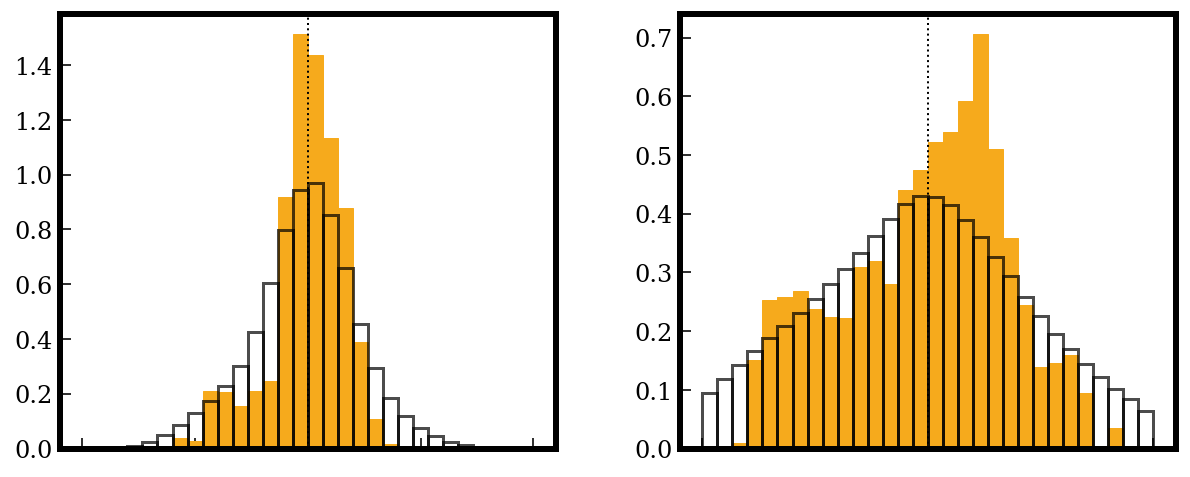

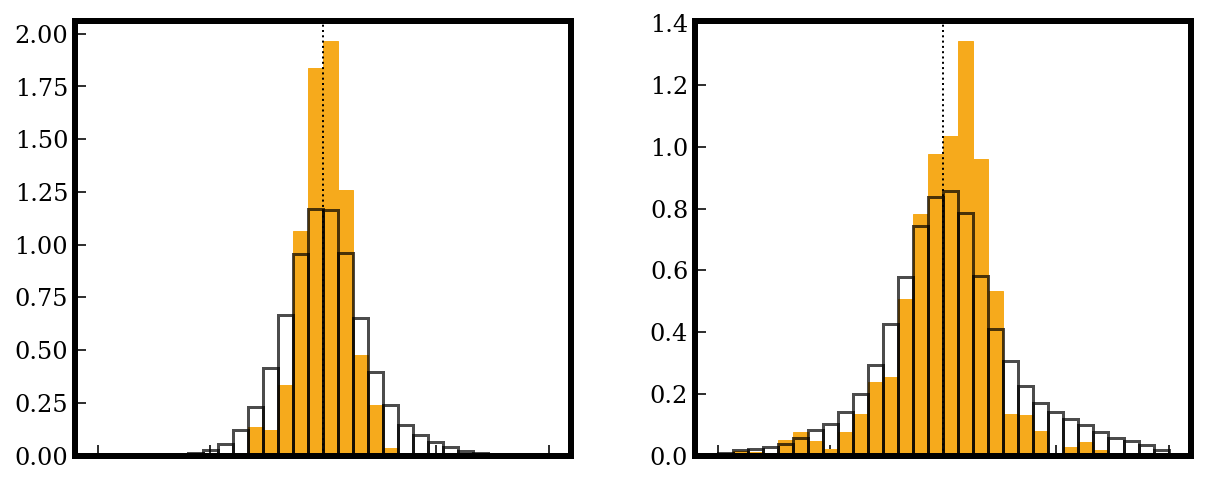

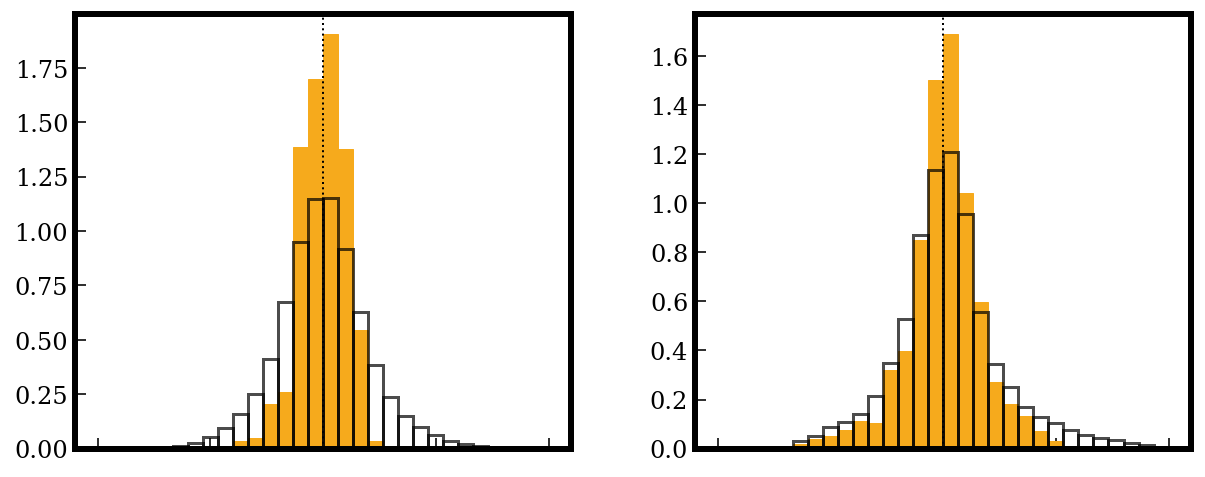

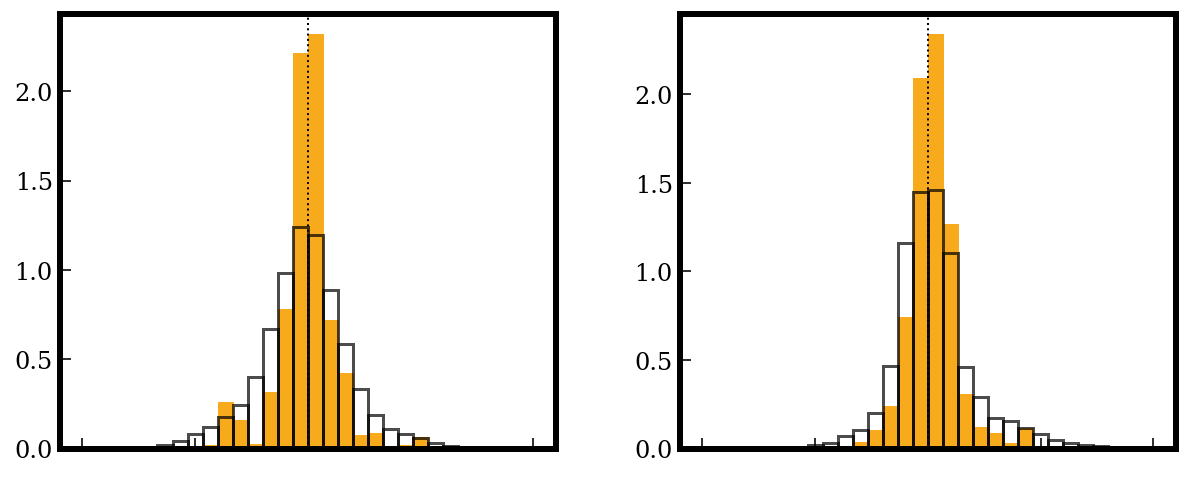

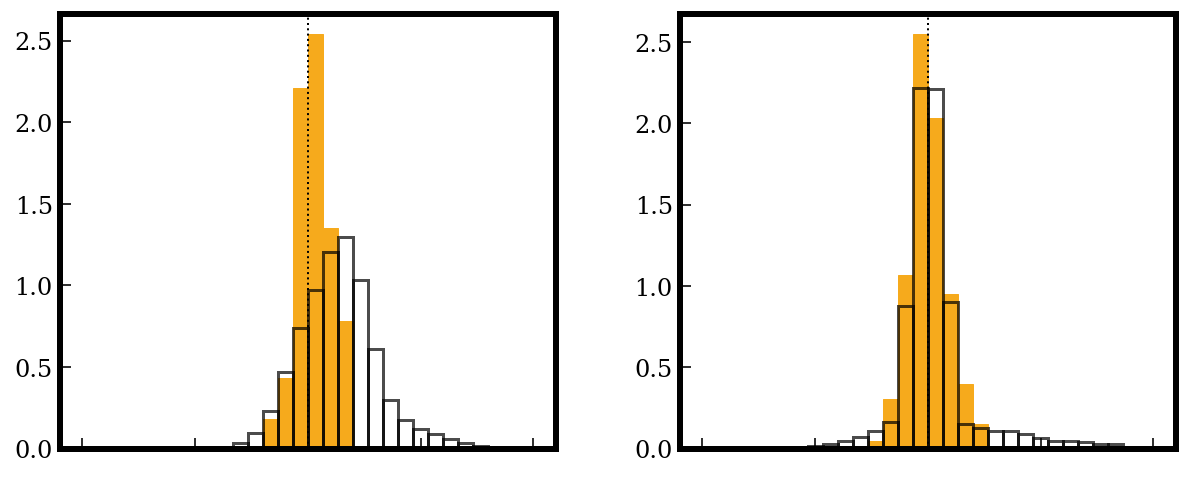

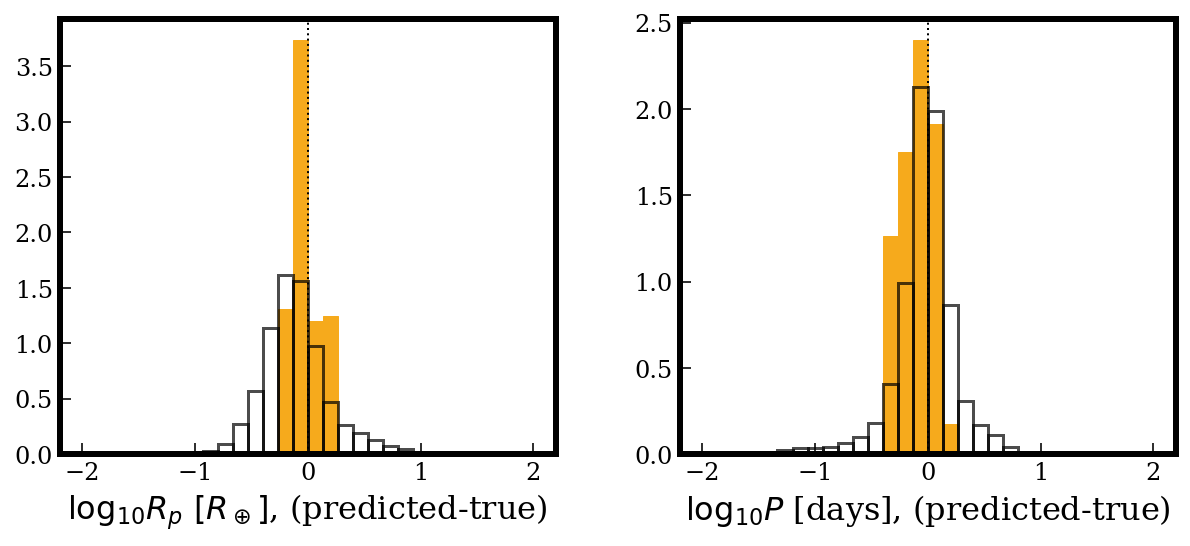

In [18]:
print(np.shape(CVdata)) #(1278,5)
print(np.shape(contextPred_allSeeds)) #(1278,2,100)
print(np.shape(randomPred_allSeeds))  #(1278,4,10000)

predMSE = np.zeros((n_planet_features,maxmult))
randomMSE = np.zeros((n_planet_features,maxmult))

predMAE = np.zeros((n_planet_features,maxmult))
randomMAE = np.zeros((n_planet_features,maxmult))

predMAE_linear = np.zeros((n_planet_features,maxmult))
randomMAE_linear = np.zeros((n_planet_features,maxmult))

betterThan = np.zeros((n_planet_features,maxmult))
betterThanFrac = np.zeros((n_planet_features,maxmult))

nPlanets = np.zeros((n_planet_features,maxmult))
nPlanets_MSE = np.zeros((n_planet_features,maxmult))

for m in np.sort(np.unique(mults)):
    print("m is {0}".format(m))

    # histograms of (X_predicted - X_true)/X_true
    fig,axes = plt.subplots(1,n_planet_features,figsize = (n_planet_features*5,4))

    for i in range(n_planet_features):
        phys_truth = ((CVdata[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m] #(786,)
        
        err_pred = np.zeros_like(phys_truth)
        err_pred_linear = np.zeros_like(phys_truth)
        
        for j in range(np.shape(contextPred_allSeeds)[-1]):
            print("j is {0}".format(j))
            phys_pred = ((contextPred_allSeeds[:,i,j]*sigmas[i])+mus[i])[CVdata[:,-1] == m]
            err_pred_j = (phys_pred - phys_truth)
            err_pred_linear_j = (10**phys_pred - 10**phys_truth)
            err_pred = np.vstack((err_pred,err_pred_j))
            err_pred_linear = np.vstack((err_pred_linear, err_pred_linear_j))
            
        err_pred = err_pred[1:]
        err_pred = np.ravel(err_pred)
        
        err_pred_linear = err_pred_linear[1:]
        err_pred_linear = np.ravel(err_pred_linear)
        
        
        err_random = np.zeros_like(phys_truth)
        err_random_linear = np.zeros_like(phys_truth)
        
        for j in range(np.shape(randomPred_allSeeds)[-1]):
            print("j is {0}".format(j))
            phys_random = ((randomPred_allSeeds[:,i,j]*sigmas[i])+mus[i])[CVdata[:,-1] == m]
            err_random_j = (phys_random - phys_truth)
            err_random_linear_j = (10**phys_random - 10**phys_truth)
            err_random = np.vstack((err_random,err_random_j))
            err_random_linear = np.vstack((err_random_linear, err_random_linear_j))
            
        err_random = err_random[1:]
        
        betterThanMask = (np.mean(np.abs(err_pred),axis=0) < np.mean(np.abs(err_random),axis=0))
        betterThanFrac[int(i),int(m)-1] = len(phys_truth[betterThanMask])/len(phys_truth)
        betterThan[int(i),int(m)-1] = len(phys_truth[betterThanMask])
        
        err_random = np.ravel(err_random)
        
        err_random_linear = err_random_linear[1:]
        err_random_linear = np.ravel(err_random_linear)
        """
        phys_pred = ((NN50[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m] 
        unc_pred = (((NN84[:,i] - NN16[:,i])*sigmas[i])+mus[i])[CVdata[:,-1] == m]
        err_pred = (phys_pred - phys_truth)#/phys_truth
        err_pred_linear = (10**phys_pred - 10**phys_truth)
        
        phys_random = ((random50[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m]
        unc_random = (((random84[:,i] - random16[:,i])*sigmas[i])+mus[i])[CVdata[:,-1] == m]
        err_random = (phys_random - phys_truth)
        err_random_linear = (10**phys_random - 10**phys_truth)
        """
        MSE_pred = (1/len(err_pred))*np.sum(err_pred**2)
        MSE_random = (1/len(err_random))*np.sum(err_random**2)
        
        MAE_pred = (1/len(err_pred))*np.sum(np.abs(err_pred))
        MAE_random = (1/len(err_random))*np.sum(np.abs(err_random))
        
        MAE_pred_linear = (1/len(err_pred_linear))*np.sum(np.abs(err_pred_linear))
        MAE_random_linear = (1/len(err_random_linear))*np.sum(np.abs(err_random_linear))
        
        skew_pred = skew(err_pred)
        skew_random = skew(err_random)
        
        
        nPlanets[int(i),int(m)-1] = len(phys_truth)
        nPlanets_MSE[int(i),int(m)-1] = len(err_pred)
        
        predMSE[int(i),int(m)-1] = MSE_pred
        randomMSE[int(i),int(m)-1] = MSE_random
        predMAE[int(i),int(m)-1] = MAE_pred
        randomMAE[int(i),int(m)-1] = MAE_random
        predMAE_linear[int(i),int(m)-1] = MAE_pred_linear
        randomMAE_linear[int(i),int(m)-1] = MAE_random_linear

        axes[i].hist(err_pred,density=True,range=lims[i],bins=30,facecolor="#F6AA1C",edgecolor="#F6AA1C",alpha=1,label="network-predicted\nMSE={0:.1e},\nskewness={1:.1f}".format(MSE_pred,skew_pred),zorder=1)
        axes[i].hist(err_random,density=True,range=lims[i],bins=30,facecolor="None",edgecolor="k",lw=1.5,alpha=0.7,label="random\nMSE={0:.1e},\nskewness={1:.1f}".format(MSE_random,skew_random),zorder=3)    
        
        axes[i].axvline(x=0,color='k',ls=':',lw=1)
        if m==6:
            axes[i].set_xlabel("{0}, (predicted-true)".format(labels[i]),fontsize=16)
        else:
            axes[i].set_xticklabels([])

        #axes[i].set_ylabel("count".format(labels[i]),fontsize=16)
        #axes[i].legend(loc="upper right",frameon=False)
    #axes[0].set_ylabel("m = {0}".format(int(m)),fontsize=18)
    plt.subplots_adjust(wspace=0.25)
    #plt.show()
    plt.savefig("./{0}/realKOIs_finalFeatures_incJ_30percent_CV_stablePredictions_hist_overAllSeeds_mult={2}.pdf".format(resultsFolder,seed,m),fmt="pdf",bbox_inches="tight")
    #plt.close()



In [23]:
print(nPlanets)
print(betterThanFrac)
print(betterThan)

#average fraction where NN outperforms naive, weighted by number of planets
print(np.average(betterThanFrac[0],weights=nPlanets[0])) #radius
print(np.average(betterThanFrac[1],weights=nPlanets[1])) #period

#average fraction where NN outperforms naive, weighted by number of planets, m>1 only
print(np.average(betterThanFrac[0,1:],weights=nPlanets[0,1:])) #radius 
print(np.average(betterThanFrac[1,1:],weights=nPlanets[1,1:])) #period

[[786. 258. 144.  64.  20.   6.]
 [786. 258. 144.  64.  20.   6.]]
[[0.83206107 1.         1.         1.         1.         1.        ]
 [0.63358779 0.74806202 0.65972222 0.71875    0.4        0.5       ]]
[[654. 258. 144.  64.  20.   6.]
 [498. 193.  95.  46.   8.   3.]]
0.8967136150234741
0.6596244131455399
1.0
0.7012195121951219


In [24]:
"""
markers=['.','v','X','1','s','x','^','2','D','o']
fig,axes = plt.subplots(n_planet_features,1,figsize=(6,6*n_planet_features))
for j in range(n_planet_features):
    axes[j].plot(np.arange(1,maxmult+1),predMSE[j],color='#F6AA1C',marker='.',mec='k',ms=10)
    axes[j].plot(np.arange(1,maxmult+1),randomMSE[j],color='k',marker='.',mec='k',ms=10)
    axes[j].set_xlabel("multiplicity",fontsize=16)
    #axes[j].set_ylabel("mean absolute error",fontsize=16)
    axes[j].set_yscale("log")
    axes[j].set_title("{0}".format(labels[j]),fontsize=18)
    for tick in axes[j].xaxis.get_major_ticks():
        tick.label.set_fontsize(13)
    for tick in axes[j].yaxis.get_major_ticks():
        tick.label.set_fontsize(13)

plt.subplots_adjust(hspace=0.25)
#plt.savefig("./{0}/realKOIs_finalFeatures_incJ_30percent_CV_MAEcomparison_{1}.pdf".format(resultsFolder,seed),fmt="pdf",bbox_inches='tight')
plt.show()
"""

'\nmarkers=[\'.\',\'v\',\'X\',\'1\',\'s\',\'x\',\'^\',\'2\',\'D\',\'o\']\nfig,axes = plt.subplots(n_planet_features,1,figsize=(6,6*n_planet_features))\nfor j in range(n_planet_features):\n    axes[j].plot(np.arange(1,maxmult+1),predMSE[j],color=\'#F6AA1C\',marker=\'.\',mec=\'k\',ms=10)\n    axes[j].plot(np.arange(1,maxmult+1),randomMSE[j],color=\'k\',marker=\'.\',mec=\'k\',ms=10)\n    axes[j].set_xlabel("multiplicity",fontsize=16)\n    #axes[j].set_ylabel("mean absolute error",fontsize=16)\n    axes[j].set_yscale("log")\n    axes[j].set_title("{0}".format(labels[j]),fontsize=18)\n    for tick in axes[j].xaxis.get_major_ticks():\n        tick.label.set_fontsize(13)\n    for tick in axes[j].yaxis.get_major_ticks():\n        tick.label.set_fontsize(13)\n\nplt.subplots_adjust(hspace=0.25)\n#plt.savefig("./{0}/realKOIs_finalFeatures_incJ_30percent_CV_MAEcomparison_{1}.pdf".format(resultsFolder,seed),fmt="pdf",bbox_inches=\'tight\')\nplt.show()\n'

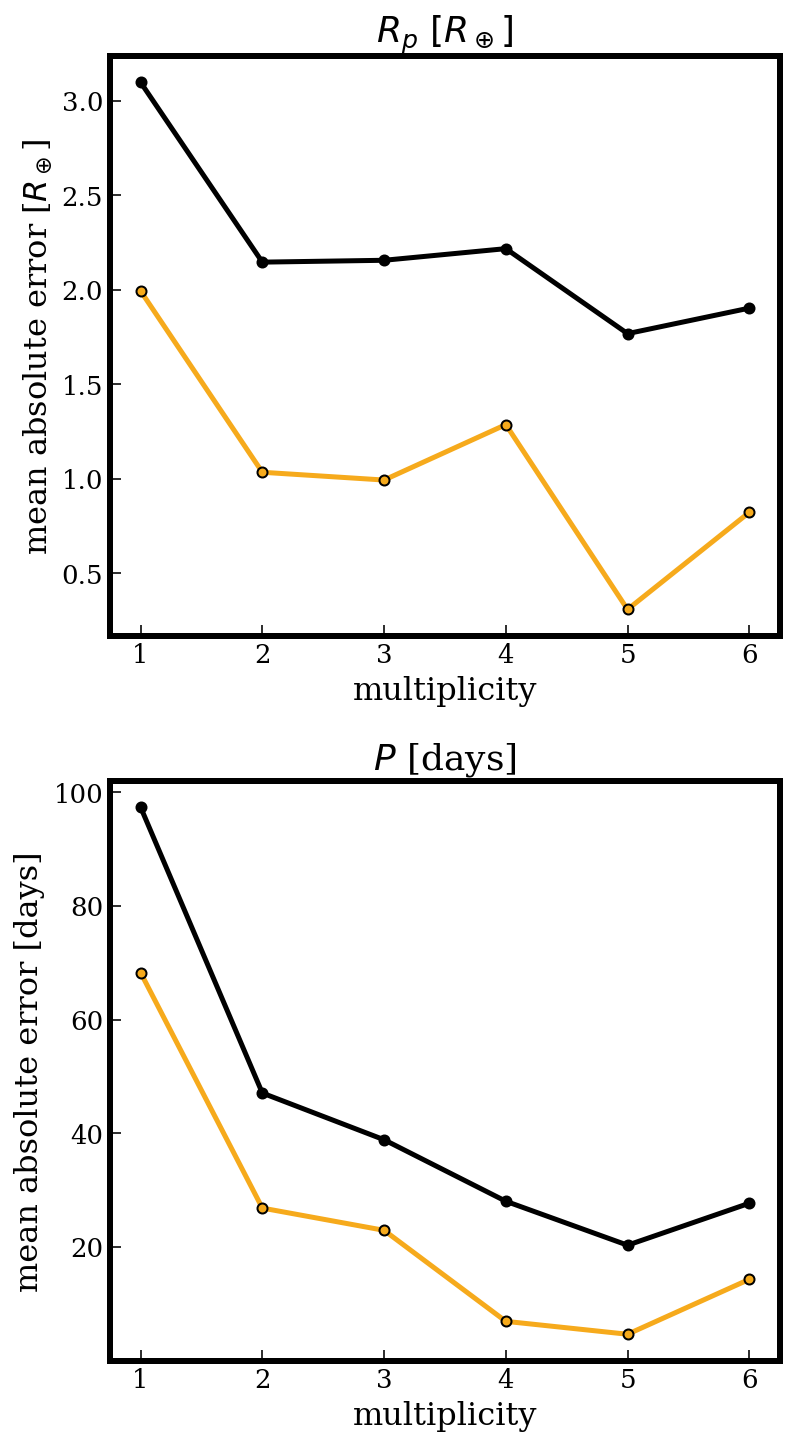

In [25]:
linear_labels = [r'$R_p\ [R_\oplus]$',r'$P$ [days]',r'$T_{eff}$ [K]',r'$\log{g}\ [\mathrm{cm}/\mathrm{s}^2]$']
units = ['$R_\oplus$',r'days']
markers=['.','v','X','1','s','x','^','2','D','o']
fig,axes = plt.subplots(n_planet_features,1,figsize=(6,6*n_planet_features))
for j in range(n_planet_features):
    axes[j].plot(np.arange(1,maxmult+1),predMAE_linear[j],color='#F6AA1C',marker='.',mec='k',ms=10)
    axes[j].plot(np.arange(1,maxmult+1),randomMAE_linear[j],color='k',marker='.',mec='k',ms=10)
    axes[j].set_xlabel("multiplicity",fontsize=16)
    axes[j].set_ylabel("mean absolute error [{0}]".format(units[j]),fontsize=16)
    #axes[j].set_yscale("log")
    axes[j].set_title("{0}".format(linear_labels[j]),fontsize=18)
    for tick in axes[j].xaxis.get_major_ticks():
        tick.label.set_fontsize(13)
    for tick in axes[j].yaxis.get_major_ticks():
        tick.label.set_fontsize(13)
        
plt.subplots_adjust(hspace=0.25)
plt.savefig("./{0}/realKOIs_finalFeatures_incJ_30percent_CV_MAEcomparison_linear_overAllSeeds.pdf".format(resultsFolder),fmt="pdf",bbox_inches='tight')
#plt.show()



In [26]:
print(np.shape(predMSE)[0])

2


In [27]:
"""
# how much better did we do? MSE
print(np.mean(randomMSE[0]/predMSE[0])) #radius
print(np.mean(randomMSE[1]/predMSE[1])) #period

print(np.average(randomMSE[0]/predMSE[0],weights=nPlanets_MSE[0])) #radius
print(np.average(randomMSE[1]/predMSE[1],weights=nPlanets_MSE[1])) #period

print(np.average(randomMSE[0,1:]/predMSE[0,1:],weights=nPlanets_MSE[0,1:])) #radius
print(np.average(randomMSE[1,1:]/predMSE[1,1:],weights=nPlanets_MSE[1,1:])) #period
"""

'\n# how much better did we do? MSE\nprint(np.mean(randomMSE[0]/predMSE[0])) #radius\nprint(np.mean(randomMSE[1]/predMSE[1])) #period\n\nprint(np.average(randomMSE[0]/predMSE[0],weights=nPlanets_MSE[0])) #radius\nprint(np.average(randomMSE[1]/predMSE[1],weights=nPlanets_MSE[1])) #period\n\nprint(np.average(randomMSE[0,1:]/predMSE[0,1:],weights=nPlanets_MSE[0,1:])) #radius\nprint(np.average(randomMSE[1,1:]/predMSE[1,1:],weights=nPlanets_MSE[1,1:])) #period\n'

In [28]:
"""
# how much better did we do? mean absolute error, log space
print(np.mean(randomMAE[0]/predMAE[0])) #radius
print(np.mean(randomMAE[1]/predMAE[1])) #period

print(np.average(randomMAE[0]/predMAE[0],weights=nPlanets_MSE[0])) #radius
print(np.average(randomMAE[1]/predMAE[1],weights=nPlanets_MSE[1])) #period

print(np.average(randomMAE[0,1:]/predMAE[0,1:],weights=nPlanets_MSE[0,1:])) #radius
print(np.average(randomMAE[1,1:]/predMAE[1,1:],weights=nPlanets_MSE[1,1:])) #period
"""

'\n# how much better did we do? mean absolute error, log space\nprint(np.mean(randomMAE[0]/predMAE[0])) #radius\nprint(np.mean(randomMAE[1]/predMAE[1])) #period\n\nprint(np.average(randomMAE[0]/predMAE[0],weights=nPlanets_MSE[0])) #radius\nprint(np.average(randomMAE[1]/predMAE[1],weights=nPlanets_MSE[1])) #period\n\nprint(np.average(randomMAE[0,1:]/predMAE[0,1:],weights=nPlanets_MSE[0,1:])) #radius\nprint(np.average(randomMAE[1,1:]/predMAE[1,1:],weights=nPlanets_MSE[1,1:])) #period\n'

In [29]:
# how much better did we do? mean absolute error, linear space
print(np.mean(randomMAE_linear[0]/predMAE_linear[0])) #radius
print(np.mean(randomMAE_linear[1]/predMAE_linear[1])) #period

print(np.average(randomMAE_linear[0]/predMAE_linear[0],weights=nPlanets_MSE[0])) #radius
print(np.average(randomMAE_linear[1]/predMAE_linear[1],weights=nPlanets_MSE[1])) #period

#this is the set of numbers I used last time....before including the recent KOIs, we had 2.4, 1.8 respectively (see thesis)
# now we have 2.2, 2.1!!
print(np.average(randomMAE_linear[0,1:]/predMAE_linear[0,1:],weights=nPlanets_MSE[0,1:])) #radius
print(np.average(randomMAE_linear[1,1:]/predMAE_linear[1,1:],weights=nPlanets_MSE[1,1:])) #period

2.5941441319768574
2.5415144558381506
1.805893824578292
1.7033132419415917
2.208581604573645
2.1456483132383646


In [19]:
#OLD

# how much better did we do? mean absolute error, linear space
print(np.mean(randomMAE_linear[0]/predMAE_linear[0])) #radius
print(np.mean(randomMAE_linear[1]/predMAE_linear[1])) #period

print(np.average(randomMAE_linear[0]/predMAE_linear[0],weights=nPlanets_MSE[0])) #radius
print(np.average(randomMAE_linear[1]/predMAE_linear[1],weights=nPlanets_MSE[1])) #period

#this is the set of numbers I used last time....before including the recent KOIs, we had 2.4, 1.8 respectively (see thesis)
# now we have 2.2, 2.1!!
print(np.average(randomMAE_linear[0,1:]/predMAE_linear[0,1:],weights=nPlanets_MSE[0,1:])) #radius
print(np.average(randomMAE_linear[1,1:]/predMAE_linear[1,1:],weights=nPlanets_MSE[1,1:])) #period

2.5492969026183103
2.6207474879389347
1.8706738816457362
1.7065393256306558
2.200474693303641
2.155581710622957


In [68]:
786+258+144+64+20+6

1278